# Compare the General Performance of CABG
 - Create a dataframe containing the severity of stenosis using FFR, and if the stenosis subtended territory is ischemic.
 - Add the point-based or voxel-based MBF value to the data-frame (or create a new one?)
 - Violin Plots:
    - Pre/Post MBF against ischemic-grafted, non-ischemic-grafted, non-ischemic nongrafted
    - Pre/Post MBF against severity of stenosis (none, mild, moderate, severe)

In [7]:
import glob
import os
import vtk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, wilcoxon, linregress, norm
from scipy.ndimage import gaussian_filter
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from utilities import ReadVTUFile, ThresholdInBetween, ThresholdByUpper, LargestConnectedRegion, WriteVTUFile
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

color1 = "royalblue"
color2 = "orangered"

In [2]:
path = "/Volumes/T7_Research/CABG_Backup/05_PrePostCABG/InterPatientStudy"
opath = os.path.join(path,"MappedPreCABG")
os.system(f"mkdir {opath}")
metadata = glob.glob(f"{path}/*.xlsx")
print(metadata)
VTUFiles = sorted(glob.glob(f"{path}/*.vtu"))
TerritoryLabels = sorted(glob.glob(f"{path}/*.dat"))
print(VTUFiles)

PatientMetadata = pd.read_excel(metadata[1], dtype={'column_name': str})


mkdir: /Volumes/T7_Research/CABG_Backup/05_PrePostCABG/InterPatientStudy/MappedPreCABG: File exists


['/Volumes/T7_Research/CABG_Backup/05_PrePostCABG/InterPatientStudy/~$PatientMetadata.xlsx', '/Volumes/T7_Research/CABG_Backup/05_PrePostCABG/InterPatientStudy/PatientMetadata.xlsx']
['/Volumes/T7_Research/CABG_Backup/05_PrePostCABG/InterPatientStudy/SU03A_MBF_Territories.vtu', '/Volumes/T7_Research/CABG_Backup/05_PrePostCABG/InterPatientStudy/SU03B_MBF_Territories.vtu', '/Volumes/T7_Research/CABG_Backup/05_PrePostCABG/InterPatientStudy/SU04A_MBF_Territories.vtu', '/Volumes/T7_Research/CABG_Backup/05_PrePostCABG/InterPatientStudy/SU04B_MBF_Territories.vtu', '/Volumes/T7_Research/CABG_Backup/05_PrePostCABG/InterPatientStudy/SU06A_MBF_Territories.vtu', '/Volumes/T7_Research/CABG_Backup/05_PrePostCABG/InterPatientStudy/SU06B_MBF_Territories.vtu', '/Volumes/T7_Research/CABG_Backup/05_PrePostCABG/InterPatientStudy/SU07A_MBF_Territories.vtu', '/Volumes/T7_Research/CABG_Backup/05_PrePostCABG/InterPatientStudy/SU07B_MBF_Territories.vtu', '/Volumes/T7_Research/CABG_Backup/05_PrePostCABG/InterPa

In [3]:
print(PatientMetadata)

   patient-id stenosis tag   graft severity-anatomical (%)  is-ischemic  \
0        SU03         Diag  Radial                     100         True   
1        SU03          LAD    LIMA                      70        False   
2        SU03          RCA     SVG                     100         True   
3        SU04          LAD    LIMA                      80        False   
4        SU04          LCx  Radial                      80         True   
..        ...          ...     ...                     ...          ...   
70       VA08          LCx     SVG                       n         True   
71       VA08          RCA     SVG                       n         True   
72       VA20          LAD    LIMA                       n         True   
73       VA20          LCx     SVG                       n        False   
74       VA20          RCA     SVG                       n         True   

    cutoff   NG Note  graft-stenosis  
0       90   IM  NaN               0  
1       90  OM1  NaN 

In [4]:
patient_ids = sorted(set(PatientMetadata["patient-id"]))
print(patient_ids)

['SU03', 'SU04', 'SU06', 'SU07', 'SU10', 'SU11', 'SU13', 'SU14', 'SU16', 'SU21', 'SU23', 'SU24', 'SU25', 'SU26', 'SU27', 'SU28', 'SU30', 'SU33', 'SU34', 'VA02', 'VA04', 'VA06', 'VA08', 'VA10', 'VA13', 'VA14', 'VA16', 'VA20']


In [30]:
def ReadLabels(InputLabels, TerritoryTag):
    MBF_Labels = {}
    for tag in TerritoryTag:
        MBF_Labels[tag] =  []
    MBF_Labels["Nongrafted-Stenosis"] = []
    MBF_Labels["Nongrafted"] = []
    with open(InputLabels, "r") as ifile:
        for i, LINE in enumerate(ifile):
            if i == 0: 
                continue
            line = LINE.strip().split()
            label = line[1]
            id_value = int(line[0])
            found = False

            for key in TerritoryTag:
                if key in label: 
                    MBF_Labels[key].append(id_value)
                    found = True
            
            if not found:
                if "NG" in label:
                    MBF_Labels["Nongrafted-Stenosis"].append(id_value)
                    found = True
                else:
                    MBF_Labels["Nongrafted"].append(id_value)

    MBF_Labels = {k.replace('post_', ''):v for k,v in MBF_Labels.items() if len(v)>0}
    
    return MBF_Labels

def robust_mode(data, bins=50):
    counts, bin_edges = np.histogram(data, bins=bins)
    max_bin_index = np.argmax(counts)
    mode_value = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2
    return mode_value

def Normalize(MBF, method="mode", cutoff = 50):
    for i in range(MBF.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ArrayName = arrayname_
    
    ScalarArray = vtk_to_numpy(MBF.GetPointData().GetArray(ArrayName))
    #HealthyMyo = LargestConnectedRegion(ThresholdByUpper(MBF, ArrayName, cutoff))
    HealthyMyo = LargestConnectedRegion(ThresholdInBetween(MBF, ArrayName, np.percentile(ScalarArray,10), np.percentile(ScalarArray,90)))
    #HealthyMyo = LargestConnectedRegion(ThresholdByUpper(HealthyMyo, ArrayName, cutoff))
    ScalarArray_healthy = vtk_to_numpy(HealthyMyo.GetPointData().GetArray(ArrayName))
    
    if method == "mode": # Histogram Analysis
        # Using Freedman-Diaconis Rule to calculate the number of bins based on IQR
        IQR = np.percentile(ScalarArray_healthy, 75) - np.percentile(ScalarArray_healthy, 25)
        bin_width = 2*IQR/(len(ScalarArray_healthy))**(1/3)
        MBF_range = np.max(ScalarArray_healthy) - np.min(ScalarArray_healthy)
        bins = int(MBF_range/bin_width)
        ref_MBF = robust_mode(ScalarArray_healthy, bins)
    elif method == "median":
        ref_MBF = np.median(ScalarArray_healthy)
    elif method == "mean":
        ref_MBF = np.mean(ScalarArray_healthy)
    elif method == "classic":
        ref_MBF = np.percentile(ScalarArray, 75)
    elif method == "zscore":
        q1, q2, q3 = np.percentile(ScalarArray_healthy, [25, 50, 75])
        IndexMBFArray = (ScalarArray - q2)/(q3 - q1)
        IndexMBFArray = gaussian_filter(IndexMBFArray, sigma=1)
        IndexMBF = numpy_to_vtk(IndexMBFArray)
        IndexMBF.SetName("IndexMBF")
        MBF.GetPointData().AddArray(IndexMBF)

        return MBF
    else:
        ref_MBF = np.percentile(ScalarArray_healthy, 75)

    IndexMBFArray = ScalarArray/ref_MBF
    #IndexMBFArray = gaussian_filter(IndexMBFArray, sigma=1)
    IndexMBF = numpy_to_vtk(IndexMBFArray)
    IndexMBF.SetName("IndexMBF")
    MBF.GetPointData().AddArray(IndexMBF)

    return MBF

def GetVolume(Grid):
    Volume = 0
    for i in range(Grid.GetNumberOfCells()):
        voxel = Grid.GetCell(i)
        cell_bounds = voxel.GetBounds()
        Volume += abs(cell_bounds[0] - cell_bounds[1]) * abs(cell_bounds[2] - cell_bounds[3]) * abs(cell_bounds[4] - cell_bounds[5])
    
    return Volume

def CollectMBFData(MBF, Labels):
    for i in range(MBF.GetPointData().GetNumberOfArrays()):
            arrayname_ = MBF.GetPointData().GetArrayName(i)
            if 'scalars' in arrayname_.lower():
                ScalarArray = arrayname_

    AbsMBFData = {}
    IndexMBFData = {}
    for key in Labels.keys():
        AbsMBFData[key] = np.array([])
        IndexMBFData[key] = np.array([])
        for i in Labels[key]:
            territory_ = ThresholdInBetween(MBF, "TerritoryMaps", i, i)
            MBF_ = vtk_to_numpy(territory_.GetPointData().GetArray(ScalarArray))
            iMBF_ = vtk_to_numpy(territory_.GetPointData().GetArray("IndexMBF"))
            AbsMBFData[key] = np.append(AbsMBFData[key], MBF_)
            IndexMBFData[key] = np.append(IndexMBFData[key], iMBF_)
    

    return AbsMBFData, IndexMBFData

def GetRegionVolume(MBF, Labels, key):
    volume = 0

    for i in Labels[key]:
        territory_ = ThresholdInBetween(MBF, "TerritoryMaps", i, i)
        volume += GetVolume(territory_)
    
    return volume

def BoxPlot(DataFrame):
    plt.figure(figsize=(8, 5))
    ax = sns.boxplot(x='Territories', y='MBF', hue='Type', data= DataFrame, showfliers=False, palette={'A':'skyblue', 'B':'salmon'})

    ax.set_ylabel("Index MBF", fontsize = 20)
    ax.tick_params(axis='x', rotation=10, labelsize=15)
    ax.legend(loc = 'upper left')
    plt.tight_layout()
    plt.show()

def ViolinPlot(DataFrame):
    plt.figure(figsize=(10, 6))

    sns.violinplot(x='Territories', y='MBF', hue='Type', data = DataFrame, split=True, inner = 'quartiles', bw_adjust = 10, common_norm=True, linewidth=2.5, fill= False, gap=.1, palette={'Pre-CABG':color1, 'Post-CABG':color2})

    plt.ylabel("Absolute MBF (mL/min/100g)", fontsize = 23)
    plt.tick_params(axis= 'x', labelsize = 18)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 18)
    #plt.xlabel("Group")
    plt.legend(fontsize = 16, loc="upper left")
    plt.ylim([-200, 850])
    plt.show()

def MapNongrafted(meanA, meanB, stdA, stdB, DataA):
    return meanB + (stdB/stdA)*(DataA - meanA)

def Map3DVolume(meanA, meanB, stdA, stdB, VolumeA):
    for i in range(VolumeA.GetPointData().GetNumberOfArrays()):
            arrayname_ = VolumeA.GetPointData().GetArrayName(i)
            if 'scalars' in arrayname_.lower():
                ScalarArray = arrayname_

    ScalarData = vtk_to_numpy(VolumeA.GetPointData().GetArray(ScalarArray))
    ScalarData_Mapped = numpy_to_vtk(MapNongrafted(meanA, meanB, stdA, stdB, ScalarData))
    MappedScalarArrayName = "MappedScalar"
    ScalarData_Mapped.SetName(MappedScalarArrayName)
    VolumeA.GetPointData().AddArray(ScalarData_Mapped)

    return VolumeA

def ReturnMedianMBF(Volume):
    for i in range(Volume.GetPointData().GetNumberOfArrays()):
        arrayname_ = Volume.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ScalarArray = arrayname_

    ScalarData = vtk_to_numpy(Volume.GetPointData().GetArray(ScalarArray))
    return np.median(ScalarData)

def WilcoxonTest(array1, array2):
    w_value, p_value = wilcoxon(array1, array2)
    print("Wilcoxon test statistics: ", w_value)
    print("p-value: ", p_value)
    print("number of datapoints:", len(array1))

    if p_value < 0.05:
        print("Reject the null hypothesis: There is a significant difference between the two samples.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")

    return p_value


In [6]:
print(PatientMetadata[PatientMetadata['patient-id'] == 'SU03']['stenosis tag'])

0    Diag
1     LAD
2     RCA
Name: stenosis tag, dtype: object


# Mapping Pre-CABG on Post-CABG based on the Distribution of Nongrafted regions

SU03


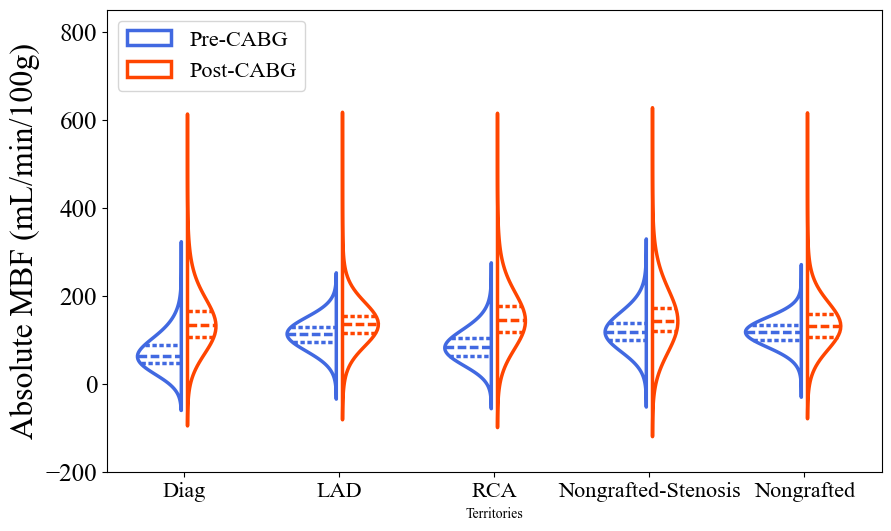

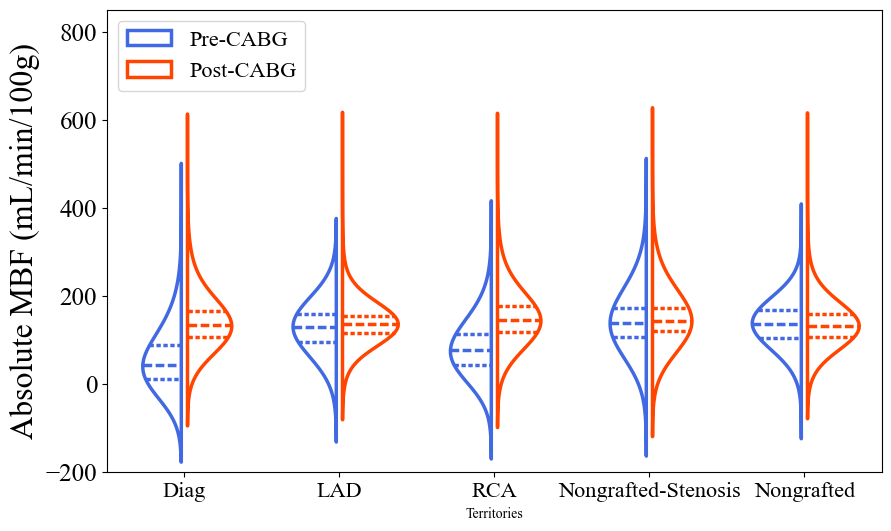

SU04


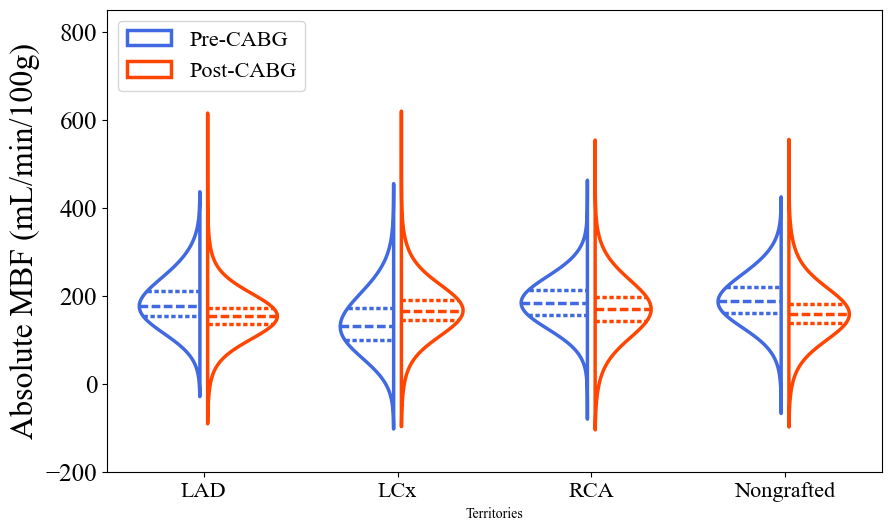

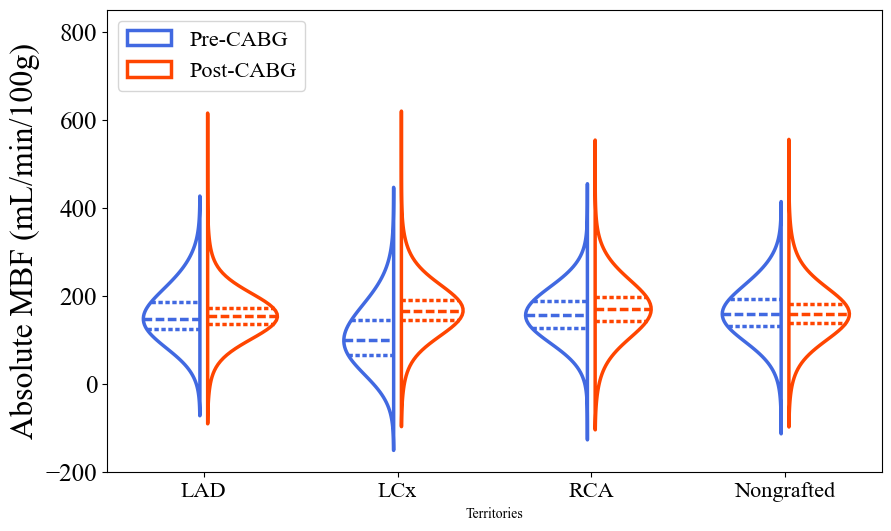

SU06


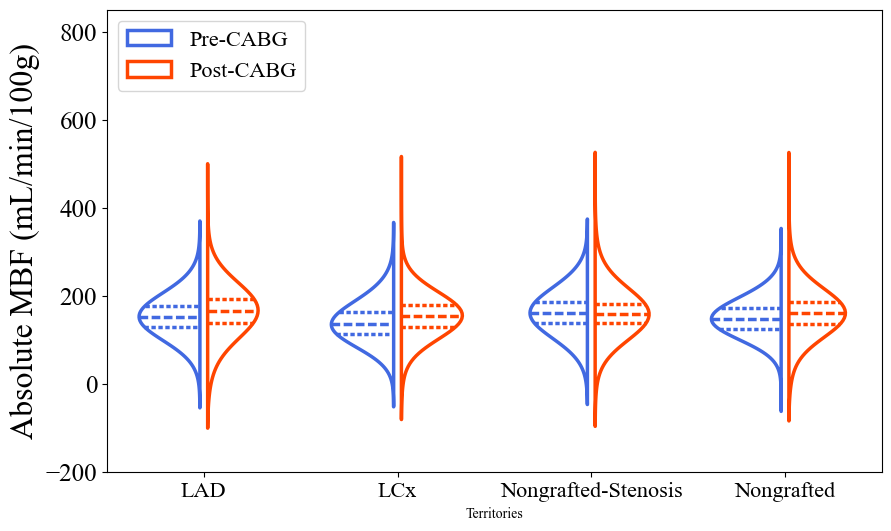

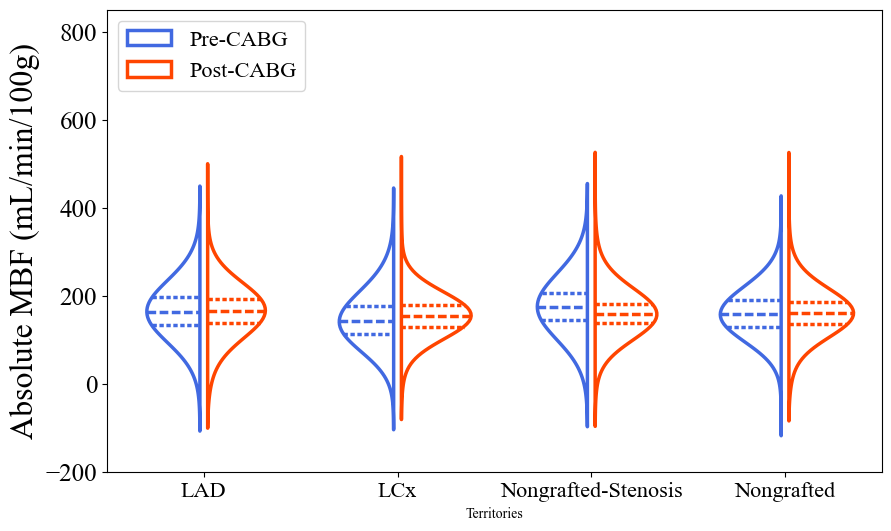

SU07


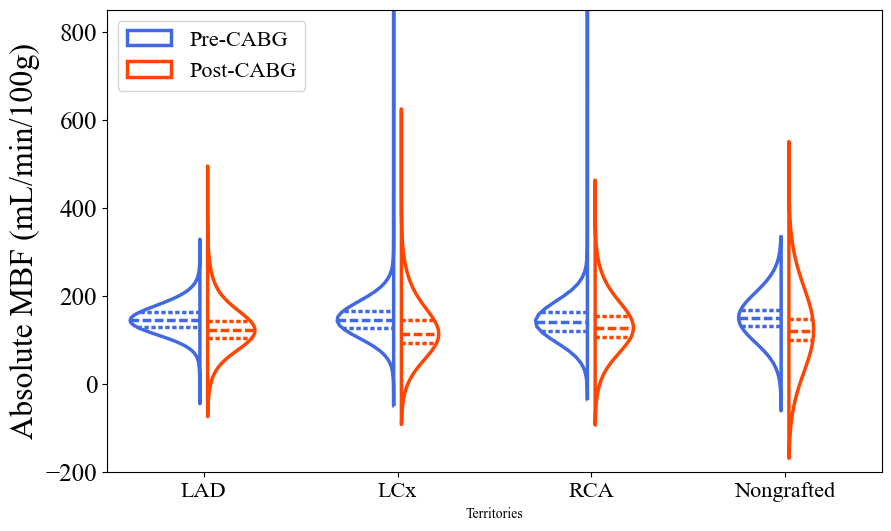

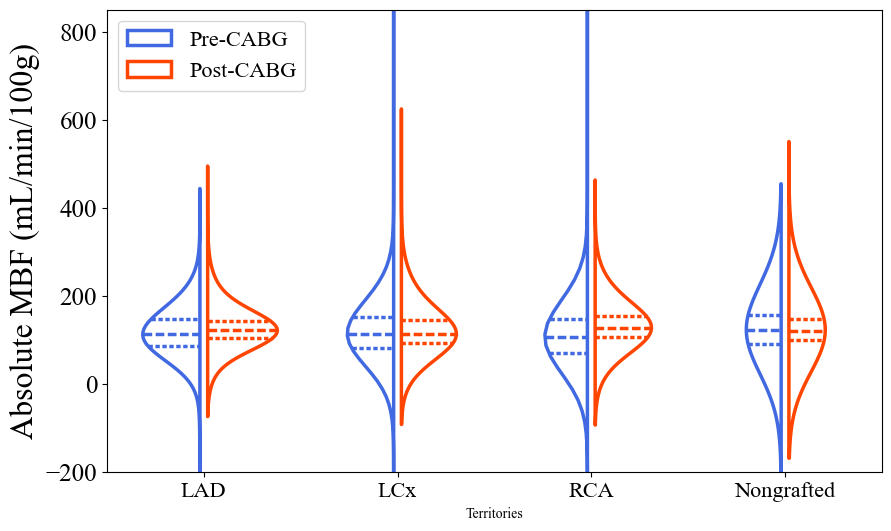

SU10


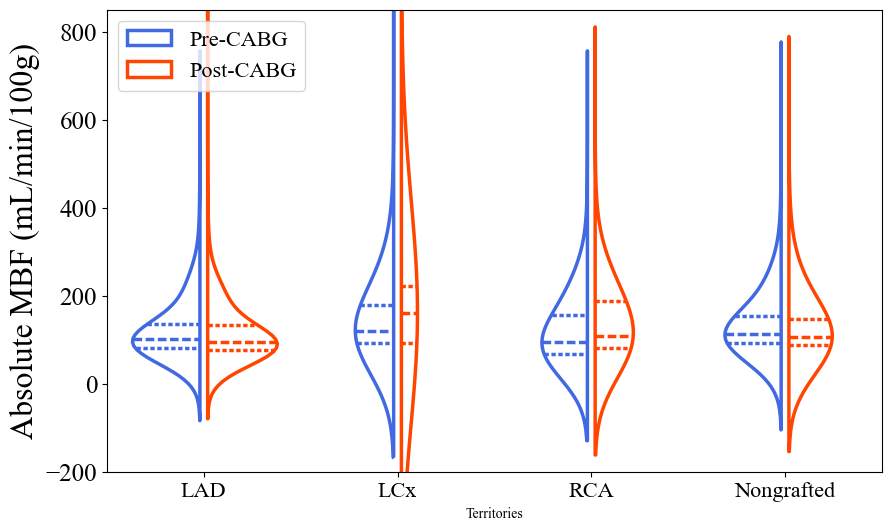

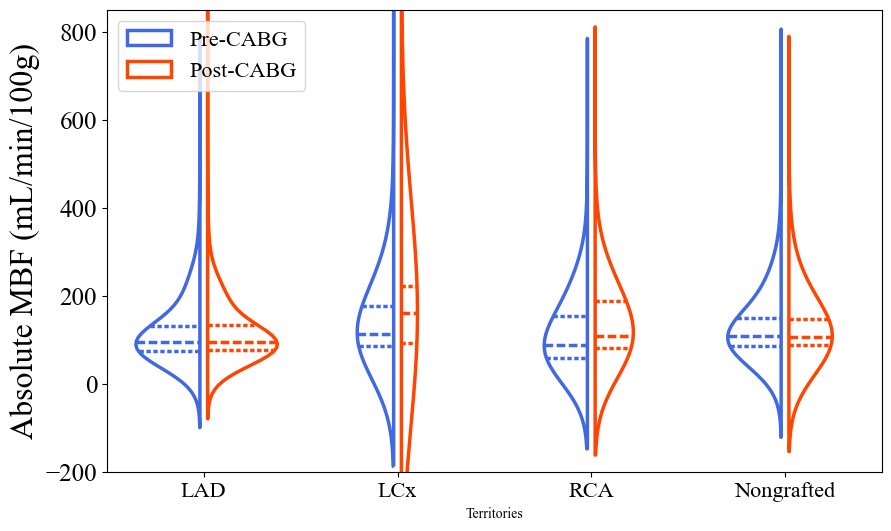

SU11


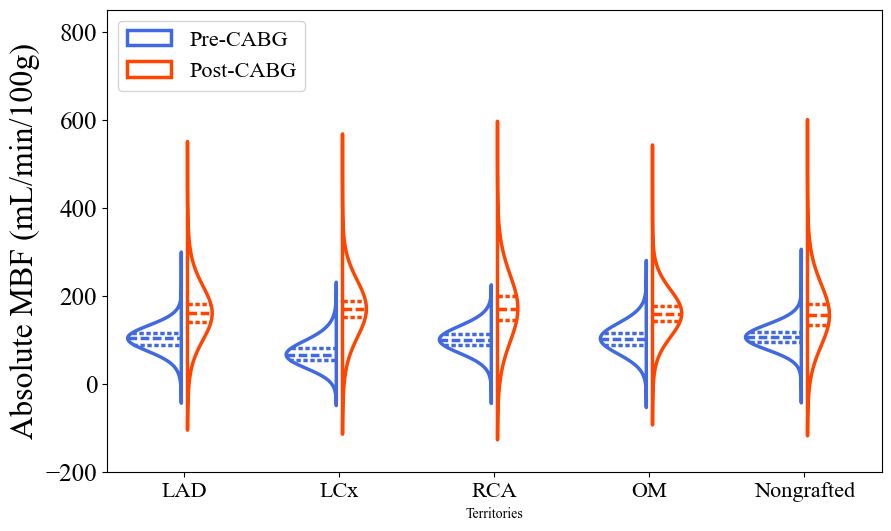

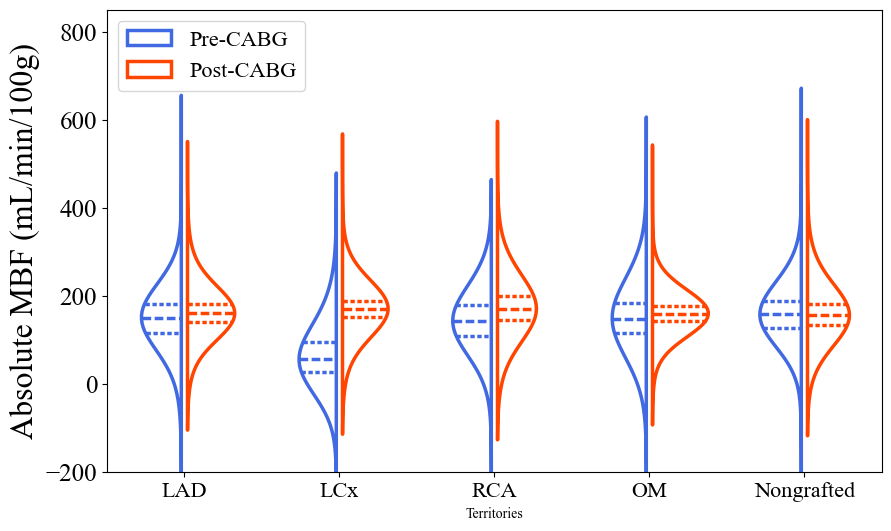

SU13


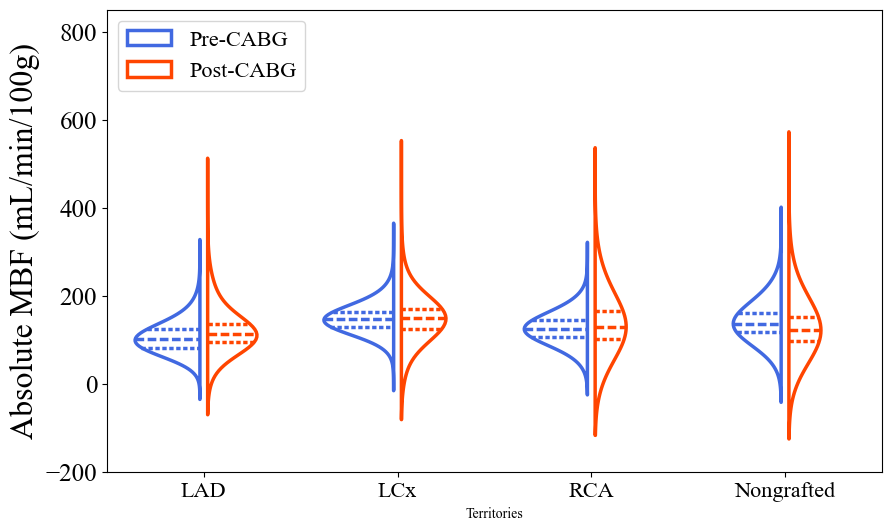

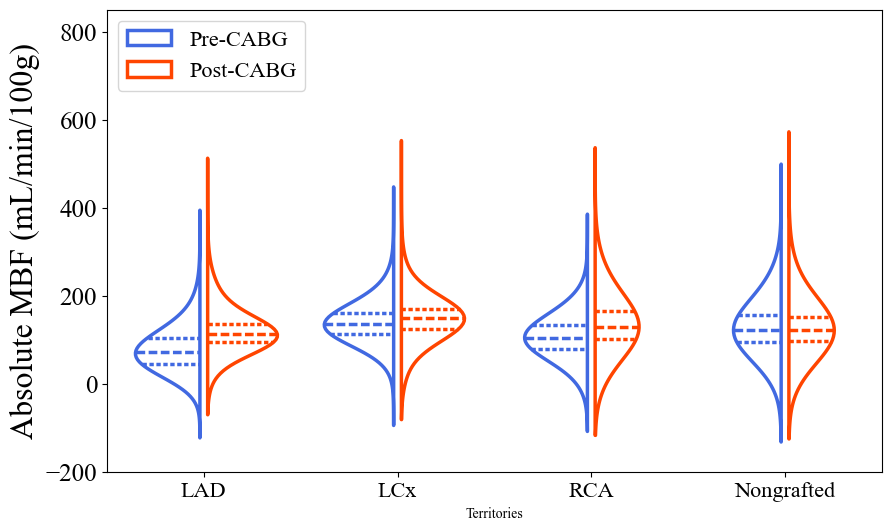

SU14


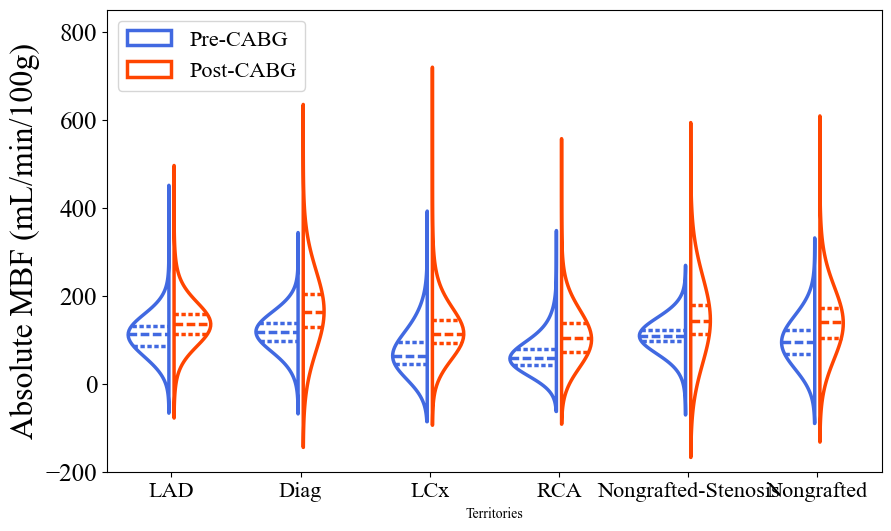

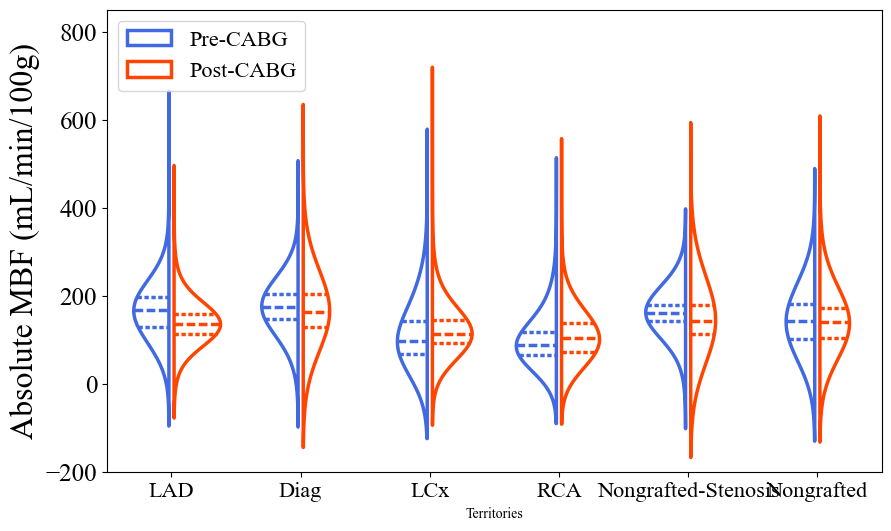

SU16


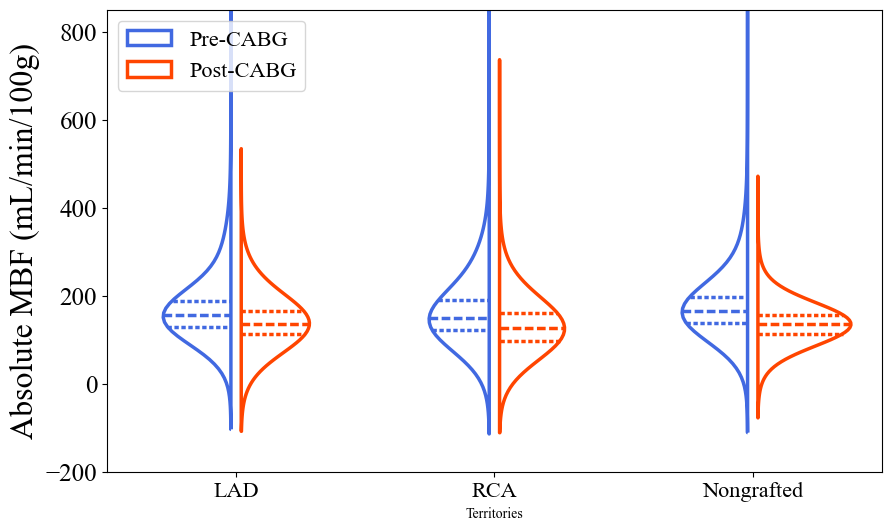

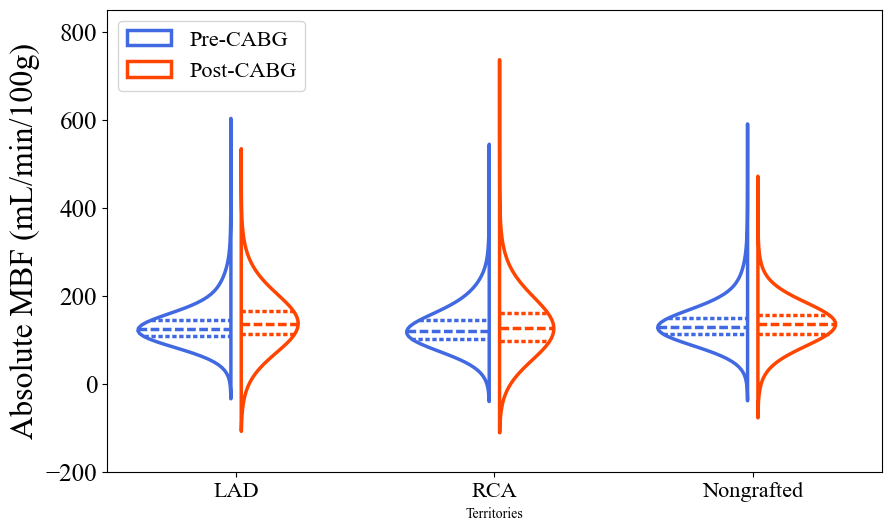

SU21


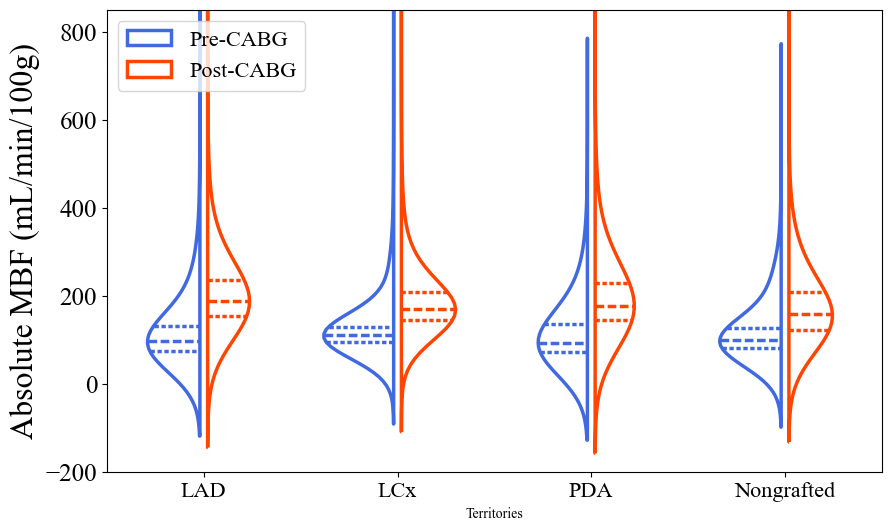

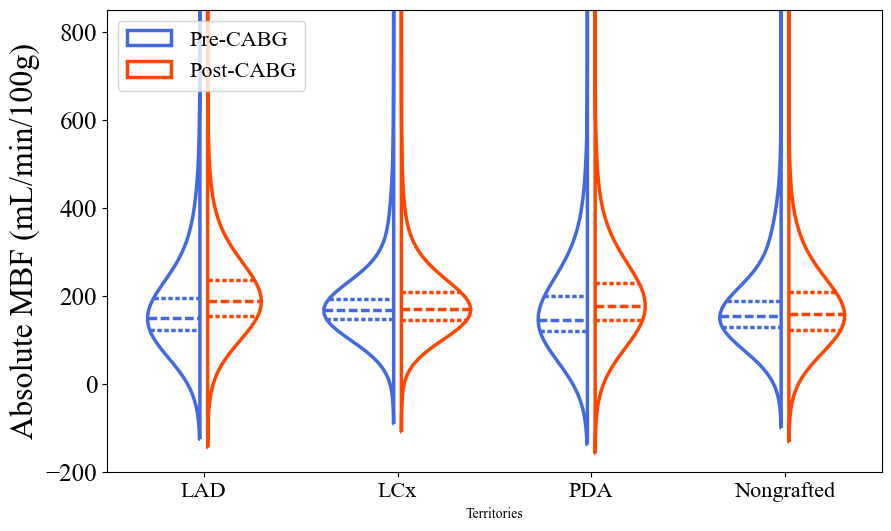

SU23


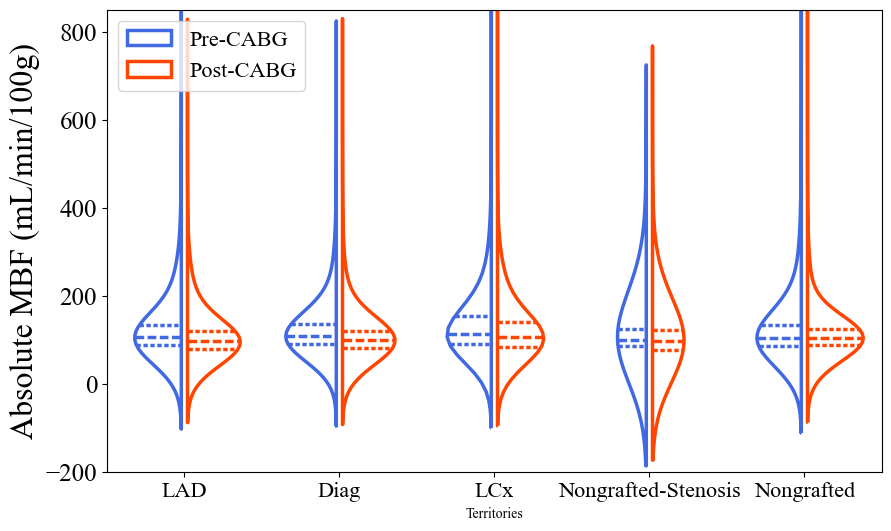

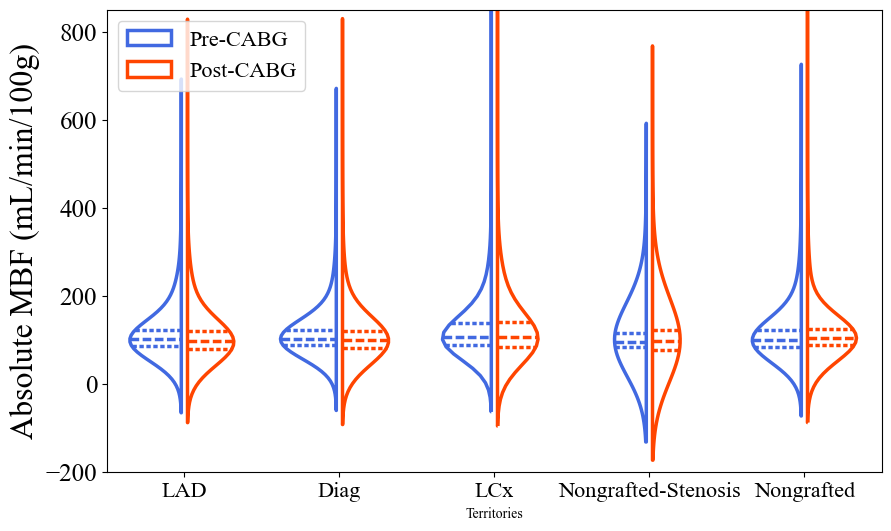

SU24


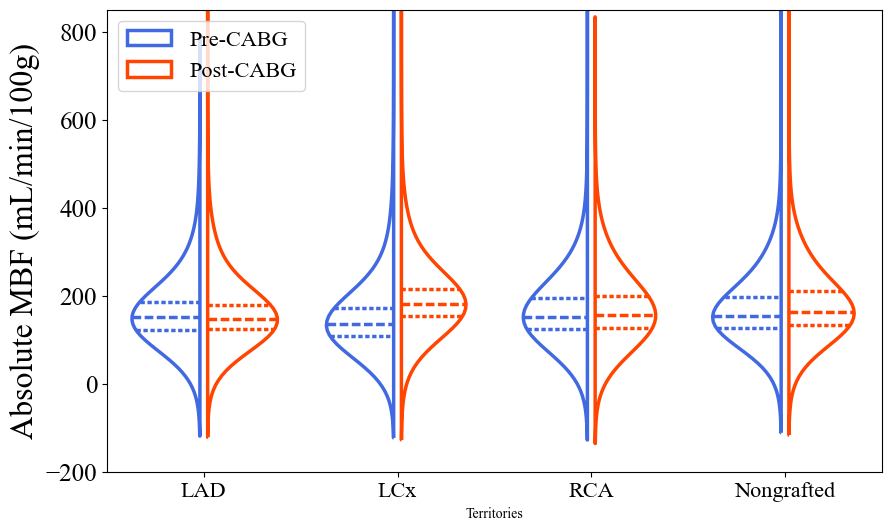

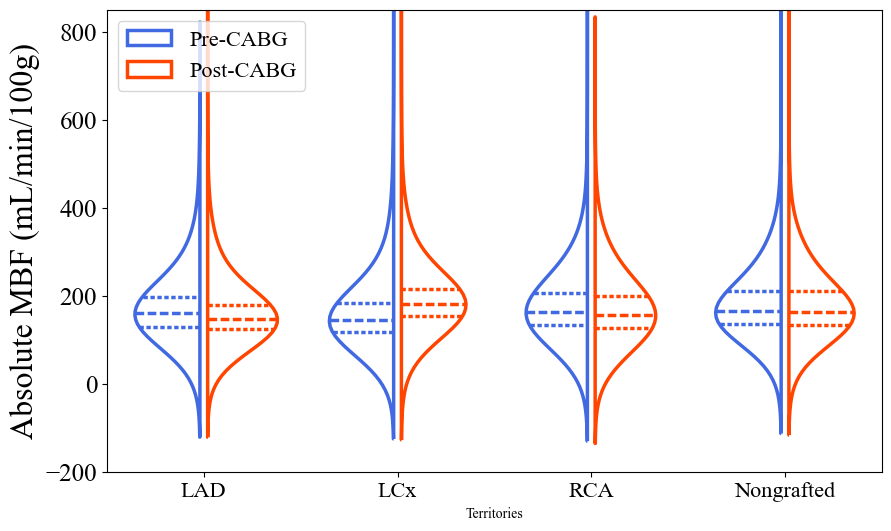

SU25


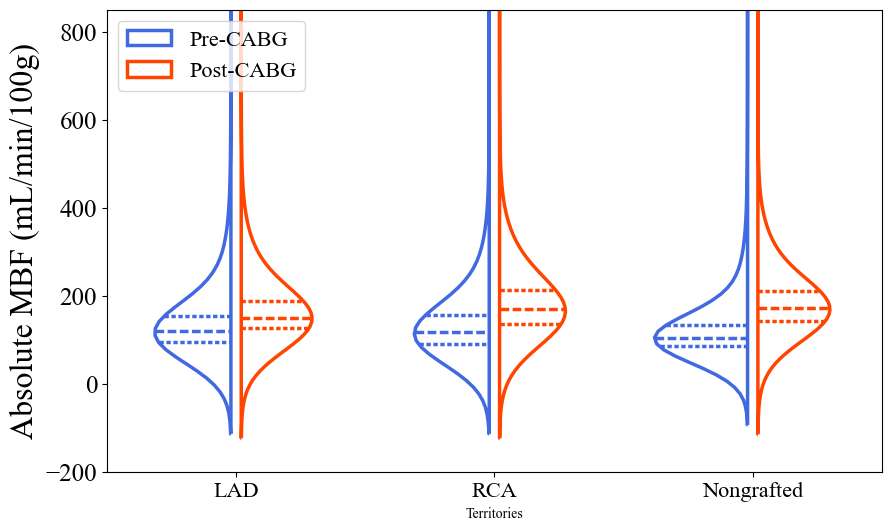

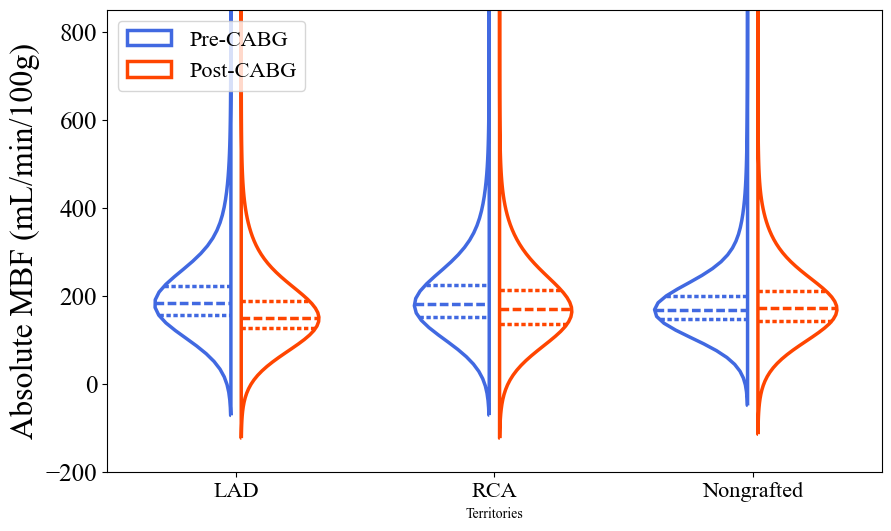

SU26


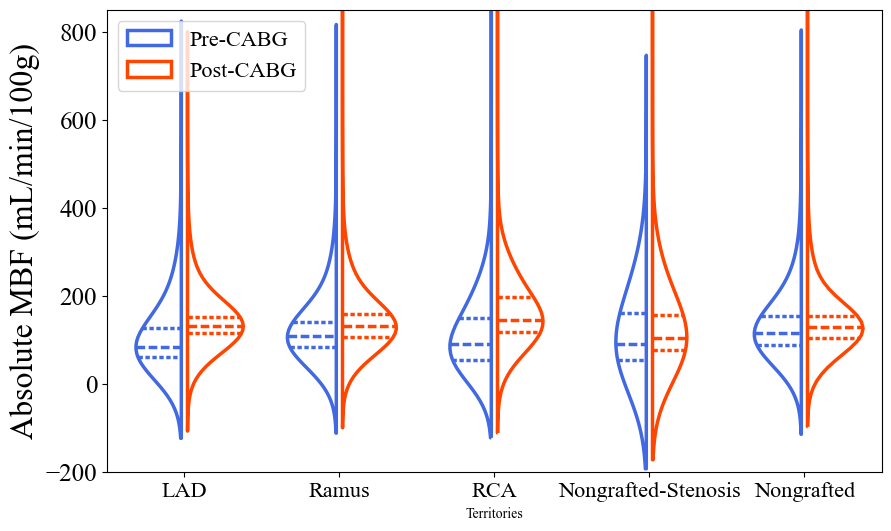

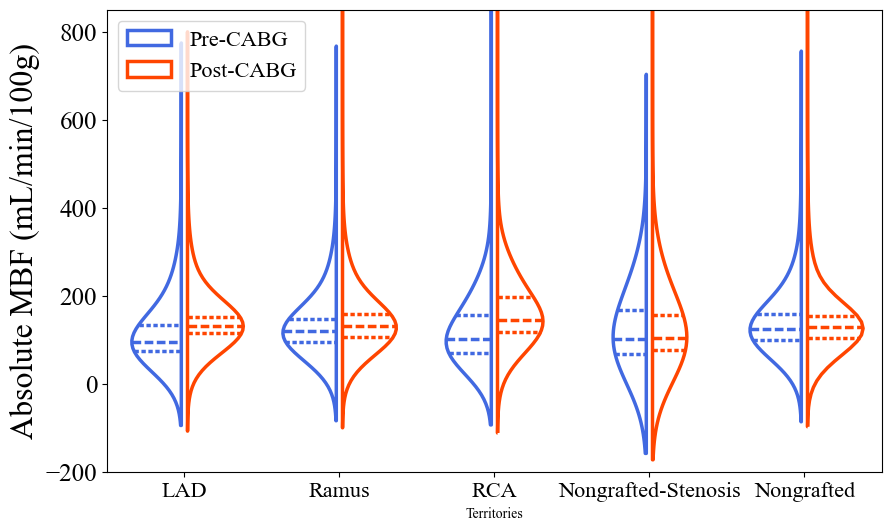

SU27


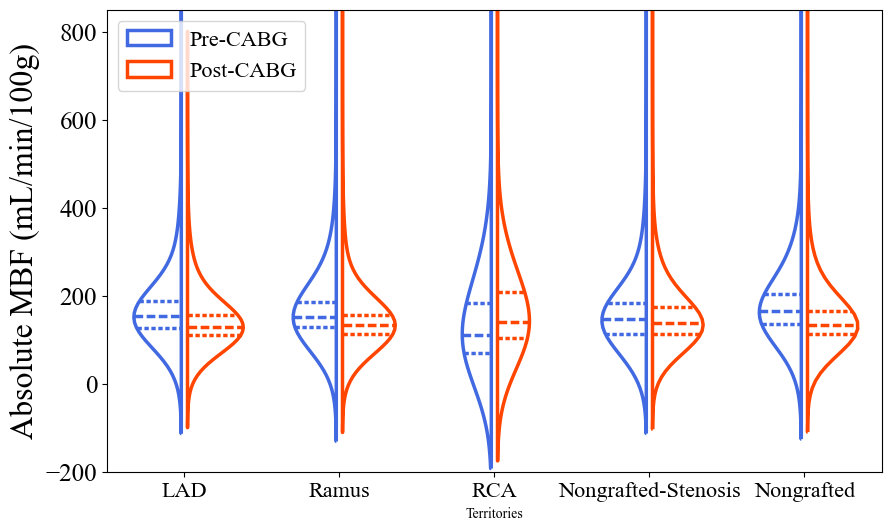

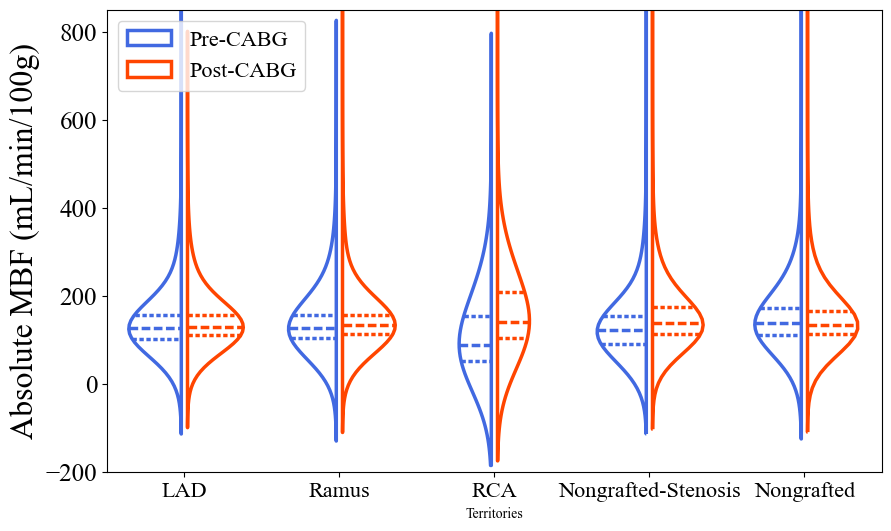

SU28


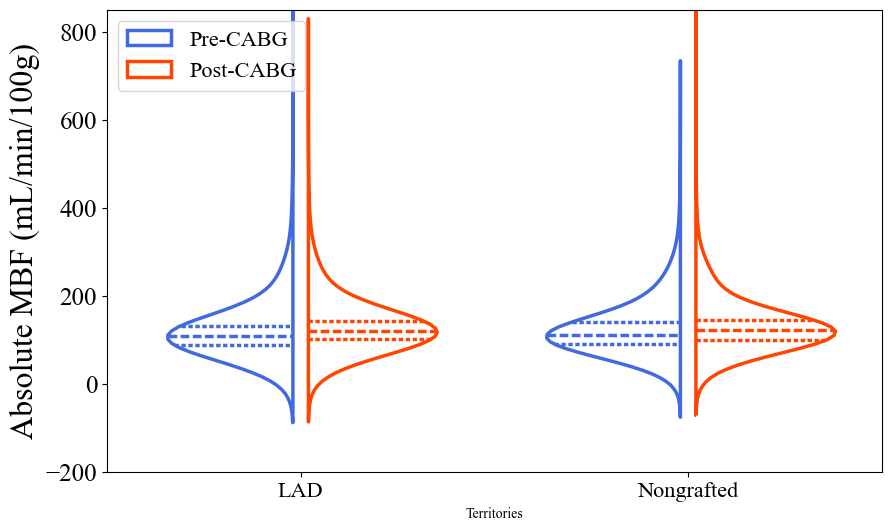

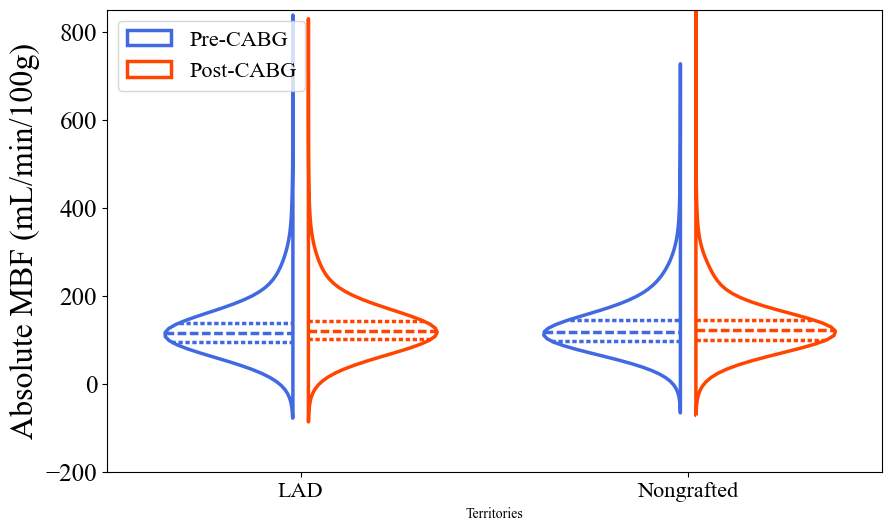

SU30


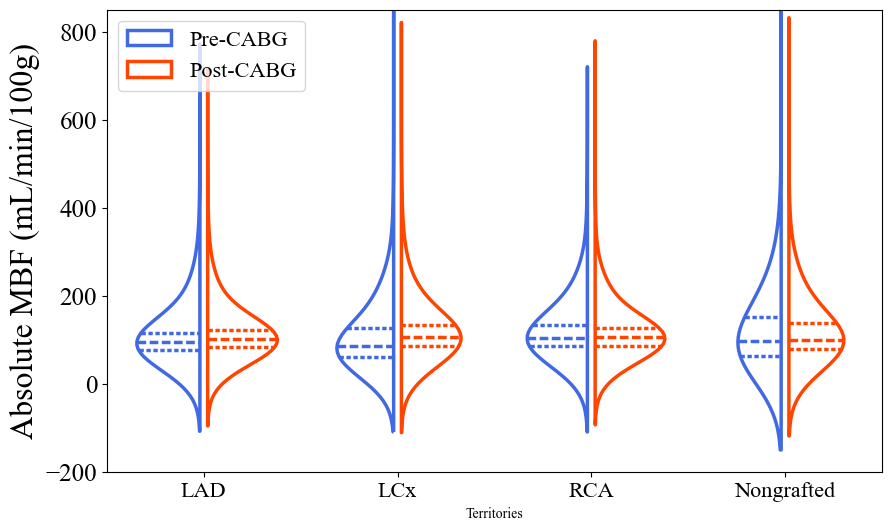

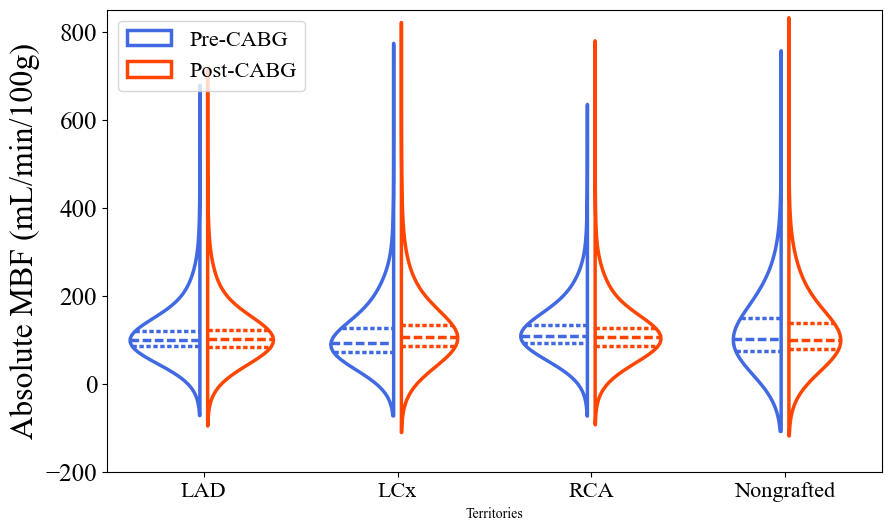

SU33


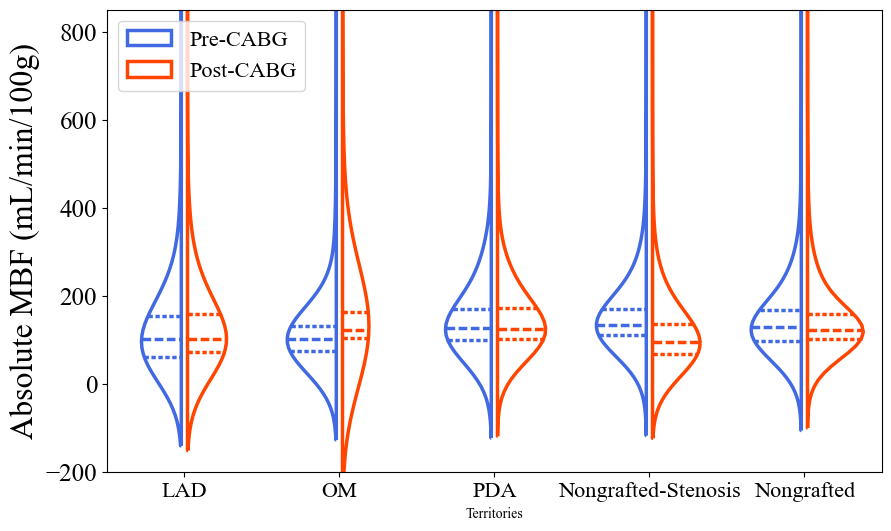

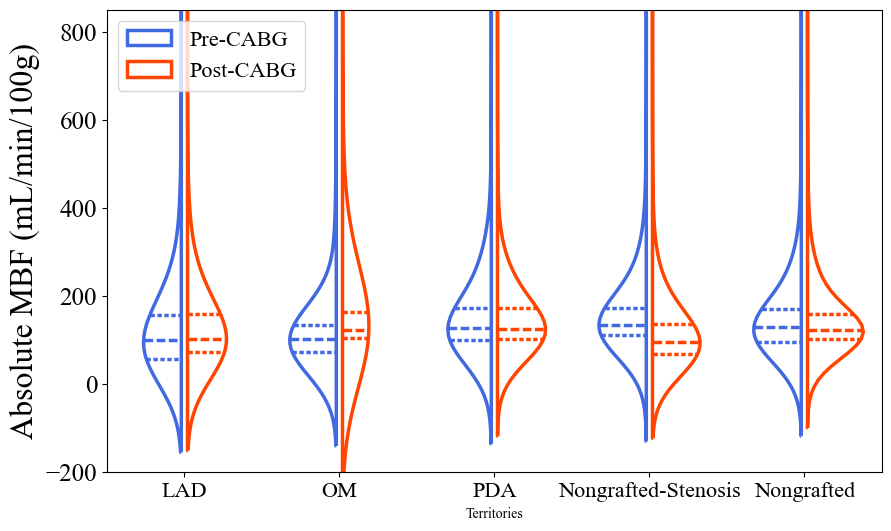

SU34


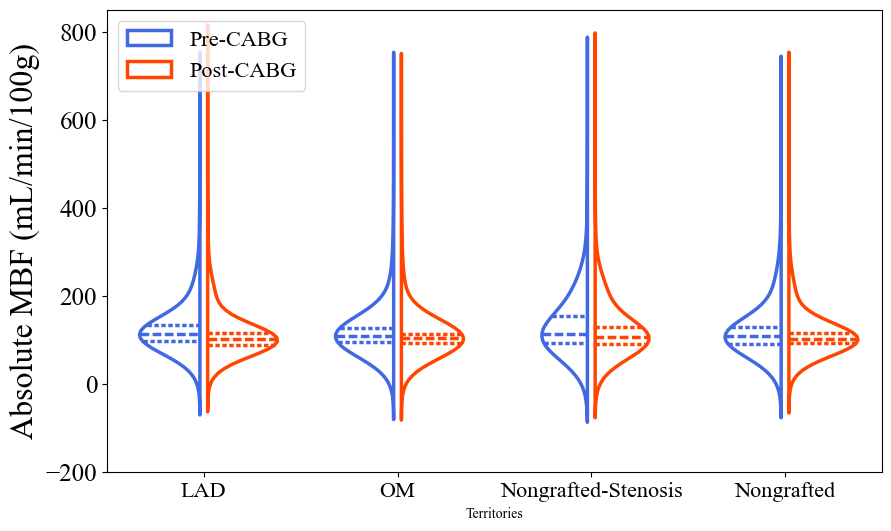

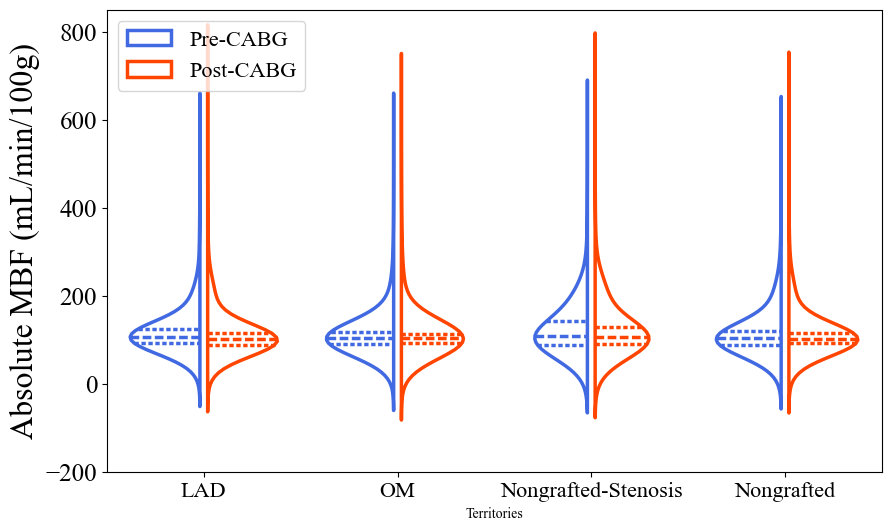

VA02


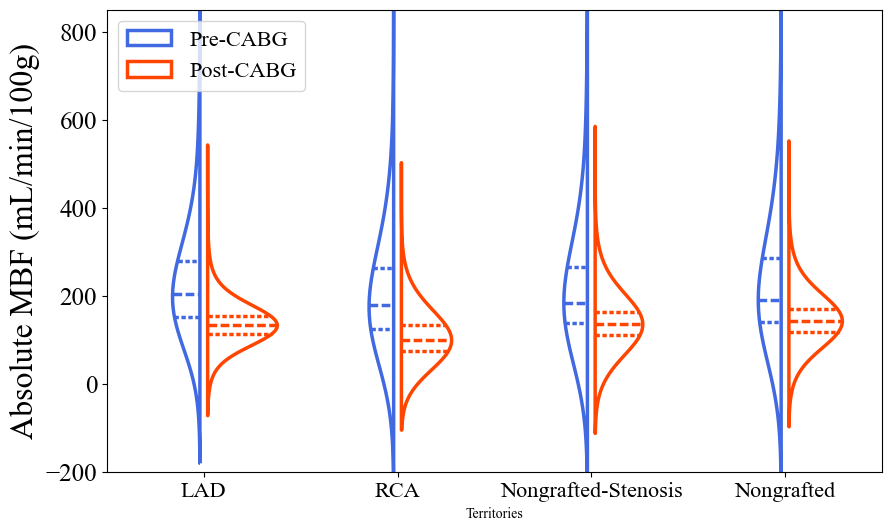

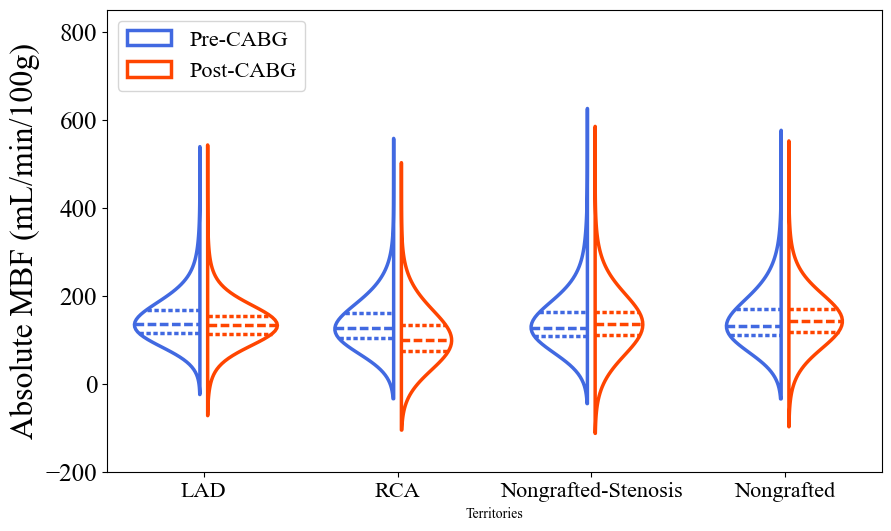

VA04


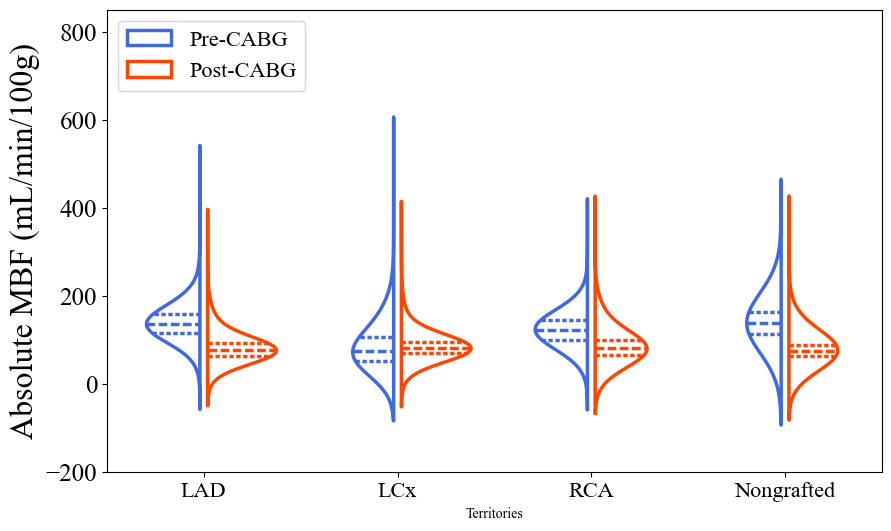

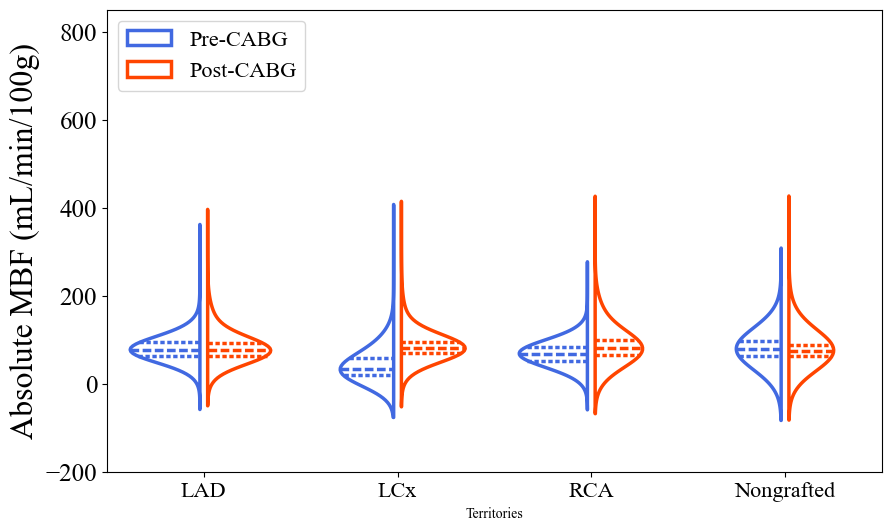

VA06


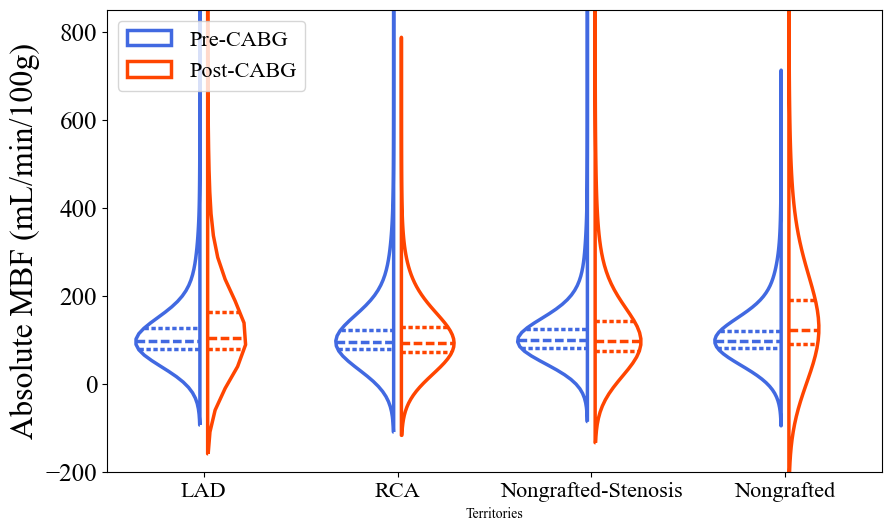

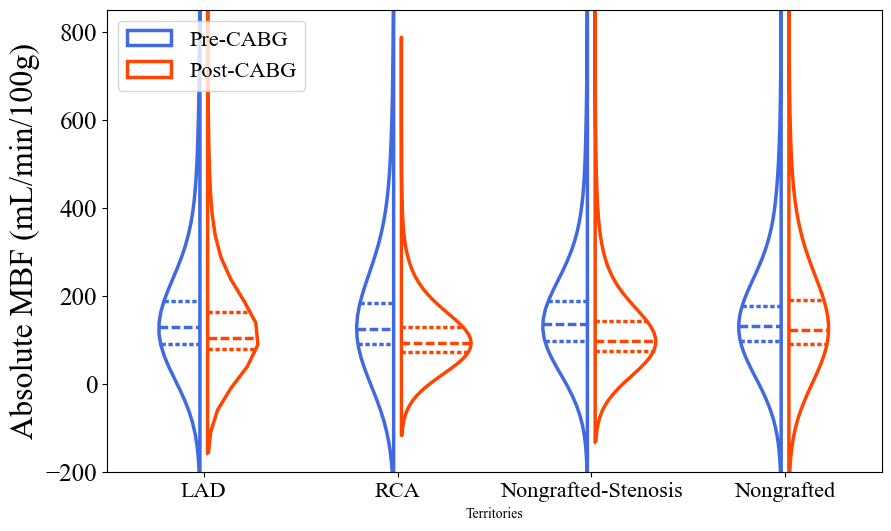

VA08


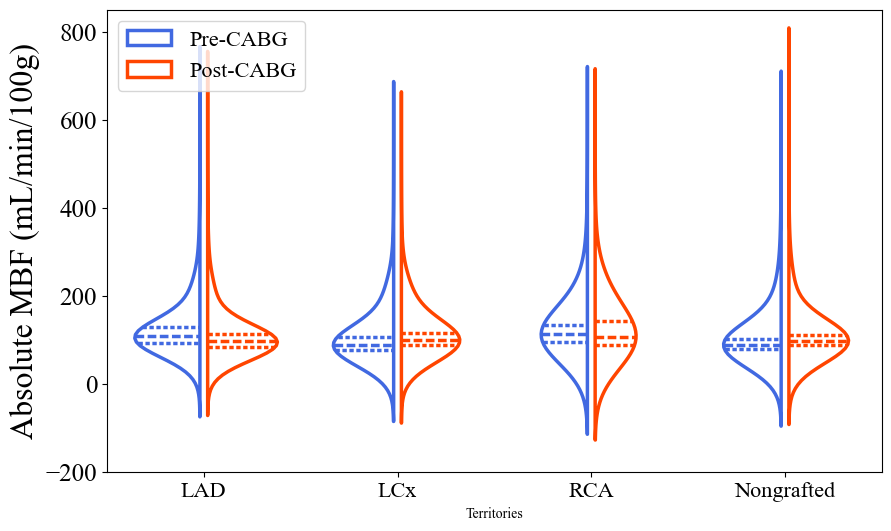

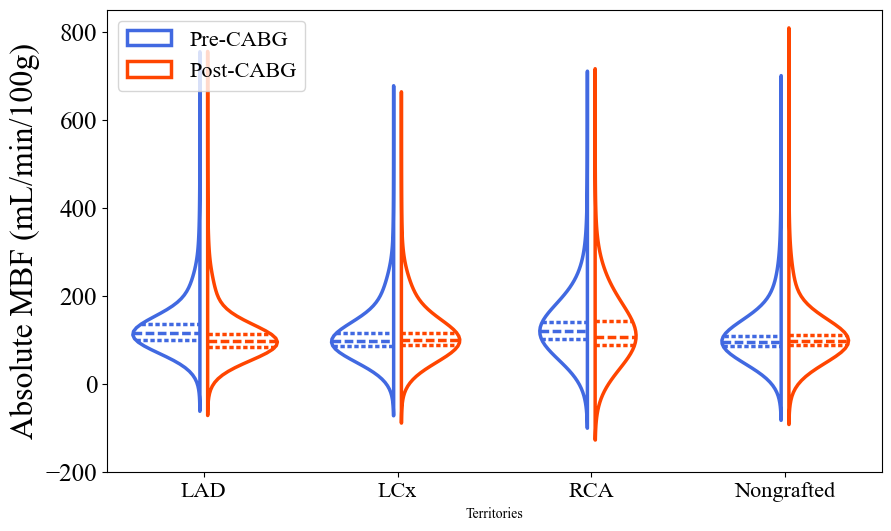

VA10


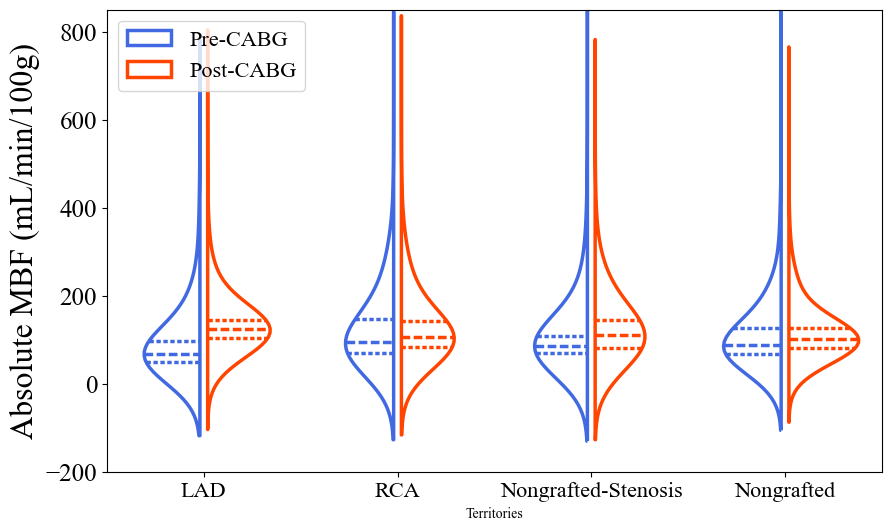

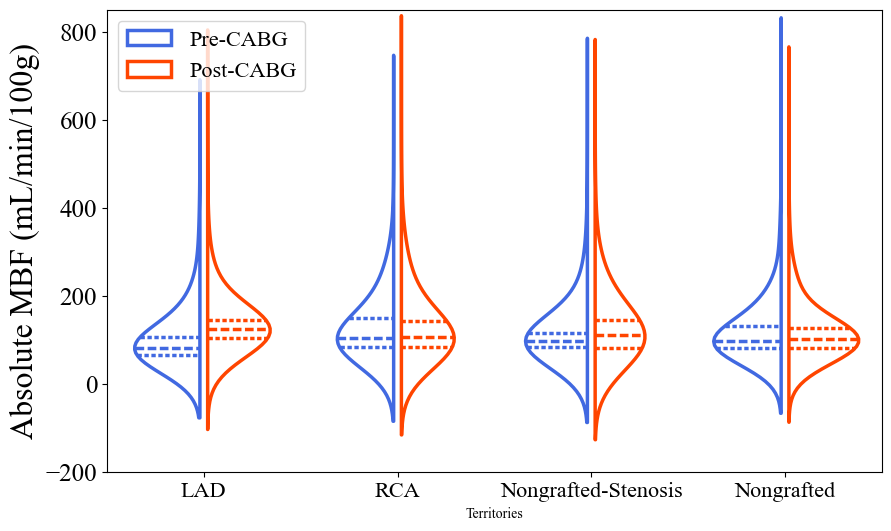

VA13


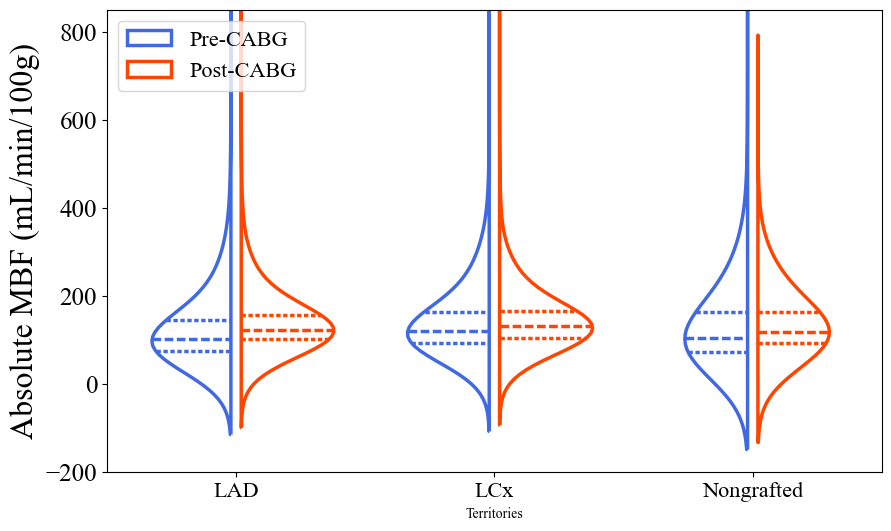

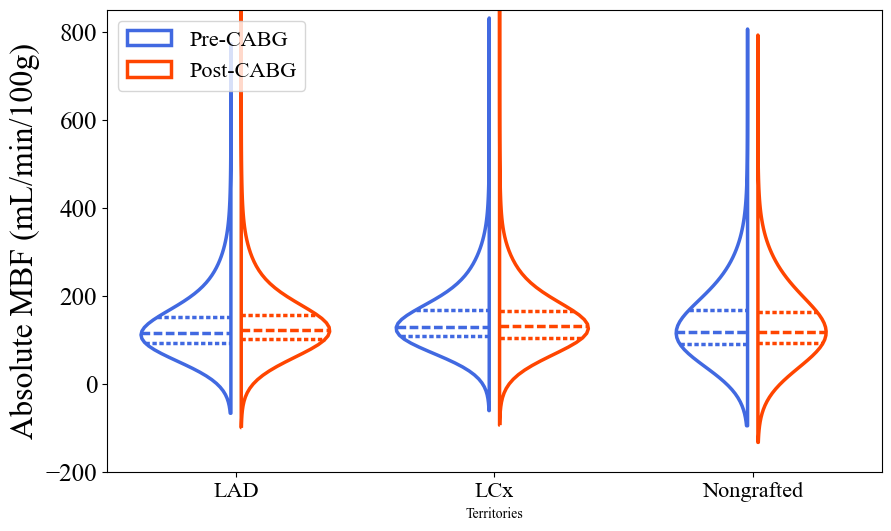

VA14


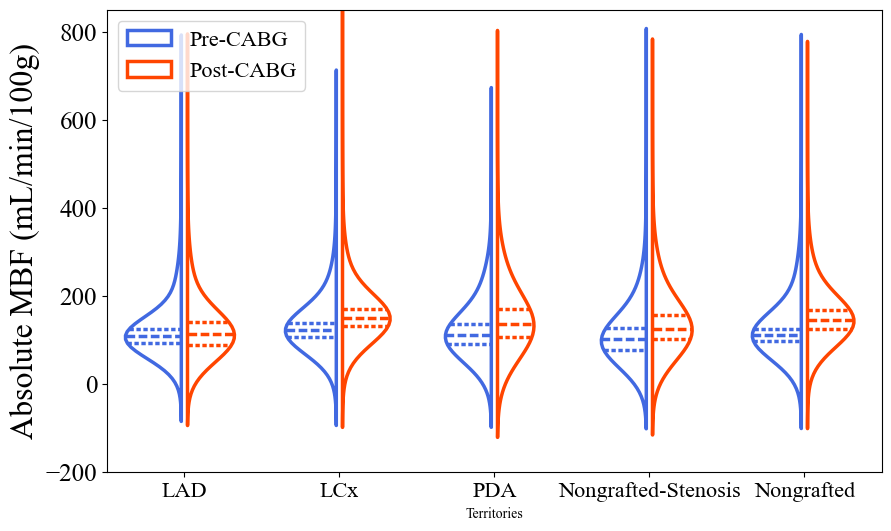

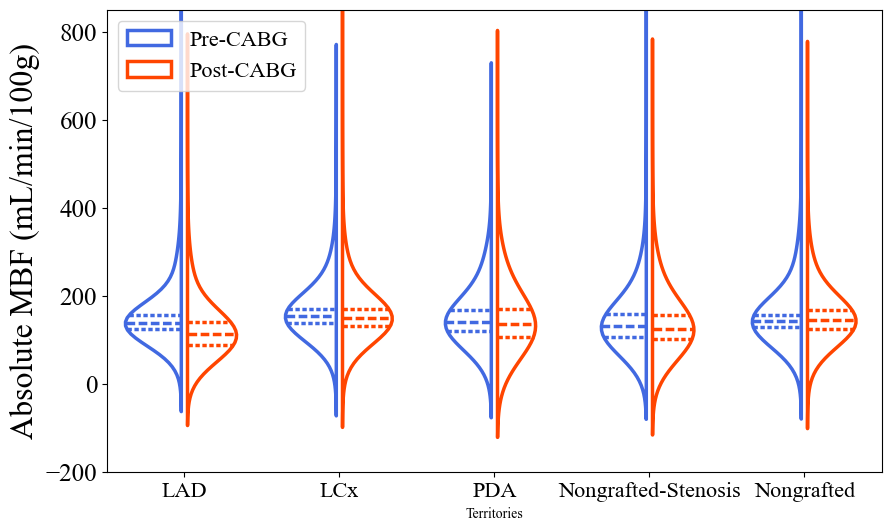

VA16


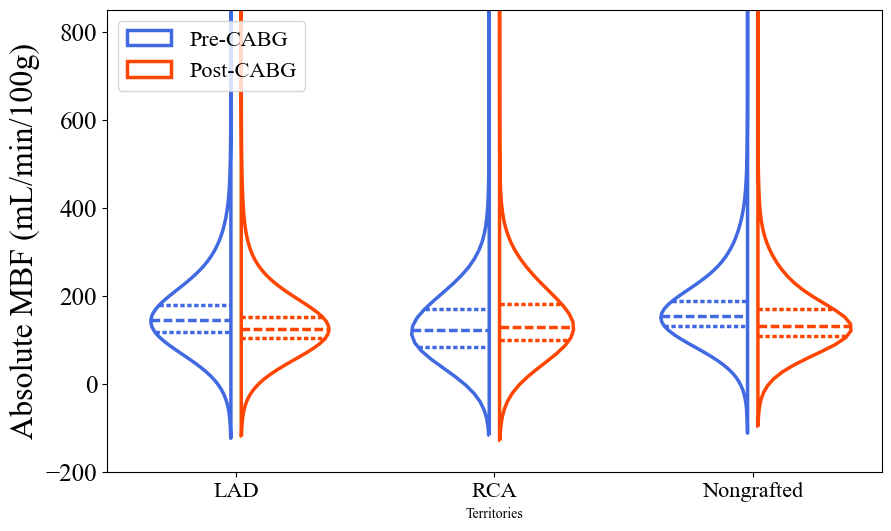

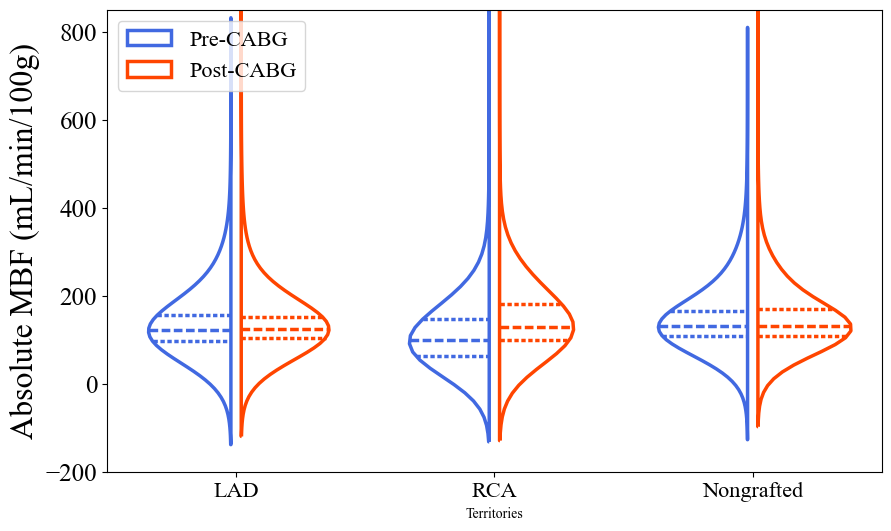

VA20


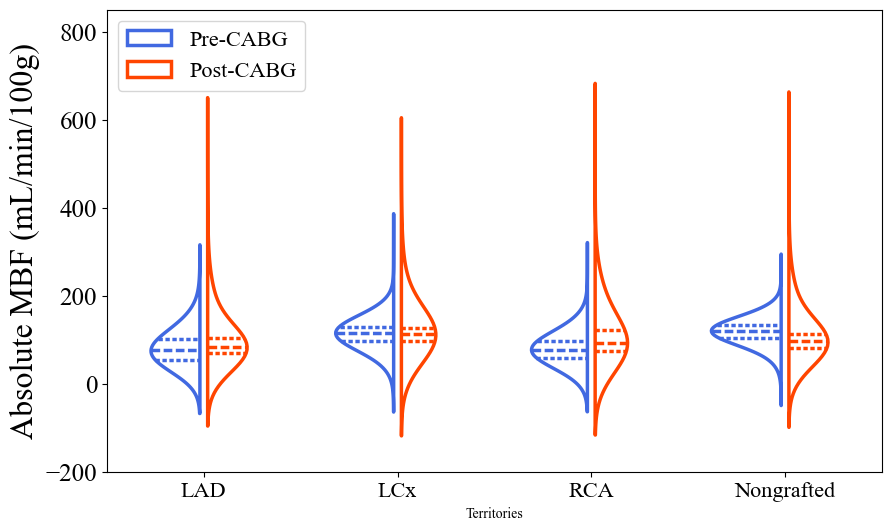

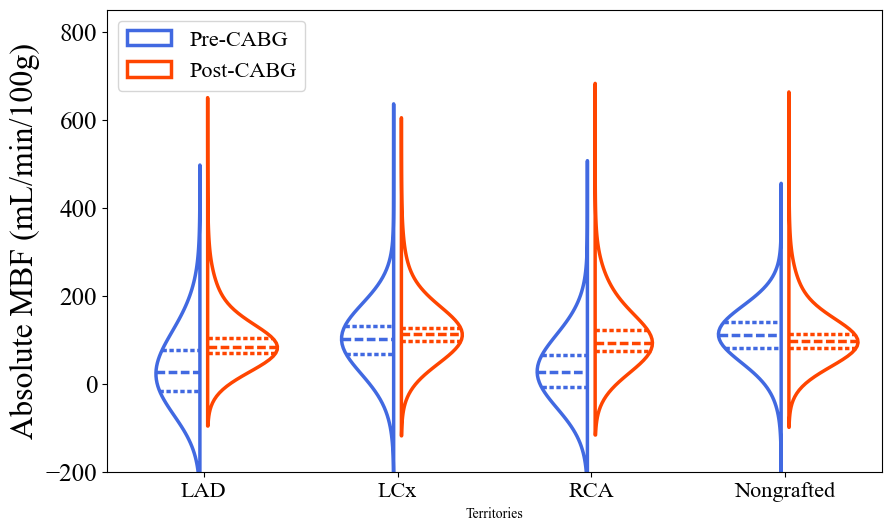

In [20]:
for patient_id in patient_ids:
    print(patient_id)
    tags = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['stenosis tag'])
    ischemia = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['is-ischemic'])
    TerritoryTags = [f'post_{tag}' for tag in tags]
    cutoff = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['cutoff'])[0]
    if cutoff == 0:
        cutoff = 142
    for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file
    MBF_Labels = ReadLabels(LabelFile, TerritoryTags)
    normalization_method = "zscore"
    for file in VTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
        elif f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
    AbsMBFData_A, IndexMBFData_A = CollectMBFData(MBF_A, MBF_Labels)
    AbsMBFData_B, IndexMBFData_B = CollectMBFData(MBF_B, MBF_Labels)
    data = pd.DataFrame({"MBF": [], "Territories": [], "Type": []})
    dataMapped = pd.DataFrame({"MBF": [], "Territories": [], "Type": []})
    t = "Nongrafted"
    array_A = AbsMBFData_A[t]
    mean_A = np.mean(array_A)
    std_A = np.std(array_A)
    array_B = AbsMBFData_B[t]
    mean_B = np.mean(array_B)
    std_B = np.std(array_B)
    MBF_A_mapped = Map3DVolume(mean_A, mean_B, std_A, std_B, MBF_A)
    WriteVTUFile(os.path.join(opath,f"{patient_id}A_MBF_Mapped.vtu"), MBF_A_mapped)
    WriteVTUFile(os.path.join(opath,f"{patient_id}B_MBF_Mapped.vtu"), MBF_B)
    #data_ = pd.DataFrame({"MBF": np.concatenate([array_A, array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
    #data = pd.concat([data, data_], ignore_index=True)
    # Mapping
    #data_mapped_ = pd.DataFrame({"MBF": np.concatenate([MapNongrafted(mean_A, mean_B, std_A, std_B, array_A), array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
    #dataMapped = pd.concat([dataMapped, data_mapped_], ignore_index=True)
    for i, t in enumerate(tags):
        array_A = AbsMBFData_A[t]
        array_B = AbsMBFData_B[t]
        data_ = pd.DataFrame({"MBF": np.concatenate([array_A, array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['Pre-CABG']*len(array_A) + ['Post-CABG']*len(array_B)})
        data = pd.concat([data, data_], ignore_index=True)
        # Mapping
        data_mapped_ = pd.DataFrame({"MBF": np.concatenate([MapNongrafted(mean_A, mean_B, std_A, std_B, array_A), array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['Pre-CABG']*len(array_A) + ['Post-CABG']*len(array_B)})
        dataMapped = pd.concat([dataMapped, data_mapped_], ignore_index=True)
    t = "Nongrafted-Stenosis"
    if t in MBF_Labels.keys():
        array_A = AbsMBFData_A[t]
        array_B = AbsMBFData_B[t]
        data_ = pd.DataFrame({"MBF": np.concatenate([array_A, array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['Pre-CABG']*len(array_A) + ['Post-CABG']*len(array_B)})
        data = pd.concat([data, data_], ignore_index=True)
        # Mapping
        data_mapped_ = pd.DataFrame({"MBF": np.concatenate([MapNongrafted(mean_A, mean_B, std_A, std_B, array_A), array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['Pre-CABG']*len(array_A) + ['Post-CABG']*len(array_B)})
        dataMapped = pd.concat([dataMapped, data_mapped_], ignore_index=True)
    t = "Nongrafted"
    array_A = AbsMBFData_A[t]
    array_B = AbsMBFData_B[t]
    data_ = pd.DataFrame({"MBF": np.concatenate([array_A, array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['Pre-CABG']*len(array_A) + ['Post-CABG']*len(array_B)})
    data = pd.concat([data, data_], ignore_index=True)
    # Mapping
    data_mapped_ = pd.DataFrame({"MBF": np.concatenate([MapNongrafted(mean_A, mean_B, std_A, std_B, array_A), array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['Pre-CABG']*len(array_A) + ['Post-CABG']*len(array_B)})
    dataMapped = pd.concat([dataMapped, data_mapped_], ignore_index=True)
    
    
    #BoxPlot(data)
    ViolinPlot(data)
    #print("--- Mapping Results:")
    ViolinPlot(dataMapped)


# Aggregating The Results

In [21]:
# Cases that didn't reach hyperaemia
Removed_Cases = ["SU25", "VA04"]

In [22]:
dataMapped = []

for patient_id in patient_ids:
    if patient_id in Removed_Cases: 
        continue
    tags = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['stenosis tag'])
    ischemia = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['is-ischemic'])
    TerritoryTags = [f'post_{tag}' for tag in tags]
    cutoff = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['cutoff'])[0]
    grafts = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['graft'])
    graft_stenosis = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['graft-stenosis'])
    if cutoff == 0:
        cutoff = 142
    for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file
    MBF_Labels = ReadLabels(LabelFile, TerritoryTags)
    normalization_method = "classic"
    for file in VTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
        elif f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
    AbsMBFData_A, IndexMBFData_A = CollectMBFData(MBF_A, MBF_Labels)
    AbsMBFData_B, IndexMBFData_B = CollectMBFData(MBF_B, MBF_Labels)

    t = "Nongrafted"
    array_A = AbsMBFData_A[t]
    mean_A = np.mean(array_A)
    std_A = np.std(array_A)
    array_B = AbsMBFData_B[t]
    mean_B = np.mean(array_B)
    std_B = np.std(array_B)

    for i, t in enumerate(tags):
        AbsMBFData_A_mapped = MapNongrafted(mean_A, mean_B, std_A, std_B, AbsMBFData_A[t])
        data_ = {"patient_id": patient_id, "tag": t, "graft_type": grafts[i], "is_ischemic": ischemia[i], "ischemic_grade":0, "graft_stenosis": graft_stenosis[i], "absMBF_A": AbsMBFData_A_mapped, "absMBF_B": AbsMBFData_B[t], "rawMBF_A": AbsMBFData_A[t]}
        dataMapped.append(data_)
    t = "Nongrafted-Stenosis"
    if t in MBF_Labels.keys():
        AbsMBFData_A_mapped = MapNongrafted(mean_A, mean_B, std_A, std_B, AbsMBFData_A[t])
        data_ = {"patient_id": patient_id, "tag": t, "graft_type": None, "is_ischemic": False, "ischemic_grade":0, "graft_stenosis": 0, "absMBF_A": AbsMBFData_A_mapped, "absMBF_B": AbsMBFData_B[t], "rawMBF_A": AbsMBFData_A[t]}
        dataMapped.append(data_)
    t = "Nongrafted"
    AbsMBFData_A_mapped = MapNongrafted(mean_A, mean_B, std_A, std_B, AbsMBFData_A[t])
    data_ = {"patient_id": patient_id, "tag": t, "graft_type": None, "is_ischemic": False, "ischemic_grade":0, "graft_stenosis": 0, "absMBF_A": AbsMBFData_A_mapped, "absMBF_B": AbsMBFData_B[t], "rawMBF_A": AbsMBFData_A[t]}
    dataMapped.append(data_)

# --- Post-process after collecting all data: Measuring 30% drop in ischemic regions
non_ischemic_values = np.concatenate([item["absMBF_A"] for item in dataMapped if item["is_ischemic"] == False])
threshold1 = 0.9 * np.median(non_ischemic_values)  # 10% drop
threshold2 = 0.8 * np.median(non_ischemic_values)  # 20% drop
threshold3 = 0.7 * np.median(non_ischemic_values)  # 30% drop

count_ischemic = 0
count_10 = 0
count_20 = 0
count_30 = 0


for item in dataMapped:
    tag_ = item["tag"]
    if item["is_ischemic"]:
        mbf_median = np.median(item["absMBF_A"])
        if mbf_median > threshold1:
            item["ischemic_grade"] = 0
            item["is_ischemic"] = False

        elif threshold2 < mbf_median <= threshold1:
            item["ischemic_grade"] = 1
            item["is_ischemic"] = True
            print("10-20% drop", item["patient_id"], item["tag"])
            count_ischemic += 1
            count_10 += 1

        elif threshold3 < mbf_median <= threshold2:
            item["ischemic_grade"] = 2
            item["is_ischemic"] = True
            print("20-30% drop", item["patient_id"], item["tag"])
            count_ischemic += 1
            count_20 += 1

        else:
            item["ischemic_grade"] = 3
            item["is_ischemic"] = True
            print(">30% drop", item["patient_id"], item["tag"])
            count_ischemic += 1
            count_30 += 1


df = pd.DataFrame(dataMapped)


>30% drop SU03 Diag
>30% drop SU03 RCA
10-20% drop SU04 LCx
10-20% drop SU07 RCA
20-30% drop SU10 LAD
>30% drop SU11 LCx
>30% drop SU13 LAD
10-20% drop SU13 RCA
20-30% drop SU14 RCA
10-20% drop SU23 Diag
20-30% drop SU26 LAD
10-20% drop SU26 RCA
20-30% drop SU27 RCA
20-30% drop SU30 LCx
20-30% drop SU33 LAD
10-20% drop SU33 OM
10-20% drop SU34 LAD
10-20% drop SU34 OM
20-30% drop VA08 LCx
>30% drop VA10 LAD
10-20% drop VA10 RCA
20-30% drop VA16 RCA
>30% drop VA20 LAD
>30% drop VA20 RCA


In [23]:
print(count_ischemic)
print(count_10)
print(count_20)
print(count_30)

24
9
8
7


In [24]:
df

patient_id                  tag graft_type  is_ischemic  ischemic_grade  \
0         SU03                 Diag     Radial         True               3   
1         SU03                  LAD       LIMA        False               0   
2         SU03                  RCA        SVG         True               3   
3         SU03  Nongrafted-Stenosis       None        False               0   
4         SU03           Nongrafted       None        False               0   
..         ...                  ...        ...          ...             ...   
103       VA16           Nongrafted       None        False               0   
104       VA20                  LAD       LIMA         True               3   
105       VA20                  LCx        SVG        False               0   
106       VA20                  RCA        SVG         True               3   
107       VA20           Nongrafted       None        False               0   

     graft_stenosis                                           absMBF_A  \
0                 0  [-1.5839397276108684, 0.1866096736175109, -6.8...   
1                 0  [132.9778147657465, 134.74836416697488, 134.74...   
2                 0  [125.89561716083294, 118.8134195559194, 109.96...   
3                 0  [28.515400093271708, 40.909245901870406, 53.30...   
4                 0  [125.89561716083294, 125.89561716083294, 122.3...   
..              ...                                                ...   
103               0  [35.47398335909408, 9.219621416332302, 19.9158...   
104               0  [-59.00010222006746, -94.40367607944468, -88.5...   
105               0  [31.47569764278542, 11.80704549868696, -1.9610...   
106               0  [125.88522793445799, 125.88522793445799, 125.8...   
107               0  [149.48761050737613, 145.55388007855646, 169.1...   

                                              absMBF_B  \
0    [162.0, 155.0, 187.0, 179.0, 168.0, 162.0, 159...   
1    [158.0, 158.0, 154.0, 149.0, 143.0, 148.0, 151...   
2    [154.0, 159.0, 175.0, 91.0, 93.0, 96.0, 229.0,...   
3    [74.0, 74.0, 75.0, 79.0, 86.0, 94.0, 103.0, 11...   
4    [111.0, 123.0, 139.0, 126.0, 107.0, 106.0, 110...   
..                                                 ...   
103  [201.0, 204.0, 288.0, 285.0, 128.0, 134.0, 386...   
104  [221.0, 145.0, 185.0, 129.0, 33.0, 80.0, 9.0, ...   
105  [42.0, 41.0, 42.0, 45.0, 46.0, 34.0, 29.0, 46....   
106  [6.0, 8.0, 15.0, 5.0, 90.0, 92.0, 88.0, 88.0, ...   
107  [250.0, 237.0, 64.0, 58.0, 51.0, 429.0, 257.0,...   

                                              rawMBF_A  
0    [39.0, 40.0, 36.0, 38.0, 39.0, 40.0, 37.0, 35....  
1    [115.0, 116.0, 116.0, 117.0, 116.0, 114.0, 117...  
2    [111.0, 107.0, 102.0, 78.0, 95.0, 78.0, 88.0, ...  
3    [56.0, 63.0, 70.0, 79.0, 88.0, 96.0, 105.0, 11...  
4    [111.0, 111.0, 109.0, 109.0, 109.0, 109.0, 109...  
..                                                 ...  
103  [55.0, 28.0, 39.0, 15.0, 52.0, 75.0, 38.0, 58....  
104  [33.0, 15.0, 18.0, 30.0, 27.0, 15.0, 19.0, 30....  
105  [79.0, 69.0, 62.0, 59.0, 58.0, 60.0, 62.0, 64....  
106  [127.0, 127.0, 127.0, 123.0, 99.0, 94.0, 101.0...  
107  [139.0, 137.0, 149.0, 149.0, 149.0, 145.0, 141...  

[108 rows x 9 columns]

### Plot based on the presence of ischemia

In [25]:
print("TerritoryTag", "Median", "IQR", "Mean", "std")
mbf_ischemic_A = np.concatenate(df[df['is_ischemic'] == True]['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_ischemic_A, [25, 50, 75])
average = np.mean(mbf_ischemic_A)
std = np.std(mbf_ischemic_A)
print("ischemic_grafted_A", q2, q3-q1, average, std)

mbf_ischemic_B = np.concatenate(df[df['is_ischemic'] == True]['absMBF_B'].values)
q1, q2, q3 = np.percentile(mbf_ischemic_B, [25, 50, 75])
average = np.mean(mbf_ischemic_B)
std = np.std(mbf_ischemic_B)
print("ischemic_grafted_B",q2, q3-q1, average, std)

mbf_nonischemic_A = np.concatenate(df[(df['is_ischemic'] == False) & (df['tag'] != 'Nongrafted') & (df['tag'] != "Nongrafted-Stenosis")]['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_nonischemic_A, [25, 50, 75])
average = np.mean(mbf_nonischemic_A)
std = np.std(mbf_nonischemic_A)
print("nonischemic_grafted_A", q2, q3-q1, average, std)

mbf_nonischemic_B = np.concatenate(df[(df['is_ischemic'] == False) & (df['tag'] != 'Nongrafted') & (df['tag'] != "Nongrafted-Stenosis")]['absMBF_B'].values)
q1, q2, q3 = np.percentile(mbf_nonischemic_B, [25, 50, 75])
average = np.mean(mbf_nonischemic_B)
std = np.std(mbf_nonischemic_B)
print("nonischemic_grafted_B", q2, q3-q1, average, std)

mbf_st_nongrafted_A = np.concatenate(df[df['tag'] == 'Nongrafted-Stenosis']['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_st_nongrafted_A, [25, 50, 75])
average = np.mean(mbf_st_nongrafted_A)
std = np.std(mbf_st_nongrafted_A)
print("stenosed_nongrafted_A", q2, q3-q1, average, std)

mbf_st_nongrafted_B = np.concatenate(df[df['tag'] == 'Nongrafted-Stenosis']['absMBF_B'].values)
q1, q2, q3 = np.percentile(mbf_st_nongrafted_B, [25, 50, 75])
average = np.mean(mbf_st_nongrafted_B)
std = np.std(mbf_st_nongrafted_B)
print("stenosed_nongrafted_B", q2, q3-q1, average, std)

mbf_nongrafted_A = np.concatenate(df[df['tag'] == 'Nongrafted']['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_nongrafted_A, [25, 50, 75])
average = np.mean(mbf_nongrafted_A)
std = np.std(mbf_nongrafted_A)
print("nongrafted_A", q2, q3-q1, average, std)

mbf_nongrafted_B = np.concatenate(df[df['tag'] == 'Nongrafted']['absMBF_B'].values)
q1, q2, q3 = np.percentile(mbf_nongrafted_B, [25, 50, 75])
average = np.mean(mbf_nongrafted_B)
std = np.std(mbf_nongrafted_B)
print("nongrafted_B", q2, q3-q1, average, std)


TerritoryTag Median IQR Mean std
ischemic_grafted_A 94.17270394840605 59.459332457576025 101.26238012654673 60.99644154848872
ischemic_grafted_B 110.0 60.0 124.45680806062674 59.42691825545726
nonischemic_grafted_A 127.85044204658924 63.40178813909499 140.03519390294906 65.60793348949424
nonischemic_grafted_B 128.0 67.0 138.93487997538304 63.27795993478018
stenosed_nongrafted_A 122.76803993254683 67.34055321147369 137.36475026298717 73.27599714637832
stenosed_nongrafted_B 115.0 66.0 129.94399028291457 64.90412926168254
nongrafted_A 124.89891033980983 66.2788946556721 137.8729028173983 63.46179918341257
nongrafted_B 124.0 61.0 137.5774016764465 63.52557268903434


In [53]:
df_A = pd.DataFrame({
    'MBF': np.concatenate([mbf_ischemic_A, mbf_nonischemic_A, mbf_st_nongrafted_A, mbf_nongrafted_A]),
    'Territory':
             ['$MBF_{ref}$<0.9\nGrafted\nStenosis>50%'] * len(mbf_ischemic_A) + 
             ['$MBF_{ref}$>0.9\nGrafted\nStenosis>50%'] * len(mbf_nonischemic_A) + 
             ['$MBF_{ref}$>0.9\nNot Grafted\nStenosis>50%'] * len(mbf_st_nongrafted_A) +
             ['$MBF_{ref}$>0.9\nNot Grafted\nStenosis<50%'] * len(mbf_nongrafted_A),
    'Type': ['Pre-CABG'] * (len(mbf_ischemic_A) + len(mbf_nonischemic_A) + len(mbf_st_nongrafted_A) + len(mbf_nongrafted_A))
})

df_B = pd.DataFrame({
    'MBF': np.concatenate([mbf_ischemic_B, mbf_nonischemic_B, mbf_st_nongrafted_B, mbf_nongrafted_B]),
    'Territory':
             ['$MBF_{ref}$<0.9\nGrafted\nStenosis>50%'] * len(mbf_ischemic_B) + 
             ['$MBF_{ref}$>0.9\nGrafted\nStenosis>50%'] * len(mbf_nonischemic_B) + 
             ['$MBF_{ref}$>0.9\nNot Grafted\nStenosis>50%'] * len(mbf_st_nongrafted_B) +
             ['$MBF_{ref}$>0.9\nNot Grafted\nStenosis<50%'] * len(mbf_nongrafted_B),
    'Type': ['Post-CABG'] * (len(mbf_ischemic_B) + len(mbf_nonischemic_B) + len(mbf_st_nongrafted_B) + len(mbf_nongrafted_B))
})

df_long = pd.concat([df_A, df_B], ignore_index=True)

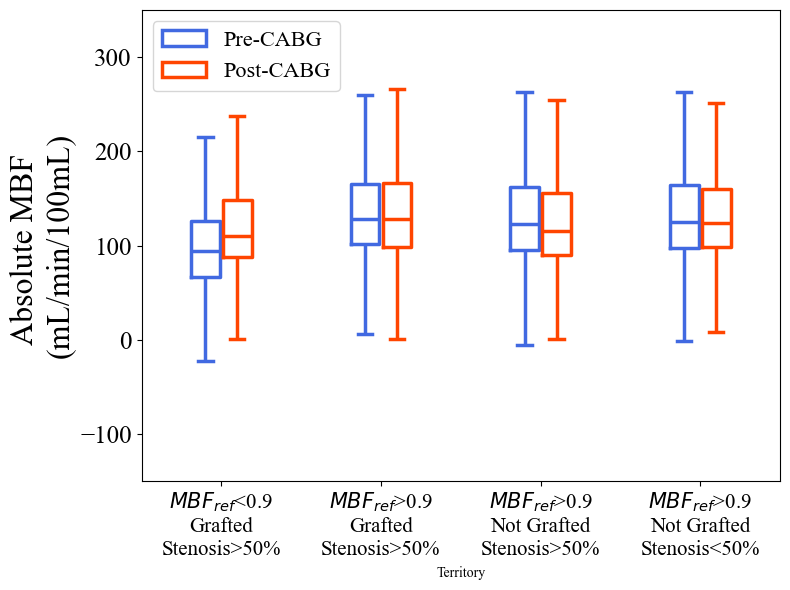

In [55]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='Territory', y='MBF', hue='Type', data= df_long, showfliers=False, width = 0.4,  linewidth=2.5, fill= False, gap=.1, palette={'Pre-CABG':color1, 'Post-CABG':color2})

ax.set_ylabel("Absolute MBF \n(mL/min/100mL)", fontsize = 23)
ax.tick_params(axis='x', rotation=0, labelsize=18)
ax.legend(loc = 'upper left', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=18)
plt.ylim(-150,350)
plt.tight_layout()
plt.show()

### Statistical Test

In [31]:
median_mbf_ischemic_A = []
median_mbf_ischemic_B = []

for _, row in df[df['is_ischemic'] == True].iterrows():
    median_mbf_ischemic_A.append(np.median(row['absMBF_A']))
    median_mbf_ischemic_B.append(np.median(row['absMBF_B']))

p_value_ischemic = WilcoxonTest(median_mbf_ischemic_A, median_mbf_ischemic_B)

Wilcoxon test statistics:  12.0
p-value:  8.344650268554688e-06
number of datapoints: 24
Reject the null hypothesis: There is a significant difference between the two samples.


In [32]:
median_mbf_nonischemic_A = []
median_mbf_nonischemic_B = []

for _, row in df[(df['is_ischemic'] == False) & (df['tag'] != 'Nongrafted') & (df['tag'] != "Nongrafted-Stenosis")].iterrows():
    median_mbf_nonischemic_A.append(np.median(row['absMBF_A']))
    median_mbf_nonischemic_B.append(np.median(row['absMBF_B']))

p_value_non_ischemic = WilcoxonTest(median_mbf_nonischemic_A, median_mbf_nonischemic_B)

Wilcoxon test statistics:  411.0
p-value:  0.16013347692305047
number of datapoints: 46
Fail to reject the null hypothesis: There is no significant difference between the two samples.


In [33]:
median_mbf_stng_A = []
median_mbf_stng_B = []

for _, row in df[df['tag'] == 'Nongrafted-Stenosis'].iterrows():
    median_mbf_stng_A.append(np.median(row['absMBF_A']))
    median_mbf_stng_B.append(np.median(row['absMBF_B']))

p_value_nongrafted_stenosis = WilcoxonTest(median_mbf_stng_A, median_mbf_stng_B)

Wilcoxon test statistics:  29.0
p-value:  0.4697265625
number of datapoints: 12
Fail to reject the null hypothesis: There is no significant difference between the two samples.


In [34]:
median_mbf_ng_A = []
median_mbf_ng_B = []

for _, row in df[df['tag'] == 'Nongrafted'].iterrows():
    median_mbf_ng_A.append(np.median(row['absMBF_A']))
    median_mbf_ng_B.append(np.median(row['absMBF_B']))

p_value_nongrafted = WilcoxonTest(median_mbf_ng_A, median_mbf_ng_B)

Wilcoxon test statistics:  172.0
p-value:  0.9402996003627777
number of datapoints: 26
Fail to reject the null hypothesis: There is no significant difference between the two samples.


### Plot based on the severity ischemia

In [43]:
print("TerritoryTag", "Median", "IQR", "Mean", "std")
mbf_ischemic10_A = np.concatenate(df[df['ischemic_grade'] == 1]['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_ischemic10_A, [25, 50, 75])
average = np.mean(mbf_ischemic10_A)
std = np.std(mbf_ischemic10_A)
print("ischemic_grafted10_A", q2, q3-q1, average, std)

mbf_ischemic10_B = np.concatenate(df[df['ischemic_grade'] == 1]['absMBF_B'].values)
q1, q2, q3 = np.percentile(mbf_ischemic10_B, [25, 50, 75])
average = np.mean(mbf_ischemic10_B)
std = np.std(mbf_ischemic10_B)
print("ischemic_grafted10_B",q2, q3-q1, average, std)

mbf_ischemic20_A = np.concatenate(df[df['ischemic_grade'] == 2]['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_ischemic20_A, [25, 50, 75])
average = np.mean(mbf_ischemic20_A)
std = np.std(mbf_ischemic20_A)
print("ischemic_grafted20_A", q2, q3-q1, average, std)

mbf_ischemic20_B = np.concatenate(df[df['ischemic_grade'] == 2]['absMBF_B'].values)
q1, q2, q3 = np.percentile(mbf_ischemic20_B, [25, 50, 75])
average = np.mean(mbf_ischemic20_B)
std = np.std(mbf_ischemic20_B)
print("ischemic_grafted20_B",q2, q3-q1, average, std)

mbf_ischemic30_A = np.concatenate(df[df['ischemic_grade'] == 3]['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_ischemic30_A, [25, 50, 75])
average = np.mean(mbf_ischemic30_A)
std = np.std(mbf_ischemic30_A)
print("ischemic_grafted30_A", q2, q3-q1, average, std)

mbf_ischemic30_B = np.concatenate(df[df['ischemic_grade'] == 3]['absMBF_B'].values)
q1, q2, q3 = np.percentile(mbf_ischemic30_B, [25, 50, 75])
average = np.mean(mbf_ischemic30_B)
std = np.std(mbf_ischemic30_B)
print("ischemic_grafted30_B",q2, q3-q1, average, std)

mbf_nonischemic_A = np.concatenate(df[(df['ischemic_grade'] == 0) & (df['tag'] != 'Nongrafted') & (df['tag'] != "Nongrafted-Stenosis")]['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_nonischemic_A, [25, 50, 75])
average = np.mean(mbf_nonischemic_A)
std = np.std(mbf_nonischemic_A)
print("nonischemic_grafted_A", q2, q3-q1, average, std)

index_mbf_nonischemic_B = np.concatenate(df[(df['ischemic_grade'] == 0) & (df['tag'] != 'Nongrafted') & (df['tag'] != "Nongrafted-Stenosis")]['absMBF_B'].values)
q1, q2, q3 = np.percentile(index_mbf_nonischemic_B, [25, 50, 75])
average = np.mean(index_mbf_nonischemic_B)
std = np.std(index_mbf_nonischemic_B)
print("nonischemic_grafted_B", q2, q3-q1, average, std)


TerritoryTag Median IQR Mean std
ischemic_grafted10_A 104.54270210656857 48.91144561300493 113.24273332203134 52.56084033835552
ischemic_grafted10_B 111.0 57.0 127.58076700438161 61.18741612743438
ischemic_grafted20_A 94.98957690782387 62.93102478757501 110.96031728429004 63.41634731439402
ischemic_grafted20_B 103.0 63.0 120.5729819267817 61.48820102228037
ischemic_grafted30_A 66.13777536011723 66.92989526795687 68.96860701439279 57.117207210667736
ischemic_grafted30_B 116.0 60.0 125.46630941004541 52.529188113115296
nonischemic_grafted_A 127.85044204658924 63.40178813909499 140.03519390294906 65.60793348949424
nonischemic_grafted_B 128.0 67.0 138.93487997538304 63.27795993478018


In [56]:
# Create a DataFrame with each part
df_A = pd.DataFrame({
    'MBF': np.concatenate([mbf_ischemic30_A, mbf_ischemic20_A, mbf_ischemic10_A, mbf_nonischemic_A]),
    'Territory': ['$MBF_{ref}$<0.7\nGrafted\nStenosis>50%'] * len(mbf_ischemic30_A) +
             ['0.7<$MBF_{ref}$<0.8\nGrafted\nStenosis>50%'] * len(mbf_ischemic20_A) +
             ['0.8<$MBF_{ref}$<0.9\nGrafted\nStenosis>50%'] * len(mbf_ischemic10_A) + 
             ['$MBF_{ref}$>0.9\nGrafted\nStenosis>50%'] * len(mbf_nonischemic_A),  
    'Type': ['Pre-CABG'] * (len(mbf_ischemic30_A) +len(mbf_ischemic20_A) +len(mbf_ischemic10_A) + len(mbf_nonischemic_A))
})

df_B = pd.DataFrame({
    'MBF': np.concatenate([mbf_ischemic30_B, mbf_ischemic20_B, mbf_ischemic10_B, mbf_nonischemic_B]),
    'Territory': ['$MBF_{ref}$<0.7\nGrafted\nStenosis>50%'] * len(mbf_ischemic30_B) +
             ['0.7<$MBF_{ref}$<0.8\nGrafted\nStenosis>50%'] * len(mbf_ischemic20_B) +
             ['0.8<$MBF_{ref}$<0.9\nGrafted\nStenosis>50%'] * len(mbf_ischemic10_B) + 
             ['$MBF_{ref}$>0.9\nGrafted\nStenosis>50%'] * len(mbf_nonischemic_B),
    'Type': ['Post-CABG'] * (len(mbf_ischemic30_B) + len(mbf_ischemic20_B) + len(mbf_ischemic10_B) + len(mbf_nonischemic_B))
})

# Combine into a single DataFrame
df_long = pd.concat([df_A, df_B], ignore_index=True)

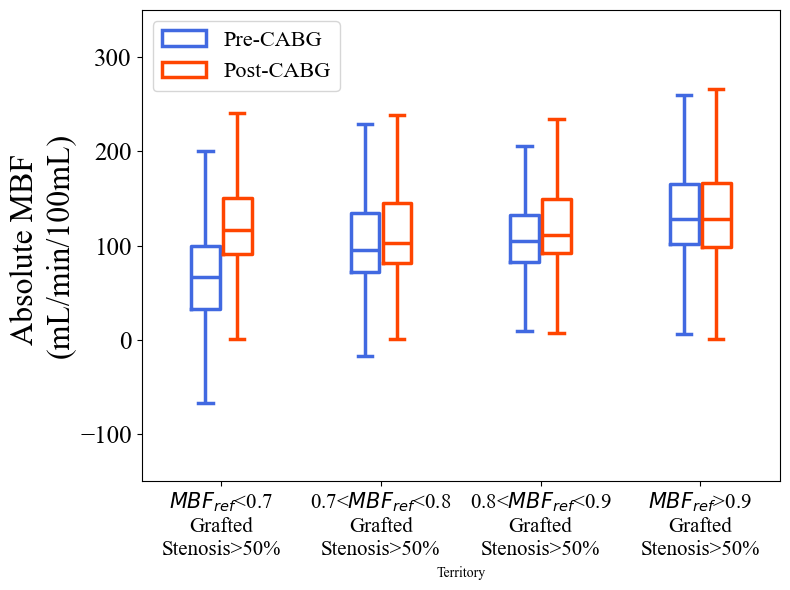

In [57]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='Territory', y='MBF', hue='Type', data= df_long, showfliers=False, width = 0.4, linewidth=2.5, fill= False, gap=.1, palette={'Pre-CABG':color1, 'Post-CABG':color2})

ax.set_ylabel("Absolute MBF \n(mL/min/100mL)", fontsize = 23)
ax.tick_params(axis='x', rotation=0, labelsize=13)
ax.legend(loc = 'upper left', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=18)
plt.ylim(-150,350)
plt.tight_layout()
plt.show()

### Statistical Test

In [58]:
median_mbf_ischemic10_A = []
median_mbf_ischemic10_B = []

for _, row in df[df['ischemic_grade'] == 1].iterrows():
    median_mbf_ischemic10_A.append(np.median(row['absMBF_A']))
    median_mbf_ischemic10_B.append(np.median(row['absMBF_B']))

WilcoxonTest(median_mbf_ischemic10_A, median_mbf_ischemic10_B)

Wilcoxon test statistics:  7.0
p-value:  0.07421875
number of datapoints: 9
Fail to reject the null hypothesis: There is no significant difference between the two samples.


np.float64(0.07421875)

In [59]:
median_mbf_ischemic20_A = []
median_mbf_ischemic20_B = []

for _, row in df[df['ischemic_grade'] == 2].iterrows():
    median_mbf_ischemic20_A.append(np.median(row['absMBF_A']))
    median_mbf_ischemic20_B.append(np.median(row['absMBF_B']))

WilcoxonTest(median_mbf_ischemic20_A, median_mbf_ischemic20_B)

Wilcoxon test statistics:  0.0
p-value:  0.0078125
number of datapoints: 8
Reject the null hypothesis: There is a significant difference between the two samples.


np.float64(0.0078125)

In [60]:
median_mbf_ischemic30_A = []
median_mbf_ischemic30_B = []

for _, row in df[df['ischemic_grade'] == 3].iterrows():
    median_mbf_ischemic30_A.append(np.median(row['absMBF_A']))
    median_mbf_ischemic30_B.append(np.median(row['absMBF_B']))

WilcoxonTest(median_mbf_ischemic30_A, median_mbf_ischemic30_B)

Wilcoxon test statistics:  0.0
p-value:  0.015625
number of datapoints: 7
Reject the null hypothesis: There is a significant difference between the two samples.


np.float64(0.015625)

In [61]:
median_mbf_ischemic0_A = []
median_mbf_ischemic0_B = []

for _, row in df[df['ischemic_grade'] == 0].iterrows():
    median_mbf_ischemic0_A.append(np.median(row['absMBF_A']))
    median_mbf_ischemic0_B.append(np.median(row['absMBF_B']))

WilcoxonTest(median_mbf_ischemic0_A, median_mbf_ischemic0_B)

Wilcoxon test statistics:  1555.0
p-value:  0.30501002644045894
number of datapoints: 84
Fail to reject the null hypothesis: There is no significant difference between the two samples.


np.float64(0.30501002644045894)

## Paired Dot Plot

In [62]:
paired_dot_ischemic = []
paired_dot_nonischemic = []
for patient_id in patient_ids:
    df_patient = df[df["patient_id"] == patient_id]
    if df_patient.empty:
        print(f"Patient {patient_id} not found in DataFrame. Skipping.")
        continue
    
    rawMBF_A = np.median(np.concatenate(df[df["patient_id"] == patient_id]["rawMBF_A"].values))
    absMBF_A = np.median(np.concatenate(df[df["patient_id"] == patient_id]["absMBF_A"].values))
    absMBF_B = np.median(np.concatenate(df[df["patient_id"] == patient_id]["absMBF_B"].values))
    ischemia_presence = list(df[df["patient_id"] == patient_id]["is_ischemic"])
    is_ischemic = any(ischemia_presence)
    if is_ischemic:
        paired_dot_ischemic.append({"patient_id": patient_id, 
                                "rawMBF_A": rawMBF_A,
                                "absMBF_A": absMBF_A,
                                "absMBF_B": absMBF_B})
        if absMBF_A > absMBF_B:
            print(patient_id, "is ischemic and median MBF is bigger in pre-CABG.")
    else:
        paired_dot_nonischemic.append({"patient_id": patient_id, 
                                "rawMBF_A": rawMBF_A,
                                "absMBF_A": absMBF_A,
                                "absMBF_B": absMBF_B})
        if absMBF_A > absMBF_B:
            print(patient_id, "is nonischemic and median MBF is bigger in pre-CABG.")

paired_dot_ischemic = pd.DataFrame(paired_dot_ischemic)
paired_dot_nonischemic = pd.DataFrame(paired_dot_nonischemic)

SU10 is ischemic and median MBF is bigger in pre-CABG.
SU14 is ischemic and median MBF is bigger in pre-CABG.
SU23 is ischemic and median MBF is bigger in pre-CABG.
Patient SU25 not found in DataFrame. Skipping.
SU33 is ischemic and median MBF is bigger in pre-CABG.
SU34 is ischemic and median MBF is bigger in pre-CABG.
Patient VA04 not found in DataFrame. Skipping.
VA06 is nonischemic and median MBF is bigger in pre-CABG.
VA08 is ischemic and median MBF is bigger in pre-CABG.
VA14 is nonischemic and median MBF is bigger in pre-CABG.


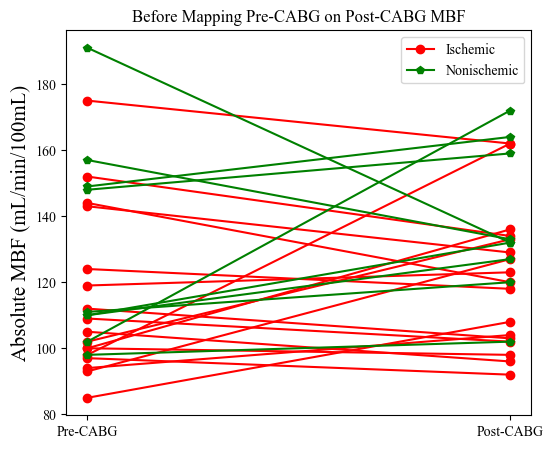

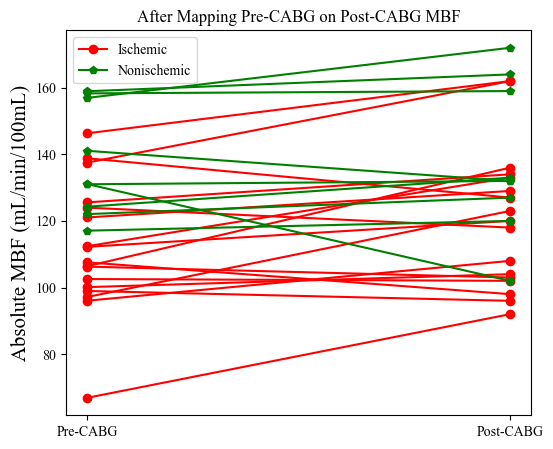

In [63]:
plt.figure(figsize=(6,5))

for i in range(len(paired_dot_ischemic)):
    if i == 0:
        plt.plot([0, 1], [paired_dot_ischemic["rawMBF_A"][i], paired_dot_ischemic["absMBF_B"][i]], marker = "o", label = "Ischemic", color = "red")
    else:
        plt.plot([0, 1], [paired_dot_ischemic["rawMBF_A"][i], paired_dot_ischemic["absMBF_B"][i]], marker = "o", label = None, color = "red")
for i in range(len(paired_dot_nonischemic)):
    if i == 0:
        plt.plot([0, 1], [paired_dot_nonischemic["rawMBF_A"][i], paired_dot_nonischemic["absMBF_B"][i]], marker = "p", label = "Nonischemic", color = "green")
    else:
            plt.plot([0, 1], [paired_dot_nonischemic["rawMBF_A"][i], paired_dot_nonischemic["absMBF_B"][i]], marker = "p", label = None, color = "green")

plt.xticks([0, 1], ["Pre-CABG", "Post-CABG"])
plt.ylabel("Absolute MBF (mL/min/100mL)", fontsize = 15)
plt.legend()
plt.title("Before Mapping Pre-CABG on Post-CABG MBF")
plt.show()

plt.figure(figsize=(6,5))

for i in range(len(paired_dot_ischemic)):
    if i == 0:
        plt.plot([0, 1], [paired_dot_ischemic["absMBF_A"][i], paired_dot_ischemic["absMBF_B"][i]], marker = "o", label = "Ischemic", color = "red")
    else:
        plt.plot([0, 1], [paired_dot_ischemic["absMBF_A"][i], paired_dot_ischemic["absMBF_B"][i]], marker = "o", label = None, color = "red")
for i in range(len(paired_dot_nonischemic)):
    if i == 0:
        plt.plot([0, 1], [paired_dot_nonischemic["absMBF_A"][i], paired_dot_nonischemic["absMBF_B"][i]], marker = "p", label = "Nonischemic", color = "green")
    else:
        plt.plot([0, 1], [paired_dot_nonischemic["absMBF_A"][i], paired_dot_nonischemic["absMBF_B"][i]], marker = "p", label = None, color = "green")

plt.xticks([0, 1], ["Pre-CABG", "Post-CABG"])
plt.ylabel("Absolute MBF (mL/min/100mL)", fontsize = 15)
plt.title("After Mapping Pre-CABG on Post-CABG MBF")
plt.legend()
plt.show()

## Statistical Analysis: Per patients (Wilcoxon signed-rank test)
Null Hypothesis (H0): There is no significant difference between the means of the two paired samples.

In [64]:
data_A = list(paired_dot_ischemic["absMBF_A"])
data_B = list(paired_dot_ischemic["absMBF_B"])

w_value, p_value  = wilcoxon(data_A, data_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(data_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


Wilcoxon test statistics:  30.0
p-value:  0.02667236328125
number of datapoints: 17
Reject the null hypothesis: There is a significant difference between the two samples.


In [65]:
entire_dataset = pd.concat([paired_dot_ischemic, paired_dot_nonischemic], ignore_index=True)

data_A = list(entire_dataset["absMBF_A"])
data_B = list(entire_dataset["absMBF_B"])

w_value, p_value  = wilcoxon(data_A, data_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(data_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


Wilcoxon test statistics:  95.0
p-value:  0.040747225284576416
number of datapoints: 26
Reject the null hypothesis: There is a significant difference between the two samples.


## Statistical Analysis: Per vessel 

In [66]:
df[(df["patient_id"] == "SU03") & (df["tag"] == "Diag")]["is_ischemic"].iloc[0]

np.True_

In [67]:
print(len(df["tag"]))

108


In [68]:
ischemic_territories = []
nonischemic_territories = []

ischemic_median_A = []
ischemic_median_B = []
nonischemic_median_A = []
nonischemic_median_B = []

nongrafted_median_A = []
nongrafted_median_B = []

grafted_median_A = []
grafted_median_B = []

nonischemic_grafted_A = []
nonischemic_grafted_B = []

for id in patient_ids:
    tags = list(df[df["patient_id"] == id]["tag"])
    df_patient = df[df["patient_id"] == id]
    if df_patient.empty:
        print(f"Patient {patient_id} not found in DataFrame. Skipping.")
        continue

    for tag in tags:
        median_absMBF_A = np.median(np.concatenate(df[(df["patient_id"] == id) & (df["tag"] == tag)]["absMBF_A"].values))
        median_absMBF_B = np.median(np.concatenate(df[(df["patient_id"] == id) & (df["tag"] == tag)]["absMBF_B"].values))
        
        if df[(df["patient_id"] == id) & (df["tag"] == tag)]["is_ischemic"].iloc[0] == True:
            ischemic_median_A.append(median_absMBF_A)
            ischemic_median_B.append(median_absMBF_B)
            """ischemic_territories.append({"patient_id": id,
                                        "tag": tag,
                                        "median_absMBF_A": median_absMBF_A,
                                        "median_absMBF_B": median_absMBF_B})"""
        else:
            nonischemic_median_A.append(median_absMBF_A)
            nonischemic_median_B.append(median_absMBF_B)
            """nonischemic_territories.append({"patient_id": id,
                                        "tag": tag,
                                        "median_absMBF_A": median_absMBF_A,
                                        "median_absMBF_B": median_absMBF_B})"""
            if tag not in ["Nongrafted", "Nongrafted-Stenosis"]:
                nonischemic_grafted_A.append(median_absMBF_A)
                nonischemic_grafted_B.append(median_absMBF_B)
        
        if tag in ["Nongrafted", "Nongrafted-Stenosis"]:
            nongrafted_median_A.append(median_absMBF_A)
            nongrafted_median_B.append(median_absMBF_B)
        else:
            grafted_median_A.append(median_absMBF_A)
            grafted_median_B.append(median_absMBF_B)


#ischemic_territories = pd.DataFrame(ischemic_territories)
#nonischemic_territories = pd.DataFrame(nonischemic_territories)

Patient VA20 not found in DataFrame. Skipping.
Patient VA20 not found in DataFrame. Skipping.


In [69]:
print(len(grafted_median_A))

70


In [70]:
w_value, p_value = wilcoxon(ischemic_median_A, ischemic_median_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(ischemic_median_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


Wilcoxon test statistics:  12.0
p-value:  8.344650268554688e-06
number of datapoints: 24
Reject the null hypothesis: There is a significant difference between the two samples.


In [71]:
w_value, p_value = wilcoxon(nonischemic_median_A, nonischemic_median_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(ischemic_median_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


Wilcoxon test statistics:  1555.0
p-value:  0.30501002644045894
number of datapoints: 24
Fail to reject the null hypothesis: There is no significant difference between the two samples.


In [72]:
w_value, p_value = wilcoxon(nongrafted_median_A, nongrafted_median_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(nongrafted_median_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


Wilcoxon test statistics:  347.0
p-value:  0.7415718131742324
number of datapoints: 38
Fail to reject the null hypothesis: There is no significant difference between the two samples.


In [73]:
w_value, p_value = wilcoxon(grafted_median_A, grafted_median_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(grafted_median_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


Wilcoxon test statistics:  579.0
p-value:  0.00010320818626160379
number of datapoints: 70
Reject the null hypothesis: There is a significant difference between the two samples.


In [74]:
w_value, p_value = wilcoxon(nonischemic_grafted_A, nonischemic_grafted_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(nonischemic_grafted_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


Wilcoxon test statistics:  411.0
p-value:  0.16013347692305047
number of datapoints: 46
Fail to reject the null hypothesis: There is no significant difference between the two samples.


In [75]:
entire_territories_A = [*ischemic_median_A, *nonischemic_median_A]
entire_territories_B = [*ischemic_median_B, *nonischemic_median_B]

w_value, p_value = wilcoxon(entire_territories_A, entire_territories_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(entire_territories_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


Wilcoxon test statistics:  1875.0
p-value:  0.0010619738094409202
number of datapoints: 108
Reject the null hypothesis: There is a significant difference between the two samples.


### Scatter Plot

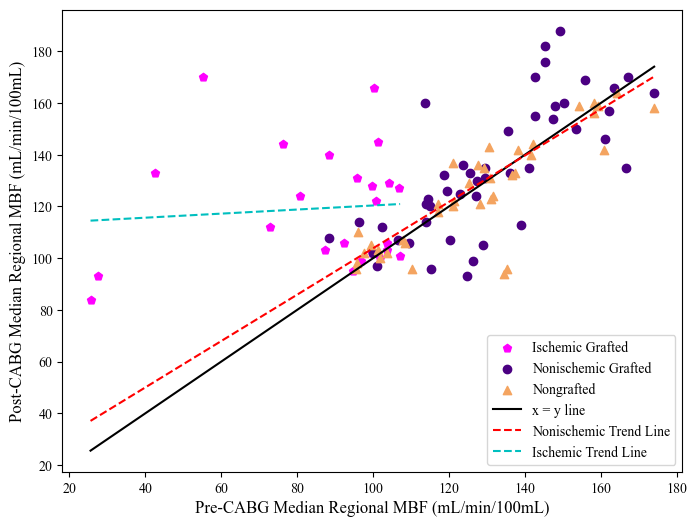

In [76]:
plt.figure(figsize=(8, 6))

plt.scatter(ischemic_median_A, ischemic_median_B, marker = 'p', color = 'fuchsia', label = 'Ischemic Grafted')
plt.scatter(nonischemic_grafted_A, nonischemic_grafted_B, marker = 'o', color = 'indigo', label = "Nonischemic Grafted")
plt.scatter(nongrafted_median_A, nongrafted_median_B, marker = '^', color = 'sandybrown', label = "Nongrafted")

x_fit = np.linspace(min(grafted_median_A), max(grafted_median_A), 100)
plt.plot(x_fit, x_fit, 'k-', label = "x = y line")

slope, intercept, _, _, _ = linregress(nonischemic_median_A, nonischemic_median_B)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, 'r--', label= "Nonischemic Trend Line")

slope, intercept, _, _, _ = linregress(ischemic_median_A, ischemic_median_B)
x_fit = np.linspace(min(ischemic_median_A), max(ischemic_median_A), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, 'c--', label= "Ischemic Trend Line")


plt.xlabel("Pre-CABG Median Regional MBF (mL/min/100mL)", fontsize = 12)
plt.ylabel("Post-CABG Median Regional MBF (mL/min/100mL)", fontsize = 12)
plt.legend()
plt.show()

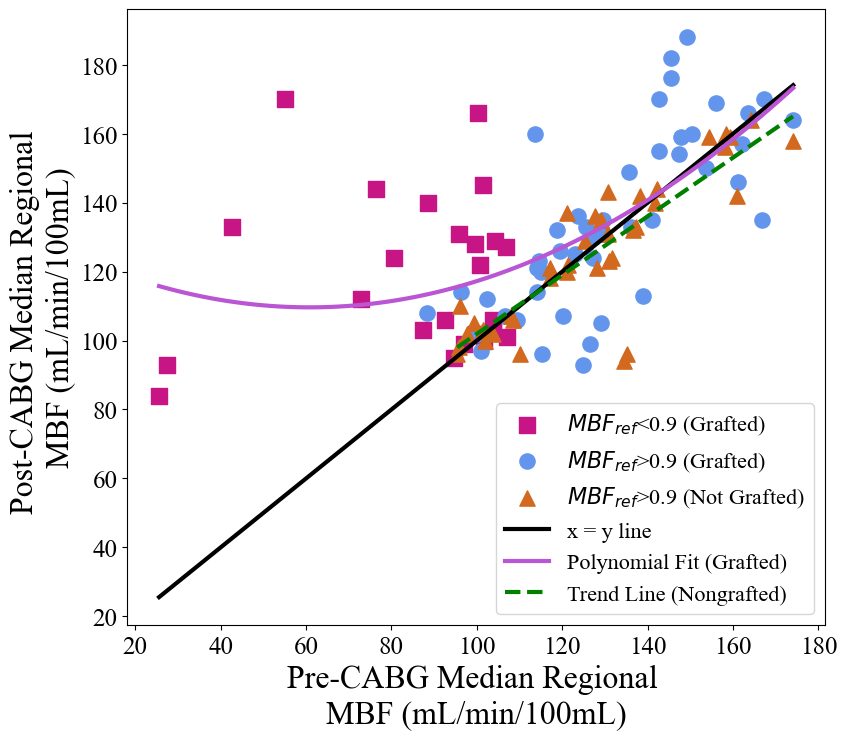

In [80]:
plt.figure(figsize=(9, 8))

plt.scatter(ischemic_median_A, ischemic_median_B, marker = 's', s = 120, color = 'mediumvioletred', label = '$MBF_{ref}$<0.9 (Grafted)')
plt.scatter(nonischemic_grafted_A, nonischemic_grafted_B, marker = 'o', s = 120, color = 'cornflowerblue', label = "$MBF_{ref}$>0.9 (Grafted)")
plt.scatter(nongrafted_median_A, nongrafted_median_B, marker = '^', s = 120, color = 'chocolate', label = "$MBF_{ref}$>0.9 (Not Grafted)")

x_fit = np.linspace(min(grafted_median_A), max(grafted_median_A), 100)
plt.plot(x_fit, x_fit, 'k-', linewidth=3, label = "x = y line")

deg = 2
poly = PolynomialFeatures(degree=deg)
x_poly = poly.fit_transform(np.array(grafted_median_A).reshape(-1,1))

LinReg = LinearRegression()
LinReg.fit(x_poly, np.array(grafted_median_B))

x_new = np.linspace(np.array(grafted_median_A).min(), np.array(grafted_median_A).max(), 100).reshape(-1,1)
x_new_poly = poly.transform(x_new)
y_pred = LinReg.predict(x_new_poly)

plt.plot(x_new, y_pred, color = 'mediumorchid', linewidth=3, label=f"Polynomial Fit (Grafted)")

x_fit = np.linspace(min(nongrafted_median_A), max(nongrafted_median_A), 100)

slope, intercept, _, _, _ = linregress(nongrafted_median_A, nongrafted_median_B)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, 'g--', linewidth=3, label= "Trend Line (Nongrafted)")

font1 = {'color':'black','size':23, 'family':'Times New Roman'}
plt.rcParams['font.family'] = 'Times New Roman'

plt.xlabel("Pre-CABG Median Regional \nMBF (mL/min/100mL)", fontdict = font1)
plt.ylabel("Post-CABG Median Regional \nMBF (mL/min/100mL)", fontdict = font1)
plt.xticks(fontsize = 18, fontfamily='Times New Roman')
plt.yticks(fontsize = 18, fontfamily='Times New Roman')
plt.legend(fontsize = 16)
plt.show()

# Thresholding on index MBF

In [82]:
volume_data_ischemic = []
volume_data_nonischemic = []
Removed_Cases_volume = Removed_Cases + ['SU03']
for patient_id in patient_ids:
    if patient_id in Removed_Cases_volume: 
        continue
    
    normalization_method = "classic"
    for file in VTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = Normalize(ReadVTUFile(file), normalization_method)
        elif f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = Normalize(ReadVTUFile(file), normalization_method)

    nonischemic_grid_A = ThresholdByUpper(MBF_A, "IndexMBF", 0.9)
    nonischemic_grid_B = ThresholdByUpper(MBF_B, "IndexMBF", 0.9)

    IschemicVolume_A = (GetVolume(MBF_A) - GetVolume(nonischemic_grid_A))/GetVolume(MBF_A)*100
    IschemicVolume_B = (GetVolume(MBF_B) - GetVolume(nonischemic_grid_B))/GetVolume(MBF_B)*100

    ischemia_presence = list(df[df["patient_id"] == patient_id]["is_ischemic"])
    is_ischemic = any(ischemia_presence)
    if is_ischemic:
        volume_data_ischemic.append({
            "patient_id": patient_id,
            "Volume_A": IschemicVolume_A,
            "Volume_B": IschemicVolume_B
        })
    else:
        volume_data_nonischemic.append({
            "patient_id": patient_id,
            "Volume_A": IschemicVolume_A,
            "Volume_B": IschemicVolume_B
        })

volume_data_ischemic = pd.DataFrame(volume_data_ischemic)
volume_data_nonischemic = pd.DataFrame(volume_data_nonischemic)

volume_entire_cohort = pd.concat([volume_data_ischemic, volume_data_nonischemic], ignore_index=True)

In [83]:
df_A = pd.DataFrame({
    'Volume': np.concatenate([volume_data_ischemic["Volume_A"], volume_data_nonischemic["Volume_A"], volume_entire_cohort["Volume_A"]]),
    'Case': ['Ischemic\n Cases'] * len(volume_data_ischemic["Volume_A"]) +
            ['NonIschemic\n Cases'] * len(volume_data_nonischemic["Volume_A"]) +
            ['Entire Cohort'] * len(volume_entire_cohort["Volume_A"]),
    'Type': ['Pre-CABG'] * (len(volume_data_ischemic["Volume_A"]) + len(volume_data_nonischemic["Volume_A"]) + len(volume_entire_cohort["Volume_A"]))
})

df_B = pd.DataFrame({
    'Volume': np.concatenate([volume_data_ischemic["Volume_B"], volume_data_nonischemic["Volume_B"], volume_entire_cohort["Volume_B"]]),
    'Case': ['Ischemic\n Cases'] * len(volume_data_ischemic["Volume_B"]) +
            ['NonIschemic\n Cases'] * len(volume_data_nonischemic["Volume_B"]) +
            ['Entire Cohort'] * len(volume_entire_cohort["Volume_B"]),
    'Type': ['Post-CABG'] * (len(volume_data_ischemic["Volume_B"]) + len(volume_data_nonischemic["Volume_B"]) + len(volume_entire_cohort["Volume_B"]))
})

df_long = pd.concat([df_A, df_B], ignore_index=True)

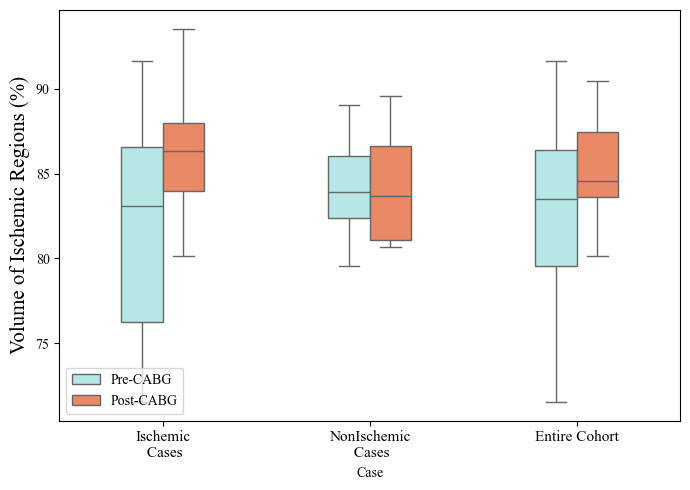

In [84]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x='Case', y='Volume', hue='Type', data= df_long, showfliers=False, width = 0.4, palette={'Pre-CABG':'paleturquoise', 'Post-CABG':'coral'})

ax.set_ylabel("Volume of Ischemic Regions (%)", fontsize = 15)
ax.tick_params(axis='x', rotation=0, labelsize=11)
ax.legend(loc = 'lower left')
plt.tight_layout()
plt.show()

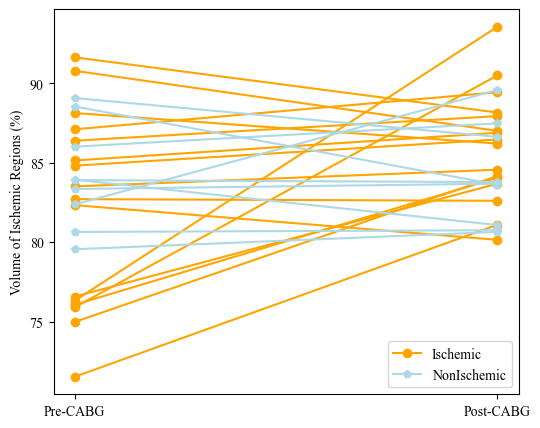

In [85]:
plt.figure(figsize=(6,5))

for i in range(len(volume_data_ischemic)):
    if i == 0:
        plt.plot([0, 1], [volume_data_ischemic["Volume_A"][i], volume_data_ischemic["Volume_B"][i]], marker = "o", color = "orange", label = "Ischemic")
    else:
        plt.plot([0, 1], [volume_data_ischemic["Volume_A"][i], volume_data_ischemic["Volume_B"][i]], marker = "o", color = "orange", label = None)
for i in range(len(volume_data_nonischemic)):
    if i == 0:
        plt.plot([0, 1], [volume_data_nonischemic["Volume_A"][i], volume_data_nonischemic["Volume_B"][i]], marker = "p", color = "lightblue", label = "NonIschemic")
    else:
        plt.plot([0, 1], [volume_data_nonischemic["Volume_A"][i], volume_data_nonischemic["Volume_B"][i]], marker = "p", color = "lightblue", label = None)
plt.xticks([0, 1], ["Pre-CABG", "Post-CABG"])
plt.ylabel("Volume of Ischemic Regions (%)")
plt.legend()
plt.show()

In [86]:
def GetStats(dataframe):
    q1, q2, q3 = np.percentile(dataframe, [25, 50, 75])
    average = np.mean(dataframe)
    std = np.std(dataframe)
    return q2, q3-q1, average, std

print("TerritoryTag", "Median", "IQR", "Mean", "std")
volume_ischemic_A = np.concatenate([volume_data_ischemic["Volume_A"]])
print("Volume of Ischemic Regions (Ischemic Cases) Pre-CABG: ", GetStats(volume_ischemic_A))

volume_ischemic_B = np.concatenate([volume_data_ischemic["Volume_B"]])
print("Volume of Ischemic Regions (Ischemic Cases) Post-CABG: ", GetStats(volume_ischemic_B))

volume_nonischemic_A = np.concatenate([volume_data_nonischemic["Volume_A"]])
print("Volume of Ischemic Regions (Nonischemic Cases) Pre-CABG: ", GetStats(volume_nonischemic_A))

volume_nonischemic_B = np.concatenate([volume_data_nonischemic["Volume_B"]])
print("Volume of Ischemic Regions (Nonischemic Cases) Post-CABG: ", GetStats(volume_nonischemic_B))

EntireCohort_A = np.concatenate([volume_entire_cohort["Volume_A"]])
print("Volume of Ischemic Regions (Entire Dataset) Pre-CABG: ", GetStats(EntireCohort_A))

EntireCohort_B = np.concatenate([volume_entire_cohort["Volume_B"]])
print("Volume of Ischemic Regions (Entire Dataset) Post-CABG: ", GetStats(EntireCohort_B))

TerritoryTag Median IQR Mean std
Volume of Ischemic Regions (Ischemic Cases) Pre-CABG:  (np.float64(83.11329444111335), np.float64(10.309303234495403), np.float64(82.12406167288333), np.float64(5.948663373825498))
Volume of Ischemic Regions (Ischemic Cases) Post-CABG:  (np.float64(86.3369702142285), np.float64(4.031458490085413), np.float64(86.03215626110949), np.float64(3.390320790314241))
Volume of Ischemic Regions (Nonischemic Cases) Pre-CABG:  (np.float64(83.91016269314842), np.float64(3.6368664204061787), np.float64(84.15839035552833), np.float64(3.059271153034934))
Volume of Ischemic Regions (Nonischemic Cases) Post-CABG:  (np.float64(83.68678873078092), np.float64(5.550213565896868), np.float64(84.14264912466098), np.float64(2.9913686730552573))
Volume of Ischemic Regions (Entire Dataset) Pre-CABG:  (np.float64(83.51382315409631), np.float64(6.828143744593845), np.float64(82.85641999863554), np.float64(5.193286110433114))
Volume of Ischemic Regions (Entire Dataset) Post-CABG:  (

# Analyzing Based on the Graft Type

In [87]:
grafts = sorted(set(PatientMetadata["graft"]))
print(grafts)

['LIMA', 'RIMA', 'Radial', 'SVG', 'n']


In [88]:
print(PatientMetadata["graft"].value_counts())

graft
SVG       37
LIMA      26
Radial    10
RIMA       1
n          1
Name: count, dtype: int64


In [89]:
print(len(df["tag"]))
print(df["tag"].value_counts())

108
tag
LAD                    26
Nongrafted             26
RCA                    18
LCx                    15
Nongrafted-Stenosis    12
Diag                    3
OM                      3
PDA                     3
Ramus                   2
Name: count, dtype: int64


In [90]:
print(PatientMetadata["NG"].value_counts())

NG
n        58
LCx       6
PDA       2
RCA       2
Diag1     2
IM        1
OM1       1
IM_0      1
m         1
PL        1
Name: count, dtype: int64


In [91]:
LIMA_mbf_A = np.concatenate(df[df['graft_type'] == 'LIMA']['absMBF_A'].values)
LIMA_mbf_B = np.concatenate(df[df['graft_type'] == 'LIMA']['absMBF_B'].values)

Radial_mbf_A = np.concatenate(df[df['graft_type'] == 'Radial']['absMBF_A'].values)
Radial_mbf_B = np.concatenate(df[df['graft_type'] == 'Radial']['absMBF_B'].values)

SVG_mbf_A = np.concatenate(df[df['graft_type'] == 'SVG']['absMBF_A'].values)
SVG_mbf_B = np.concatenate(df[df['graft_type'] == 'SVG']['absMBF_B'].values)

In [92]:
df_A = pd.DataFrame({
    'MBF': np.concatenate([LIMA_mbf_A, Radial_mbf_A, SVG_mbf_A]),
    'Graft': ['LIMA'] * len(LIMA_mbf_A) +
                ['Radial'] * len(Radial_mbf_A) +
                ['SVG'] * len(SVG_mbf_A),
    'Type': ['Pre-CABG'] * (len(LIMA_mbf_A) + len(Radial_mbf_A) + len(SVG_mbf_A))
})

df_B = pd.DataFrame({
    'MBF': np.concatenate([LIMA_mbf_B, Radial_mbf_B, SVG_mbf_B]),
    'Graft': ['LIMA'] * len(LIMA_mbf_B) +
                ['Radial'] * len(Radial_mbf_B) +
                ['SVG'] * len(SVG_mbf_B),
    'Type': ['Post-CABG'] * (len(LIMA_mbf_B) + len(Radial_mbf_B) + len(SVG_mbf_B))
})

df_long = pd.concat([df_A, df_B], ignore_index=True)

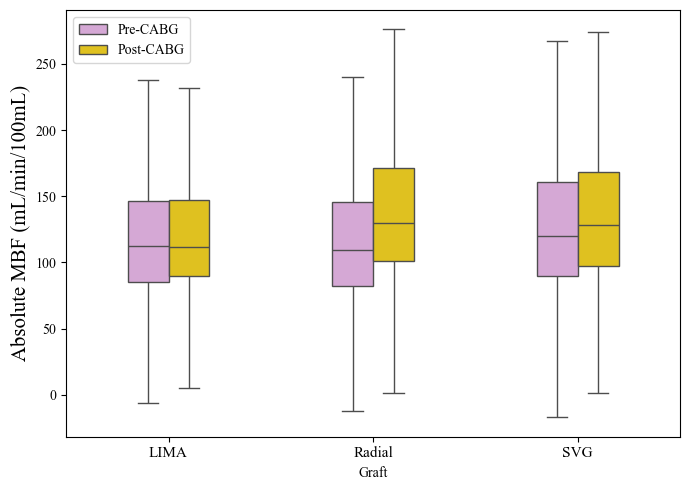

In [93]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x='Graft', y='MBF', hue='Type', data= df_long, showfliers=False, width = 0.4, palette={'Pre-CABG':'plum', 'Post-CABG':'gold'})

ax.set_ylabel("Absolute MBF (mL/min/100mL)", fontsize = 15)
ax.tick_params(axis='x', rotation=0, labelsize=11)
ax.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

## Comparing the volume fed by each graft

In [ ]:
LIMA_volume_A = []
LIMA_volume_B = []

Radial_volume_A = []
Radial_volume_B = []

SVG_volume_A = []
SVG_volume_B = []

Removed_Cases_volume = Removed_Cases + ['SU03']

for patient_id in patient_ids:
    if patient_id in Removed_Cases_volume: 
        continue
    tags = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['stenosis tag'])
    TerritoryTags = [f'post_{tag}' for tag in tags]
    grafts = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['graft'])
    for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file
    MBF_Labels = ReadLabels(LabelFile, TerritoryTags)
    normalization_method = "classic"
    for file in VTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = Normalize(ReadVTUFile(file), normalization_method)
        elif f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = Normalize(ReadVTUFile(file), normalization_method)

        for tag in tags:
            graft = PatientMetadata[(PatientMetadata['patient-id'] == patient_id) & (PatientMetadata['stenosis tag'] == tag)]['graft']
            if graft.iloc[0] == 'LIMA':
                LIMA_volume_A.append(GetRegionVolume(MBF_A, MBF_Labels, tag))
                LIMA_volume_B.append(GetRegionVolume(MBF_B, MBF_Labels, tag))
            if graft.iloc[0] == 'Radial':
                Radial_volume_A.append(GetRegionVolume(MBF_A, MBF_Labels, tag))
                Radial_volume_B.append(GetRegionVolume(MBF_B, MBF_Labels, tag))
            if graft.iloc[0] == 'SVG':
                SVG_volume_A.append(GetRegionVolume(MBF_A, MBF_Labels, tag))
                SVG_volume_B.append(GetRegionVolume(MBF_B, MBF_Labels, tag))

LIMA_volume_A = np.array(LIMA_volume_A)
LIMA_volume_B = np.array(LIMA_volume_B)

Radial_volume_A = np.array(Radial_volume_A)
Radial_volume_B = np.array(Radial_volume_B)

SVG_volume_A = np.array(SVG_volume_A)
SVG_volume_B = np.array(SVG_volume_B)



### Box Plot

In [ ]:
df_A = pd.DataFrame({
    'Volume': np.concatenate([LIMA_volume_A, Radial_volume_A, SVG_volume_A]),
    'Graft':
        ['LIMA'] * len(LIMA_volume_A) +
        ['Radial'] * len(Radial_volume_A) +
        ['SVG'] * len(SVG_volume_A),
    'Type': ['Pre-CABG'] * (len(LIMA_volume_A) + len(Radial_volume_A) + len(SVG_volume_A))
})

df_B = pd.DataFrame({
    'Volume': np.concatenate([LIMA_volume_B, Radial_volume_B, SVG_volume_B]),
    'Graft':
        ['LIMA'] * len(LIMA_volume_B) +
        ['Radial'] * len(Radial_volume_B) +
        ['SVG'] * len(SVG_volume_B),
    'Type': ['Post-CABG'] * (len(LIMA_volume_B) + len(Radial_volume_B) + len(SVG_volume_B))
})

df_long = pd.concat([df_A, df_B], ignore_index=True)

In [ ]:
plt.figure(figsize=(5, 5))
ax = sns.boxplot(x='Graft', y='Volume', hue='Type', data= df_B, showfliers=False, width = 0.4, palette={'Pre-CABG':'plum', 'Post-CABG':'azure'})

ax.set_ylabel("Volume (mL)", fontsize = 15)
ax.tick_params(axis='x', rotation=0, labelsize=11)
ax.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

## Statistical Analysis: Kruskal-Wallis test on the differences of median MBF per graft type

In [95]:
LIMA_d_median_mbf = []
Radial_d_median_mbf = []
SVG_d_median_mbf = []

for patient_id in patient_ids:
    df_patient = df[df["patient_id"] == patient_id]
    if df_patient.empty:
        print(f"Patient {patient_id} not found in DataFrame. Skipping.")
        continue
    
    grafts = list(df[df["patient_id"] == patient_id]["graft_type"])
    for graft in grafts:
        if graft:
            median_A = np.median(df[(df["patient_id"] == patient_id) & (df["graft_type"] == graft)]["absMBF_A"].iloc[0])
            median_B = np.median(df[(df["patient_id"] == patient_id) & (df["graft_type"] == graft)]["absMBF_B"].iloc[0])
        diff = median_B - median_A
        if graft == "LIMA":
            LIMA_d_median_mbf.append(diff)
        elif graft == "Radial":
            Radial_d_median_mbf.append(diff)
        elif graft == "SVG":
            SVG_d_median_mbf.append(diff)
        else:
            pass



Patient SU25 not found in DataFrame. Skipping.
Patient VA04 not found in DataFrame. Skipping.


In [96]:
stat, p = kruskal(LIMA_d_median_mbf, Radial_d_median_mbf, SVG_d_median_mbf)
print(p)
if p > 0.05:
    print("There is no significant difference in improvement (ΔMBF) between different graft types.")
else:
    print("There is a difference—at least one graft type shows a significantly different median improvement.")

0.173034019626641
There is no significant difference in improvement (ΔMBF) between different graft types.


# Territory-based analysis

In [97]:
def TerritorySelection(tag):
    if any(sub in tag.lower() for sub in ["lcx", "om", "intermedius"]):
        territory = "LCx"
    elif any(sub in tag.lower() for sub in ["lad", "diag"]):
        territory = "LAD"
    elif any(sub in tag.lower() for sub in ["pda", "pl"]):
        territory = "RCA"
    else:
        print(f"{tag} was not assigned to any specific territory.")
        territory = None
    
    return territory

def TerritoryAssignment(MBF, InputLabels, ScalarArray):
    
    Territories = {"LAD":None, "LCx":None, "RCA":None}
    Territory_ids = {"LAD":[], "LCx":[], "RCA":[]}
    with open(InputLabels, "r") as ifile:
        for i, LINE in enumerate(ifile):
            if i == 0: 
                continue
            line = LINE.strip().split()
            label = line[1]
            id_value = int(line[0])

            
            territory_tag = TerritorySelection(label)
            if territory_tag is not None:
                Territory_ids[territory_tag].append(id_value)
    
    for tag, ids in Territory_ids.items():
        TerritoryAppend = vtk.vtkAppendFilter()
        for id in ids:
            territory = ThresholdInBetween(MBF, "TerritoryMaps", id, id)
            TerritoryAppend.AddInputData(territory)
        TerritoryAppend.Update()
        Territory = TerritoryAppend.GetOutput()
        MBFArray = vtk_to_numpy(Territory.GetPointData().GetArray(ScalarArray))
        Territories[tag] = MBFArray

    return Territories


MappedVTUFiles = glob.glob(f"{opath}/*.vtu")

LAD_MBF_A = []
LAD_MBF_B = []

LCx_MBF_A = []
LCx_MBF_B = []

RCA_MBF_A = []
RCA_MBF_B = []
Removed_Cases_ = Removed_Cases + ["VA13"]
for patient_id in patient_ids:
    if patient_id in Removed_Cases_: 
        continue
    print(patient_id)

    for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file

    for file in MappedVTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = ReadVTUFile(file)
    for file in VTUFiles:
        if f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = ReadVTUFile(file)
    
    for i in range(MBF_B.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF_B.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ScalarArray_B = arrayname_
    
    MappedScalarArrayName = "MappedScalar"
    territory_A = TerritoryAssignment(MBF_A, LabelFile, MappedScalarArrayName)
    territory_B = TerritoryAssignment(MBF_B, LabelFile, ScalarArray_B)

    LAD_MBF_A.append(territory_A["LAD"])
    LAD_MBF_B.append(territory_B["LAD"])

    LCx_MBF_A.append(territory_A["LCx"])
    LCx_MBF_B.append(territory_B["LCx"])

    RCA_MBF_A.append(territory_A["RCA"])
    RCA_MBF_B.append(territory_B["RCA"])

LAD_MBF_A = np.concatenate(LAD_MBF_A)
LAD_MBF_B = np.concatenate(LAD_MBF_B)

LCx_MBF_A = np.concatenate(LCx_MBF_A)
LCx_MBF_B = np.concatenate(LCx_MBF_B)

RCA_MBF_A = np.concatenate(RCA_MBF_A)
RCA_MBF_B = np.concatenate(RCA_MBF_B)

SU03
SU04
SU06
SU07
SU10
SU11
SU13
SU14
SU16
SU21
SU23
SU24
SU26
SU27
SU28
SU30
SU33
SU34
VA02
VA06
VA08
VA10
VA14
VA16
VA20


In [ ]:

df_A = pd.DataFrame({
    'MBF': np.concatenate([LAD_MBF_A, LCx_MBF_A, RCA_MBF_A]),
    'Territory': ["LAD"] * len(LAD_MBF_A) +
                ["LCx"] * len(LCx_MBF_A) +
                ["RCA"] * len(RCA_MBF_A),
    'Type': ['Pre-CABG'] * (len(LAD_MBF_A) + len(LCx_MBF_A) + len(RCA_MBF_A))
})

df_B = pd.DataFrame({
    'MBF': np.concatenate([LAD_MBF_B, LCx_MBF_B, RCA_MBF_B]),
    'Territory': ["LAD"] * len(LAD_MBF_B) +
                ["LCx"] * len(LCx_MBF_B) +
                ["RCA"] * len(RCA_MBF_B),
    'Type': ['Post-CABG'] * (len(LAD_MBF_B) + len(LCx_MBF_B) + len(RCA_MBF_B))
})

df_long = pd.concat([df_A, df_B], ignore_index=True)

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x='Territory', y='MBF', hue='Type', data= df_long, showfliers=False, width = 0.4, palette={'Pre-CABG':'plum', 'Post-CABG':'gold'})

ax.set_ylabel("Absolute MBF (mL/min/100mL)", fontsize = 15)
ax.tick_params(axis='x', rotation=0, labelsize=11)
ax.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

# Territory-Based Analysis Downstream a Stenosis

In [98]:
tags_unique = sorted(set(PatientMetadata["stenosis tag"]))
print(tags_unique)

['Diag', 'LAD', 'LCx', 'OM', 'PDA', 'RCA', 'Ramus']


In [99]:
tags_dataframe = sorted(set(df["tag"]))
print(tags_dataframe)

['Diag', 'LAD', 'LCx', 'Nongrafted', 'Nongrafted-Stenosis', 'OM', 'PDA', 'RCA', 'Ramus']


In [100]:
#Is ischemic

LAD_MBF_A = np.concatenate(df[(df["tag"].isin(["LAD", "Diag"])) & (df["is_ischemic"] == True)]["absMBF_A"].values)
LAD_MBF_B = np.concatenate(df[(df["tag"].isin(["LAD", "Diag"]))& (df["is_ischemic"] == True)]["absMBF_B"].values)

LCx_MBF_A = np.concatenate(df[(df["tag"].isin(["LCx", "Ramus", "OM"])) & (df["is_ischemic"] == True)]["absMBF_A"].values)
LCx_MBF_B = np.concatenate(df[(df["tag"].isin(["LCx", "Ramus", "OM"])) & (df["is_ischemic"] == True)]["absMBF_B"].values)

RCA_MBF_A = np.concatenate(df[(df["tag"].isin(["PDA", "RCA"])) & (df["is_ischemic"] == True)]["absMBF_A"].values)
RCA_MBF_B = np.concatenate(df[(df["tag"].isin(["PDA", "RCA"])) & (df["is_ischemic"] == True)]["absMBF_B"].values)

In [101]:
#statistical analysis
mask = (df["tag"].isin(["LAD", "Diag"])) & (df["is_ischemic"] == True)
LAD_MBF_A_median = np.array([np.median(arr) for arr in df.loc[mask, "absMBF_A"]])
LAD_MBF_B_median = np.array([np.median(arr) for arr in df.loc[mask, "absMBF_B"]])

mask = (df["tag"].isin(["LCx", "Ramus", "OM"])) & (df["is_ischemic"] == True)
LCx_MBF_A_median = np.array([np.median(arr) for arr in df.loc[mask, "absMBF_A"]])
LCx_MBF_B_median = np.array([np.median(arr) for arr in df.loc[mask, "absMBF_B"]])

mask = (df["tag"].isin(["PDA", "RCA"])) & (df["is_ischemic"] == True)
RCA_MBF_A_median = np.array([np.median(arr) for arr in df.loc[mask, "absMBF_A"]])
RCA_MBF_B_median = np.array([np.median(arr) for arr in df.loc[mask, "absMBF_B"]])

In [102]:
w_value, p_value = wilcoxon(LAD_MBF_A_median, LAD_MBF_B_median)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(LAD_MBF_A_median))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


Wilcoxon test statistics:  6.0
p-value:  0.0546875
number of datapoints: 9
Fail to reject the null hypothesis: There is no significant difference between the two samples.


In [103]:
w_value, p_value = wilcoxon(LCx_MBF_A_median, LCx_MBF_B_median)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(LCx_MBF_A_median))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


Wilcoxon test statistics:  1.0
p-value:  0.0625
number of datapoints: 6
Fail to reject the null hypothesis: There is no significant difference between the two samples.


In [104]:
w_value, p_value = wilcoxon(RCA_MBF_A_median, RCA_MBF_B_median)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(RCA_MBF_A_median))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


Wilcoxon test statistics:  0.0
p-value:  0.00390625
number of datapoints: 9
Reject the null hypothesis: There is a significant difference between the two samples.


In [105]:
df_A = pd.DataFrame({
    'MBF': np.concatenate([LAD_MBF_A, LCx_MBF_A, RCA_MBF_A]),
    'Territory': ["LAD"] * len(LAD_MBF_A) +
                ["LCx"] * len(LCx_MBF_A) +
                ["RCA"] * len(RCA_MBF_A),
    'Type': ['Pre-CABG'] * (len(LAD_MBF_A) + len(LCx_MBF_A) + len(RCA_MBF_A))
})

df_B = pd.DataFrame({
    'MBF': np.concatenate([LAD_MBF_B, LCx_MBF_B, RCA_MBF_B]),
    'Territory': ["LAD"] * len(LAD_MBF_B) +
                ["LCx"] * len(LCx_MBF_B) +
                ["RCA"] * len(RCA_MBF_B),
    'Type': ['Post-CABG'] * (len(LAD_MBF_B) + len(LCx_MBF_B) + len(RCA_MBF_B))
})

df_long = pd.concat([df_A, df_B], ignore_index=True)

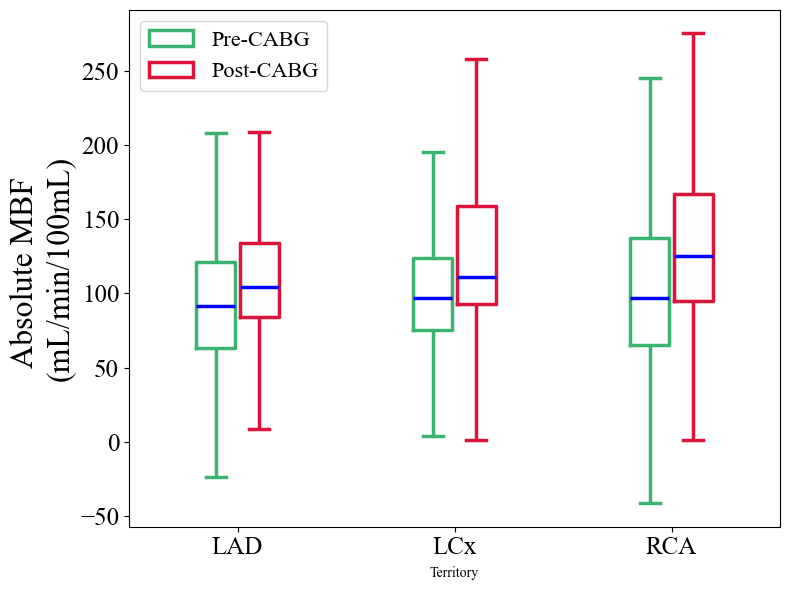

In [106]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='Territory', y='MBF', hue='Type', data= df_long, showfliers=False, width = 0.4, linewidth=2.5, fill= False, gap=.1, palette={'Pre-CABG':'mediumseagreen', 'Post-CABG':'crimson'}, medianprops={"color": "b", "linewidth": 2.5})

ax.set_ylabel("Absolute MBF \n(mL/min/100mL)", fontsize = 23)
ax.tick_params(axis='x', rotation=0, labelsize=18)
ax.legend(loc = 'upper left', fontsize=16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

In [107]:
#Is not ischemic

LAD_MBF_A = np.concatenate(df[(df["tag"].isin(["LAD", "Diag"])) & (df["is_ischemic"] == False)]["absMBF_A"].values)
LAD_MBF_B = np.concatenate(df[(df["tag"].isin(["LAD", "Diag"]))& (df["is_ischemic"] == False)]["absMBF_B"].values)

LCx_MBF_A = np.concatenate(df[(df["tag"].isin(["LCx", "Ramus", "OM"])) & (df["is_ischemic"] == False)]["absMBF_A"].values)
LCx_MBF_B = np.concatenate(df[(df["tag"].isin(["LCx", "Ramus", "OM"])) & (df["is_ischemic"] == False)]["absMBF_B"].values)

RCA_MBF_A = np.concatenate(df[(df["tag"].isin(["PDA", "RCA"])) & (df["is_ischemic"] == False)]["absMBF_A"].values)
RCA_MBF_B = np.concatenate(df[(df["tag"].isin(["PDA", "RCA"])) & (df["is_ischemic"] == False)]["absMBF_B"].values)

In [108]:
#statistical analysis
mask = (df["tag"].isin(["LAD", "Diag"])) & (df["is_ischemic"] == False)
LAD_MBF_A_median = np.array([np.median(arr) for arr in df.loc[mask, "absMBF_A"]])
LAD_MBF_B_median = np.array([np.median(arr) for arr in df.loc[mask, "absMBF_B"]])

mask = (df["tag"].isin(["LCx", "Ramus", "OM"])) & (df["is_ischemic"] == False)
LCx_MBF_A_median = np.array([np.median(arr) for arr in df.loc[mask, "absMBF_A"]])
LCx_MBF_B_median = np.array([np.median(arr) for arr in df.loc[mask, "absMBF_B"]])

mask = (df["tag"].isin(["PDA", "RCA"])) & (df["is_ischemic"] == False)
RCA_MBF_A_median = np.array([np.median(arr) for arr in df.loc[mask, "absMBF_A"]])
RCA_MBF_B_median = np.array([np.median(arr) for arr in df.loc[mask, "absMBF_B"]])

In [109]:
w_value, p_value = wilcoxon(LAD_MBF_A_median, LAD_MBF_B_median)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(LAD_MBF_A_median))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


Wilcoxon test statistics:  101.0
p-value:  0.8983173370361328
number of datapoints: 20
Fail to reject the null hypothesis: There is no significant difference between the two samples.


In [110]:
w_value, p_value = wilcoxon(LCx_MBF_A_median, LCx_MBF_B_median)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(LCx_MBF_A_median))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


Wilcoxon test statistics:  6.0
p-value:  0.001708984375
number of datapoints: 14
Reject the null hypothesis: There is a significant difference between the two samples.


In [111]:
w_value, p_value = wilcoxon(RCA_MBF_A_median, RCA_MBF_B_median)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(RCA_MBF_A_median))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


Wilcoxon test statistics:  39.0
p-value:  1.0
number of datapoints: 12
Fail to reject the null hypothesis: There is no significant difference between the two samples.


In [112]:
df_A = pd.DataFrame({
    'MBF': np.concatenate([LAD_MBF_A, LCx_MBF_A, RCA_MBF_A]),
    'Territory': ["LAD"] * len(LAD_MBF_A) +
                ["LCx"] * len(LCx_MBF_A) +
                ["RCA"] * len(RCA_MBF_A),
    'Type': ['Pre-CABG'] * (len(LAD_MBF_A) + len(LCx_MBF_A) + len(RCA_MBF_A))
})

df_B = pd.DataFrame({
    'MBF': np.concatenate([LAD_MBF_B, LCx_MBF_B, RCA_MBF_B]),
    'Territory': ["LAD"] * len(LAD_MBF_B) +
                ["LCx"] * len(LCx_MBF_B) +
                ["RCA"] * len(RCA_MBF_B),
    'Type': ['Post-CABG'] * (len(LAD_MBF_B) + len(LCx_MBF_B) + len(RCA_MBF_B))
})

df_long = pd.concat([df_A, df_B], ignore_index=True)

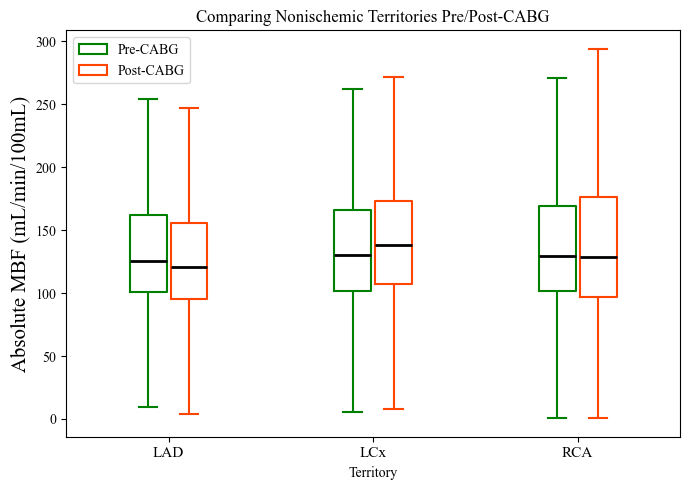

In [113]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x='Territory', y='MBF', hue='Type', data= df_long, showfliers=False, width = 0.4, fill= False, gap=.1, palette={'Pre-CABG':'green', 'Post-CABG':'orangered'}, medianprops={"color": "k", "linewidth": 2})

ax.set_ylabel("Absolute MBF (mL/min/100mL)", fontsize = 15)
ax.tick_params(axis='x', rotation=0, labelsize=11)
plt.title("Comparing Nonischemic Territories Pre/Post-CABG")
ax.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

# Bland Altman plot of Hypoperfusion Pre/Post-CABG

In [114]:
for file in MappedVTUFiles:
    if f"SU03A" in os.path.basename(os.path.splitext(file)[0]):
        MBF_A = ReadVTUFile(file)
    elif f"SU03B" in os.path.basename(os.path.splitext(file)[0]):
        MBF_B = ReadVTUFile(file)

ScalarArray_A_Name = "ImageScalars"

ScalarArray_A = vtk_to_numpy(MBF_A.GetPointData().GetArray(MappedScalarArrayName))#ScalarArray_A_Name))#
IndexMBF_A = ScalarArray_A/np.percentile(ScalarArray_A, 75)

IschemicMask_A = IndexMBF_A < 0.5

print(len(IschemicMask_A[IschemicMask_A == 1])/len(IndexMBF_A))


ScalarArray_B_Name = "scalars"

ScalarArray_B = vtk_to_numpy(MBF_B.GetPointData().GetArray(ScalarArray_B_Name))
IndexMBF_B = ScalarArray_B/np.percentile(ScalarArray_B, 75)

IschemicMask_B = IndexMBF_B < 0.5

print(len(IschemicMask_B[IschemicMask_B == 1])/len(IndexMBF_B))

0.32645416418867257
0.07666230359323742


In [115]:
IschemicCount_A_Ischemic = []
IschemicCount_B_Ischemic = []

IschemicCount_A_nonIschemic = []
IschemicCount_B_nonIschemic = []

for patient_id in patient_ids:
    if patient_id in Removed_Cases: 
        continue

    for file in MappedVTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = ReadVTUFile(file)
        elif f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = ReadVTUFile(file)

    ScalarArray_A_Name = "ImageScalars"

    ScalarArray_A = vtk_to_numpy(MBF_A.GetPointData().GetArray(MappedScalarArrayName))#ScalarArray_A_Name))#
    IndexMBF_A = ScalarArray_A/np.percentile(ScalarArray_A, 75)

    IschemicMask_A = IndexMBF_A < 0.6



    ScalarArray_B_Name = "scalars"

    ScalarArray_B = vtk_to_numpy(MBF_B.GetPointData().GetArray(ScalarArray_B_Name))
    IndexMBF_B = ScalarArray_B/np.percentile(ScalarArray_B, 75)

    IschemicMask_B = IndexMBF_B < 0.6


    ischemia_presence = list(df[df["patient_id"] == patient_id]["is_ischemic"])
    is_ischemic = any(ischemia_presence)


    if is_ischemic:
        IschemicCount_A_Ischemic.append(len(IschemicMask_A[IschemicMask_A == 1])/len(IndexMBF_A))
        IschemicCount_B_Ischemic.append(len(IschemicMask_B[IschemicMask_B == 1])/len(IndexMBF_B))
    else:
        IschemicCount_A_nonIschemic.append(len(IschemicMask_A[IschemicMask_A == 1])/len(IndexMBF_A))
        IschemicCount_B_nonIschemic.append(len(IschemicMask_B[IschemicMask_B == 1])/len(IndexMBF_B))

In [116]:
IschemicCount_A_Ischemic = np.array(IschemicCount_A_Ischemic)
IschemicCount_B_Ischemic = np.array(IschemicCount_B_Ischemic)


IschemicCount_A_nonIschemic = np.array(IschemicCount_A_nonIschemic)
IschemicCount_B_nonIschemic = np.array(IschemicCount_B_nonIschemic)

IschemicCount_A = np.concatenate((IschemicCount_A_Ischemic, IschemicCount_A_nonIschemic), axis = 0)
IschemicCount_B = np.concatenate((IschemicCount_B_Ischemic, IschemicCount_B_nonIschemic), axis = 0)

In [117]:
print(IschemicCount_A_Ischemic)
print(IschemicCount_B_Ischemic)

diff_Ischemic = IschemicCount_B_Ischemic - IschemicCount_A_Ischemic
print(diff_Ischemic)

print(IschemicCount_A_nonIschemic)
print(IschemicCount_B_nonIschemic)
diff_nonIschemic = IschemicCount_B_nonIschemic - IschemicCount_A_nonIschemic
print(diff_nonIschemic)

[0.39762537 0.23669972 0.31695661 0.35502012 0.30530638 0.36221841
 0.35684641 0.14168354 0.32319637 0.23844062 0.24421266 0.31294413
 0.11114871 0.08839922 0.26254482 0.27547439 0.51452343]
[0.15494387 0.09452786 0.14789682 0.35595613 0.09215062 0.20168224
 0.24002338 0.19505811 0.17716708 0.15118526 0.18856706 0.24034989
 0.07854484 0.07579384 0.23247605 0.21336432 0.17642026]
[-0.2426815  -0.14217186 -0.16905978  0.00093601 -0.21315576 -0.16053617
 -0.11682303  0.05337458 -0.14602929 -0.08725535 -0.0556456  -0.07259424
 -0.03260387 -0.01260538 -0.03006877 -0.06211008 -0.33810317]
[0.16924792 0.0637397  0.13429603 0.19555996 0.14242262 0.13231908
 0.36675317 0.23239985 0.08024011]
[0.10291316 0.24002338 0.17719563 0.17398025 0.14025264 0.17078851
 0.41116318 0.20687125 0.18378395]
[-0.06633476  0.17628368  0.0428996  -0.02157971 -0.00216998  0.03846943
  0.04441001 -0.0255286   0.10354383]


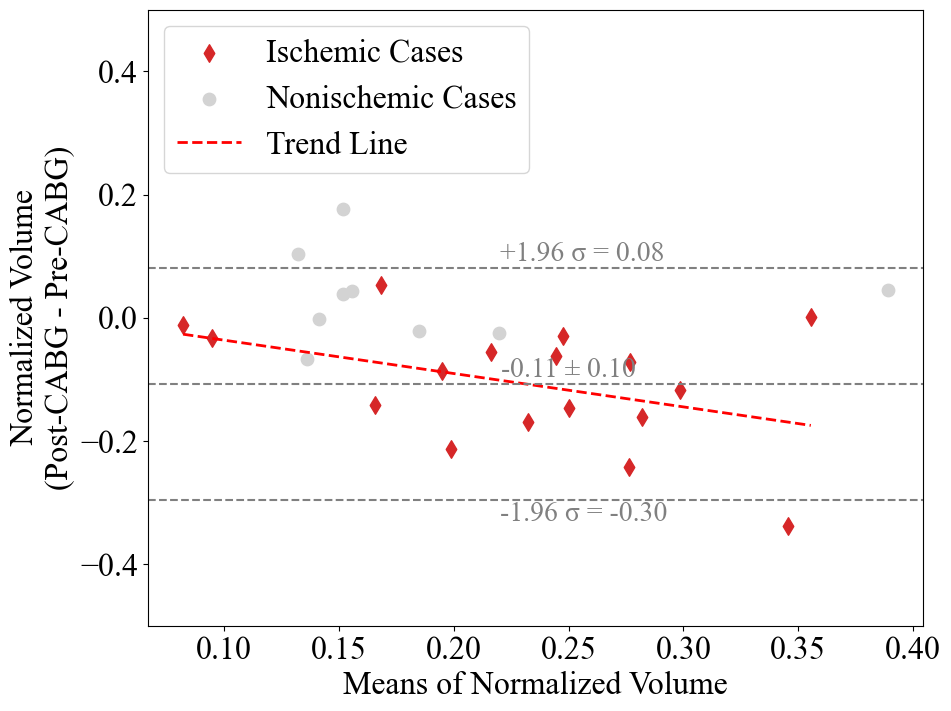

In [118]:
mean_Ischemic =  np.mean([IschemicCount_A_Ischemic, IschemicCount_B_Ischemic], axis=0)
diff_Ischemic = IschemicCount_B_Ischemic - IschemicCount_A_Ischemic

mean_nonIschemic =  np.mean([IschemicCount_A_nonIschemic, IschemicCount_B_nonIschemic], axis=0)
diff_nonIschemic = IschemicCount_B_nonIschemic - IschemicCount_A_nonIschemic

A = np.asarray(IschemicCount_A_Ischemic)
B = np.asarray(IschemicCount_B_Ischemic)
mean = np.mean([A, B], axis = 0)
diff = B - A
md = np.mean(diff) # Mean of difference
sd = np.std(diff, axis = 0) #standard deviation of difference


x_fit = np.linspace(min(mean), max(mean), 100)
slope, intercept, _, _, _ = linregress(mean, diff)
y_fit = slope * x_fit + intercept

plt.figure(figsize=(10,8), dpi=100)

plt.scatter(mean_Ischemic, diff_Ischemic, label="Ischemic Cases", color="tab:red", marker= "d", s = 80)
plt.scatter(mean_nonIschemic, diff_nonIschemic, label="Nonischemic Cases", color="lightgray", marker= "o", s = 80)

plt.plot(x_fit, y_fit, 'r--', linewidth = 2, label="Trend Line")

loa_upper = md + 1.96*sd
loa_lower = md - 1.96*sd

plt.text(0.22, loa_upper + 0.002, f'+1.96 σ = {loa_upper:.2f}', color='gray', va='bottom', fontsize = 20)
plt.text(0.22, loa_lower - 0.002, f'-1.96 σ = {loa_lower:.2f}', color='gray', va='top',  fontsize = 20)
plt.text(0.22, md + 0.002, f'{md:.2f} $\pm$ {sd:.2f}', color='gray', va='bottom',  fontsize = 20)


plt.axhline(md, color='gray', linestyle='--')
plt.axhline(loa_upper, color='gray', linestyle='--')
plt.axhline(loa_lower, color='gray', linestyle='--')
plt.xlabel("Means of Normalized Volume", fontdict=font1)
plt.ylabel("Normalized Volume\n(Post-CABG - Pre-CABG)", fontdict=font1)
plt.xticks(fontsize = 23)
plt.yticks(fontsize = 23)
plt.ylim((-0.5,0.5))
plt.legend(loc='upper left', fontsize = 23)
#plt.title("< 0.5")
plt.show()

# Histogram of Volume In Ischemic and non Ischemic Cases


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


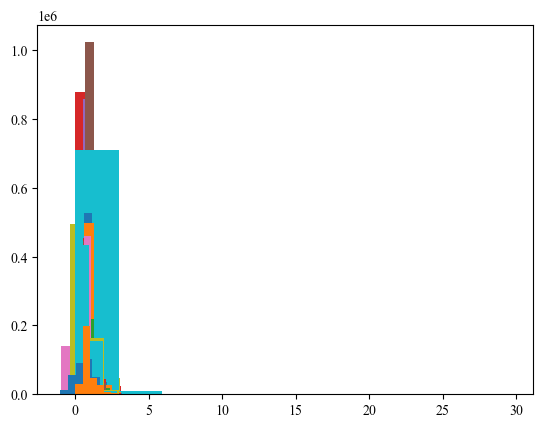

In [119]:
ScalarArray_A_Agg_Ischemic = np.zeros((1,10))[0]
ScalarArray_B_Agg_Ischemic = np.zeros((1,10))[0]

print(ScalarArray_A_Agg_Ischemic)

ScalarArray_A_Agg_Nonischemic = []
ScalarArray_B_Agg_Nonischemic = []

bins_A_Ischemic = []
bins_B_Ischemic = []

bins_A_Nonischemic = []
bins_B_Nonischemic = []

for patient_id in patient_ids:
    if patient_id in Removed_Cases: 
        continue
    #print(patient_id)

    """for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file"""

    for file in MappedVTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = ReadVTUFile(file)
    for file in VTUFiles:#MappedVTUFiles:#
        if f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = ReadVTUFile(file)
    
    for i in range(MBF_A.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF_A.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ScalarArray_A_Name = arrayname_
    
    for i in range(MBF_B.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF_B.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ScalarArray_B_Name = arrayname_
    
    MappedScalarArrayName = "MappedScalar"
    ScalarArray_A = vtk_to_numpy(MBF_A.GetPointData().GetArray(MappedScalarArrayName))#ScalarArray_A_Name))#
    ScalarArray_A_ = ScalarArray_A/np.percentile(ScalarArray_A, 75)
    ScalarArray_B = vtk_to_numpy(MBF_B.GetPointData().GetArray(ScalarArray_B_Name))
    ScalarArray_B_ = ScalarArray_B/np.percentile(ScalarArray_B, 75)
    
    bounds = [0.0] * 6
    MBF_A.GetCellBounds(0,bounds)
    volume_A = (bounds[1]-bounds[0]) * (bounds[3]-bounds[2]) * (bounds[5]-bounds[4])

    MBF_B.GetCellBounds(0,bounds)
    volume_B = (bounds[1]-bounds[0]) * (bounds[3]-bounds[2]) * (bounds[5]-bounds[4])
    if patient_id == "SU03":
        volume_A /= 1000
        volume_B /= 1000


    n, bins_A, _ = plt.hist(ScalarArray_A_, bins = 10)
    VolumeArray_A = n*volume_A

    n, bins_B, _ = plt.hist(ScalarArray_B_, bins = 10)
    VolumeArray_B = n*volume_B


    ischemia_presence = list(df[df["patient_id"] == patient_id]["is_ischemic"])
    is_ischemic = any(ischemia_presence)


    if is_ischemic:
        ScalarArray_A_Agg_Ischemic += VolumeArray_A
        ScalarArray_B_Agg_Ischemic += VolumeArray_B
        #bins_A_Ischemic.append(bins_A[:-1])
        #bins_B_Ischemic.append(bins_B[:-1])

    #else:
        #ScalarArray_A_Agg_Nonischemic.append(VolumeArray_A)
        #ScalarArray_B_Agg_Nonischemic.append(VolumeArray_B)
        #bins_A_Nonischemic.append(bins_A[:-1])
        #bins_B_Nonischemic.append(bins_B[:-1])



'\nx_fit_A = np.linspace(min(x1), max(x1), 100)\nspl = make_interp_spline(x1, y1, k=3)\ny_fit_A = spl(x_fit_A)\n\nx_fit_B = np.linspace(min(x2), max(x2), 100)\nspl = make_interp_spline(x2, y2, k=3)\ny_fit_B = spl(x_fit_B)\n\n\nplt.figure(figsize=(8,6))\nplt.plot(x_fit_A, y_fit_A, color="mediumseagreen", label="Pre-CABG")\nplt.plot(x_fit_B, y_fit_B, color="crimson", label="Post-CABG")\nplt.legend()\n'

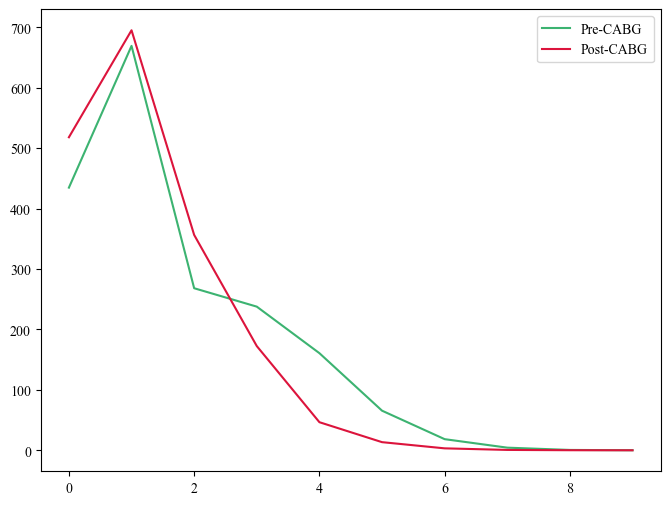

In [120]:
"""x1 = np.sort(np.concatenate(bins_A_Ischemic))
x2 = np.sort(np.concatenate(bins_B_Ischemic))

y1 = np.sort(np.concatenate(ScalarArray_A_Agg_Ischemic))
y2 = np.sort(np.concatenate(ScalarArray_B_Agg_Ischemic))
"""
plt.figure(figsize=(8,6))
plt.plot(ScalarArray_A_Agg_Ischemic, color="mediumseagreen", label="Pre-CABG")
plt.plot(ScalarArray_B_Agg_Ischemic, color="crimson", label="Post-CABG")
plt.legend()

'''
x_fit_A = np.linspace(min(x1), max(x1), 100)
spl = make_interp_spline(x1, y1, k=3)
y_fit_A = spl(x_fit_A)

x_fit_B = np.linspace(min(x2), max(x2), 100)
spl = make_interp_spline(x2, y2, k=3)
y_fit_B = spl(x_fit_B)


plt.figure(figsize=(8,6))
plt.plot(x_fit_A, y_fit_A, color="mediumseagreen", label="Pre-CABG")
plt.plot(x_fit_B, y_fit_B, color="crimson", label="Post-CABG")
plt.legend()
'''

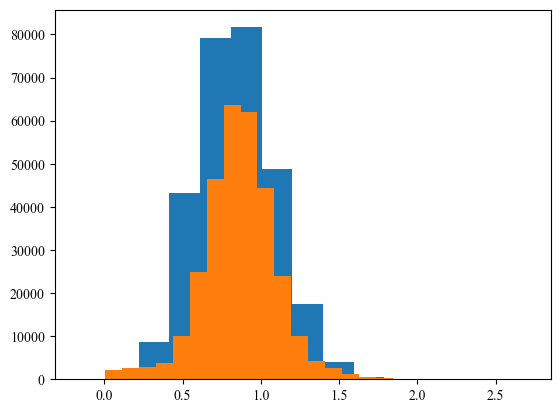

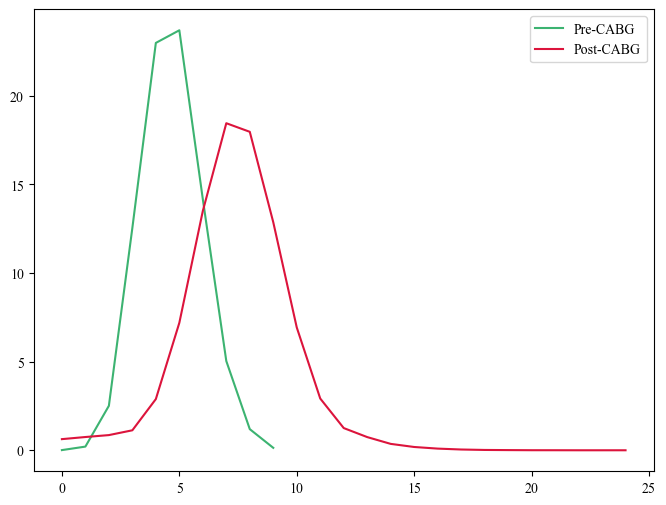

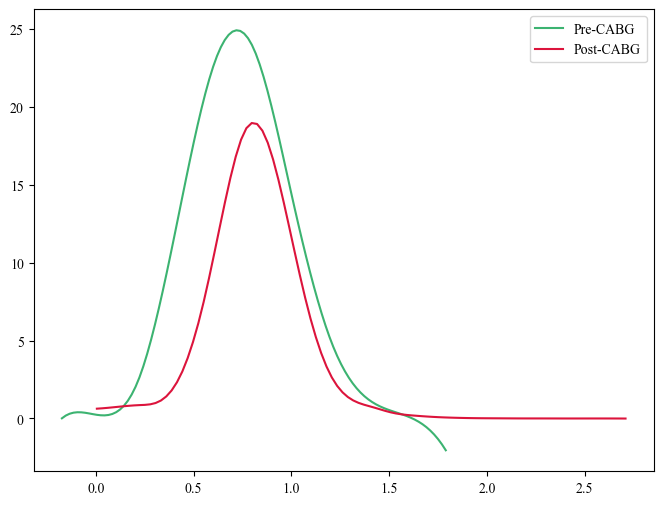

In [121]:
for file in MappedVTUFiles:
    if "SU06A" in os.path.basename(os.path.splitext(file)[0]):
        MBF_A = ReadVTUFile(file)
    elif "SU06B" in os.path.basename(os.path.splitext(file)[0]):
        MBF_B = ReadVTUFile(file)


bounds = [0.0] * 6
#print(MBF_A.GetBounds())
MBF_A.GetCellBounds(0,bounds)
#print(bounds)
volume_A = (bounds[1]-bounds[0]) * (bounds[3]-bounds[2]) * (bounds[5]-bounds[4])
#print(volume_A)


ScalarArray_A_Name = "ImageScalars"

ScalarArray_A = vtk_to_numpy(MBF_A.GetPointData().GetArray(MappedScalarArrayName))#ScalarArray_A_Name))#
ScalarArray_A_ = ScalarArray_A/np.percentile(ScalarArray_A, 75)

n, bins_A, _ = plt.hist(ScalarArray_A_, bins = 10)

#print("n=",n)
VolumeArray_A = n*volume_A
#print(VolumeArray_A)

bounds = [0.0] * 6
#print(MBF_B.GetBounds())
MBF_B.GetCellBounds(0,bounds)
#print(bounds)
volume_B = (bounds[1]-bounds[0]) * (bounds[3]-bounds[2]) * (bounds[5]-bounds[4])
#print(volume_B)

ScalarArray_B_Name = "scalars"

ScalarArray_B = vtk_to_numpy(MBF_B.GetPointData().GetArray(ScalarArray_B_Name))#MappedScalarArrayName))
ScalarArray_B_ = ScalarArray_B/np.percentile(ScalarArray_B, 75)

n, bins_B, _ = plt.hist(ScalarArray_B_, bins = 25)

#print("n=",n)
VolumeArray_B = n*volume_B
#print(VolumeArray_B)



plt.figure(figsize=(8,6))
plt.plot(VolumeArray_A, color="mediumseagreen", label="Pre-CABG")
plt.plot(VolumeArray_B, color="crimson", label="Post-CABG")
plt.legend()


#interpolation
x_fit_A = np.linspace(min(bins_A), max(bins_A), 100)
spl = make_interp_spline(bins_A[:-1], VolumeArray_A, k=3)
y_fit_A = spl(x_fit_A)

x_fit_B = np.linspace(min(bins_B), max(bins_B), 100)
spl = make_interp_spline(bins_B[:-1], VolumeArray_B, k=3)
y_fit_B = spl(x_fit_B)


plt.figure(figsize=(8,6))
plt.plot(x_fit_A, y_fit_A, color="mediumseagreen", label="Pre-CABG")
plt.plot(x_fit_B, y_fit_B, color="crimson", label="Post-CABG")
plt.legend()

# CDF of percentage diviation

## Only Ischemic Regions

In [122]:
PercentDiviation_A = np.array([])
PercentDiviation_B = np.array([])

for patient_id in patient_ids:
    if patient_id in Removed_Cases: 
        continue
    ischemia_presence = list(df[df["patient_id"] == patient_id]["is_ischemic"])
    is_ischemic = any(ischemia_presence)


    if is_ischemic:
        ScalarArray_A = np.concatenate(df[(df["patient_id"] == patient_id) & (df["is_ischemic"] == True)]["absMBF_A"].values)
        
        ScalarArray_B = np.concatenate(df[(df["patient_id"] == patient_id) & (df["is_ischemic"] == True)]["absMBF_B"].values)

        RemoteMedian_A = np.percentile(np.concatenate(df[(df["patient_id"] == patient_id) & (df["tag"] == "Nongrafted")]["absMBF_A"].values), 75)
        RemoteMedian_B = np.percentile(np.concatenate(df[(df["patient_id"] == patient_id) & (df["tag"] == "Nongrafted")]["absMBF_B"].values), 75)
    
        PercentDiviation_A = np.append(PercentDiviation_A, (ScalarArray_A)/RemoteMedian_A)
        PercentDiviation_B = np.append(PercentDiviation_B, (ScalarArray_B)/RemoteMedian_B)

In [123]:
def cumdist(Array, threshold):
    array = np.sort(Array)
    cdf = np.arange(1, len(array) + 1)/len(array) * 100
    idx = np.searchsorted(array, threshold, side='right') - 1
    cdf_at_threshold = cdf[idx] if idx >= 0 else 0

    x = array[array < threshold]
    y = cdf[array < threshold]
    AUC = np.trapz(y,x)
    
    return array, cdf, cdf_at_threshold, AUC

/var/folders/pd/rks0rhrj499g669rkntv95y40000gn/T/ipykernel_9365/3788880067.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  AUC = np.trapz(y,x)


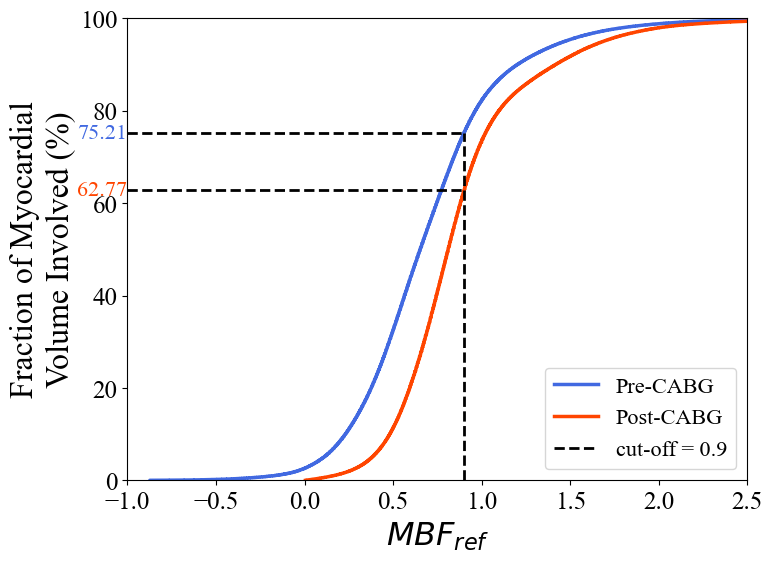

In [127]:
threshold = 0.9

array_A, cdf_A, cdf_threshold_A, AUC_ischemic_A = cumdist(PercentDiviation_A, threshold)
array_B, cdf_B, cdf_threshold_B, AUC_ischemic_B = cumdist(PercentDiviation_B, threshold)



plt.figure(figsize=(8, 6))
plt.plot(array_A, cdf_A, color = color1, linewidth = 2.5, label = "Pre-CABG")
plt.plot(array_B, cdf_B, color = color2, linewidth = 2.5, label = "Post-CABG")
plt.plot([threshold, threshold], [0, max(cdf_threshold_A, cdf_threshold_B)], 'k--', linewidth = 2, label = f"cut-off = {threshold}")
plt.plot([-1, threshold], [cdf_threshold_A, cdf_threshold_A], "k--", linewidth = 2)
plt.plot([-1, threshold], [cdf_threshold_B, cdf_threshold_B], "k--", linewidth = 2)


plt.text(-1.0, cdf_threshold_A, f"{int(cdf_threshold_A*100)/100}", ha="right", va="center", transform=plt.gca().transData, fontsize = 16, color = color1)
plt.text(-1.0, cdf_threshold_B, f"{int(cdf_threshold_B*100)/100}", ha="right", va="center", transform=plt.gca().transData, fontsize = 16, color = color2)
#plt.text(threshold, -1, f"{threshold}", ha="right", va="center", transform=plt.gca().transdata, fontsize = 16, color = 'blue')

#plt.fill_between(x_AUC_A, y_AUC_A, color = 'lightgreen', alpha = 0.4, label= f"AUC Pre-CABG = {int(AUC_ischemic_A*100)/100}")
#plt.fill_between(x_AUC_B, y_AUC_B, color = 'coral', alpha = 0.4, label= f"AUC Post-CABG = {int(AUC_ischemic_B*100)/100}")

plt.xlim(-1, 2.5)
plt.ylim(0, 100)
#plt.title("Ischemic Cases (>10% drop)")
plt.xlabel("$MBF_{ref}$", fontdict = font1)
plt.ylabel("Fraction of Myocardial\nVolume Involved (%)", fontdict = font1)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(loc = "lower right", fontsize = 16)
plt.show()

In [128]:
Array_A = np.array([])
Array_B = np.array([])

for patient_id in patient_ids:
    if patient_id in Removed_Cases: 
        continue
    ischemia_presence = list(df[df["patient_id"] == patient_id]["is_ischemic"])
    is_ischemic = any(ischemia_presence)


    if is_ischemic:
        ScalarArray_A = np.concatenate(df[(df["patient_id"] == patient_id) & (df["is_ischemic"] == True)]["absMBF_A"].values)
        
        ScalarArray_B = np.concatenate(df[(df["patient_id"] == patient_id) & (df["is_ischemic"] == True)]["absMBF_B"].values)

        RemoteMedian_A = np.percentile(np.concatenate(df[(df["patient_id"] == patient_id) & (df["tag"] == "Nongrafted")]["absMBF_A"].values), 75)
        RemoteMedian_B = np.percentile(np.concatenate(df[(df["patient_id"] == patient_id) & (df["tag"] == "Nongrafted")]["absMBF_B"].values), 75)

        IndexMBF_A = ScalarArray_A/RemoteMedian_A
        IschemicMask_A = IndexMBF_A < threshold

        IndexMBF_B = ScalarArray_B/RemoteMedian_B
        IschemicMask_B = IndexMBF_B < threshold
        

        Array_A = np.append(Array_A, len(IschemicMask_A[IschemicMask_A == 1])/len(IndexMBF_A)*100)
        Array_B = np.append(Array_B, len(IschemicMask_B[IschemicMask_B == 1])/len(IndexMBF_B)*100)

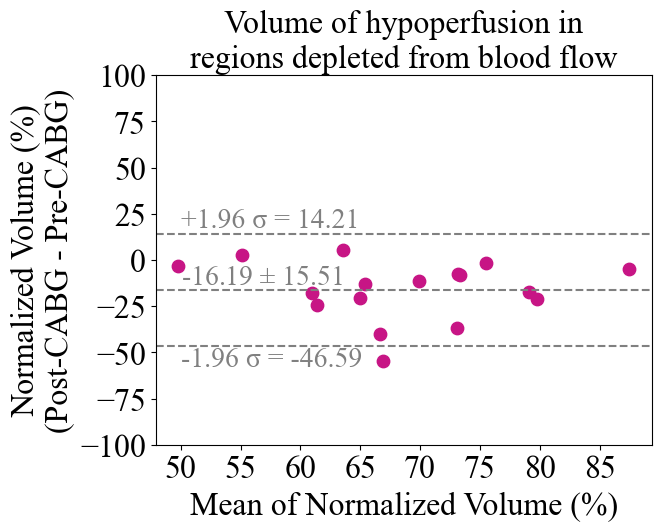

In [130]:
mean = np.mean([Array_A, Array_B], axis = 0)
diff = Array_B - Array_A
md = np.mean(diff) # Mean of difference
sd = np.std(diff, axis = 0) #standard deviation of difference

plt.scatter(mean, diff, color="mediumvioletred", s = 80)

loa_upper = md + 1.96*sd
loa_lower = md - 1.96*sd

plt.text(50, loa_upper + 0.002, f'+1.96 σ = {loa_upper:.2f}', color='gray', va='bottom', fontsize = 20)
plt.text(50, loa_lower - 0.002, f'-1.96 σ = {loa_lower:.2f}', color='gray', va='top',  fontsize = 20)
plt.text(50, md + 0.002, f'{md:.2f} $\pm$ {sd:.2f}', color='gray', va='bottom',  fontsize = 20)

plt.axhline(md, color='gray', linestyle='--')
plt.axhline(loa_upper, color='gray', linestyle='--')
plt.axhline(loa_lower, color='gray', linestyle='--')
plt.xlabel("Mean of Normalized Volume (%)", fontdict=font1)
plt.ylabel("Normalized Volume (%)\n(Post-CABG - Pre-CABG)", fontdict=font1)
plt.xticks(fontsize = 23)
plt.yticks(fontsize = 23)
plt.ylim((-100,100))
#plt.legend(loc='upper left', fontsize = 23)
plt.title("Volume of hypoperfusion in\nregions depleted from blood flow", fontdict = font1)
plt.show()


## Grafted Regions

In [131]:
PercentDiviation_A = np.array([])
PercentDiviation_B = np.array([])

for patient_id in patient_ids:
    if patient_id in Removed_Cases: 
        continue

    if df[(df["patient_id"] == patient_id) & (df["tag"] != "Nongrafted") & (df['tag'] != "Nongrafted-Stenosis") & (df["is_ischemic"] == False)]["absMBF_A"].empty:
        continue
    ScalarArray_A = np.concatenate(df[(df["patient_id"] == patient_id) & (df["tag"] != "Nongrafted") & (df['tag'] != "Nongrafted-Stenosis") & (df["is_ischemic"] == False)]["absMBF_A"].values)
    
    ScalarArray_B = np.concatenate(df[(df["patient_id"] == patient_id) & (df["tag"] != "Nongrafted") & (df['tag'] != "Nongrafted-Stenosis") & (df["is_ischemic"] == False)]["absMBF_B"].values)

    RemoteMedian_A = np.percentile(np.concatenate(df[(df["patient_id"] == patient_id) & (df["tag"] == "Nongrafted")]["absMBF_A"].values), 75)
    RemoteMedian_B = np.percentile(np.concatenate(df[(df["patient_id"] == patient_id) & (df["tag"] == "Nongrafted")]["absMBF_B"].values), 75)

    PercentDiviation_A = np.append(PercentDiviation_A, (ScalarArray_A)/RemoteMedian_A)
    PercentDiviation_B = np.append(PercentDiviation_B, (ScalarArray_B)/RemoteMedian_B)

/var/folders/pd/rks0rhrj499g669rkntv95y40000gn/T/ipykernel_9365/3788880067.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  AUC = np.trapz(y,x)


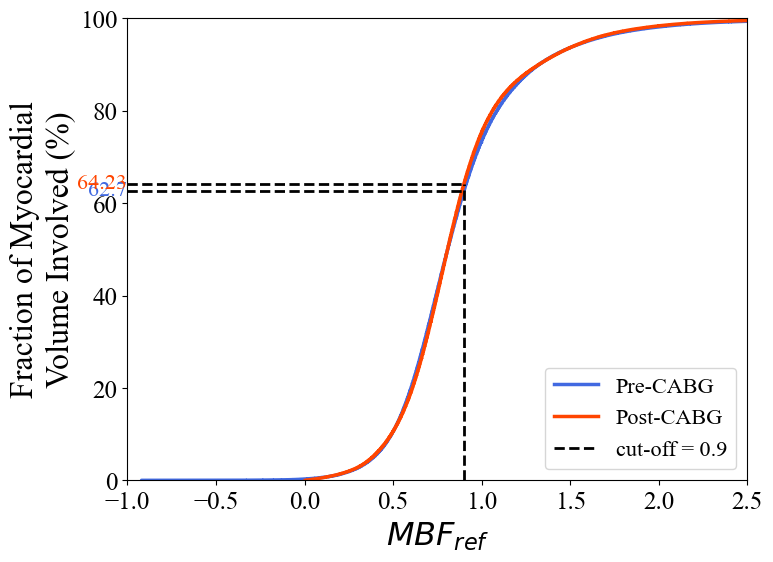

In [133]:
threshold = 0.9

array_A, cdf_A, cdf_threshold_A, AUC_ischemic_A = cumdist(PercentDiviation_A, threshold)
array_B, cdf_B, cdf_threshold_B, AUC_ischemic_B = cumdist(PercentDiviation_B, threshold)



plt.figure(figsize=(8, 6))
plt.plot(array_A, cdf_A, color = color1, linewidth = 2.5, label = "Pre-CABG")
plt.plot(array_B, cdf_B, color = color2, linewidth = 2.5, label = "Post-CABG")
plt.plot([threshold, threshold], [0, max(cdf_threshold_A, cdf_threshold_B)], 'k--', linewidth = 2, label = f"cut-off = {threshold}")
plt.plot([-1, threshold], [cdf_threshold_A, cdf_threshold_A], "k--", linewidth = 2)
plt.plot([-1, threshold], [cdf_threshold_B, cdf_threshold_B], "k--", linewidth = 2)


plt.text(-1.0, cdf_threshold_A, f"{int(cdf_threshold_A*100)/100}", ha="right", va="center", transform=plt.gca().transData, fontsize = 16, color = color1)
plt.text(-1.0, cdf_threshold_B, f"{int(cdf_threshold_B*100)/100}", ha="right", va="center", transform=plt.gca().transData, fontsize = 16, color = color2)
#plt.text(threshold, -1, f"{threshold}", ha="right", va="center", transform=plt.gca().transdata, fontsize = 16, color = 'blue')

#plt.fill_between(x_AUC_A, y_AUC_A, color = 'lightgreen', alpha = 0.4, label= f"AUC Pre-CABG = {int(AUC_ischemic_A*100)/100}")
#plt.fill_between(x_AUC_B, y_AUC_B, color = 'coral', alpha = 0.4, label= f"AUC Post-CABG = {int(AUC_ischemic_B*100)/100}")

plt.xlim(-1, 2.5)
plt.ylim(0, 100)
#plt.title("Ischemic Cases (>10% drop)")
plt.xlabel("$MBF_{ref}$", fontdict = font1)
plt.ylabel("Fraction of Myocardial\nVolume Involved (%)", fontdict = font1)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.legend(loc = "lower right", fontsize = 16)
plt.show()

In [134]:
Array_A = np.array([])
Array_B = np.array([])

for patient_id in patient_ids:
    if patient_id in Removed_Cases: 
        continue

    if df[(df["patient_id"] == patient_id) & (df["tag"] != "Nongrafted") & (df['tag'] != "Nongrafted-Stenosis") & (df["is_ischemic"] == False)]["absMBF_A"].empty:
        continue

    ScalarArray_A = np.concatenate(df[(df["patient_id"] == patient_id) & (df["tag"] != "Nongrafted") & (df['tag'] != "Nongrafted-Stenosis") & (df["is_ischemic"] == False)]["absMBF_A"].values)
    
    ScalarArray_B = np.concatenate(df[(df["patient_id"] == patient_id) & (df["tag"] != "Nongrafted") & (df['tag'] != "Nongrafted-Stenosis") & (df["is_ischemic"] == False)]["absMBF_B"].values)

    RemoteMedian_A = np.percentile(np.concatenate(df[(df["patient_id"] == patient_id) & (df["tag"] == "Nongrafted")]["absMBF_A"].values), 75)
    RemoteMedian_B = np.percentile(np.concatenate(df[(df["patient_id"] == patient_id) & (df["tag"] == "Nongrafted")]["absMBF_B"].values), 75)

    IndexMBF_A = ScalarArray_A/RemoteMedian_A
    IschemicMask_A = IndexMBF_A < threshold

    IndexMBF_B = ScalarArray_B/RemoteMedian_B
    IschemicMask_B = IndexMBF_B < threshold
    

    Array_A = np.append(Array_A, len(IschemicMask_A[IschemicMask_A == 1])/len(IndexMBF_A)*100)
    Array_B = np.append(Array_B, len(IschemicMask_B[IschemicMask_B == 1])/len(IndexMBF_B)*100)

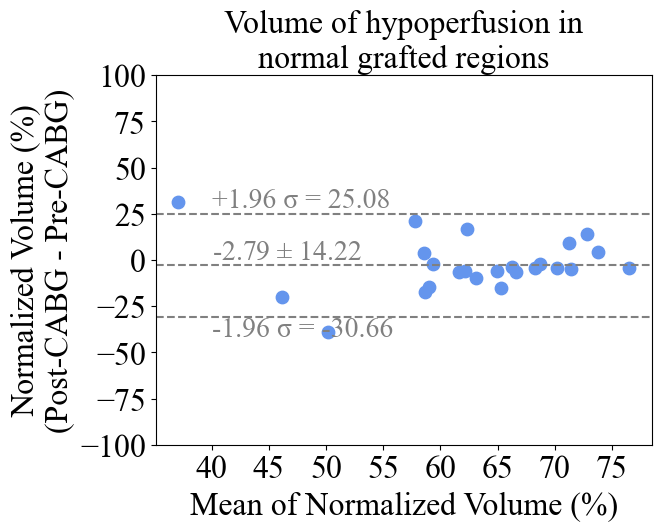

In [136]:


mean = np.mean([Array_A, Array_B], axis = 0)
diff = Array_B - Array_A
md = np.mean(diff) # Mean of difference
sd = np.std(diff, axis = 0) #standard deviation of difference

plt.scatter(mean, diff, color="cornflowerblue", s = 80)

loa_upper = md + 1.96*sd
loa_lower = md - 1.96*sd

plt.text(40, loa_upper + 0.002, f'+1.96 σ = {loa_upper:.2f}', color='gray', va='bottom', fontsize = 20)
plt.text(40, loa_lower - 0.002, f'-1.96 σ = {loa_lower:.2f}', color='gray', va='top',  fontsize = 20)
plt.text(40, md + 0.002, f'{md:.2f} $\pm$ {sd:.2f}', color='gray', va='bottom',  fontsize = 20)

plt.axhline(md, color='gray', linestyle='--')
plt.axhline(loa_upper, color='gray', linestyle='--')
plt.axhline(loa_lower, color='gray', linestyle='--')
plt.xlabel("Mean of Normalized Volume (%)", fontdict=font1)
plt.ylabel("Normalized Volume (%)\n(Post-CABG - Pre-CABG)", fontdict=font1)
plt.xticks(fontsize = 23)
plt.yticks(fontsize = 23)
plt.ylim((-100,100))
#plt.legend(loc='upper left', fontsize = 23)
plt.title("Volume of hypoperfusion in\nnormal grafted regions", fontdict = font1)
plt.show()


# Cumulative Distribution Function

to do:
 - Add area under the curve below the threshold
 - Add statistical test for comparing the distributions (?)

In [ ]:
def cumdist(Array):
    array = np.sort(Array)
    threshold = 0.8 
    cdf = np.arange(1, len(array) + 1)/len(array) * 100
    idx = np.searchsorted(array, threshold, side='right') - 1
    cdf_at_threshold = cdf[idx] if idx >= 0 else 0

    x = array[array < threshold]
    y = cdf[array < threshold]
    AUC = np.trapz(y,x)
    
    return array, cdf, threshold, cdf_at_threshold, AUC

In [ ]:
def pdf(Array):
    array = np.sort(Array)
    pdf_values = norm.pdf(array)

    return array, pdf_values


In [ ]:
for patient_id in patient_ids:
    if patient_id in Removed_Cases: 
        continue

    ischemia_presence = list(df[df["patient_id"] == patient_id]["is_ischemic"])
    is_ischemic = any(ischemia_presence)

    if is_ischemic:
        print(patient_id)

In [ ]:
print(Removed_Cases)

In [ ]:
ScalarArray_A_Agg_Ischemic = []
ScalarArray_B_Agg_Ischemic = []

ScalarArray_A_Agg_Nonischemic = []
ScalarArray_B_Agg_Nonischemic = []

refMBF = []

for patient_id in patient_ids:
    if patient_id in Removed_Cases: 
        continue
    #print(patient_id)

    """for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file"""

    for file in MappedVTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = ReadVTUFile(file)
    for file in VTUFiles:#MappedVTUFiles:#
        if f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = ReadVTUFile(file)
    
    for i in range(MBF_A.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF_A.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ScalarArray_A_Name = arrayname_
    
    for i in range(MBF_B.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF_B.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ScalarArray_B_Name = arrayname_
    
    MappedScalarArrayName = "MappedScalar"
    ScalarArray_A = vtk_to_numpy(MBF_A.GetPointData().GetArray(MappedScalarArrayName))#ScalarArray_A_Name))#
    ScalarArray_A_ = ScalarArray_A/np.percentile(ScalarArray_A, 75)
    ScalarArray_B = vtk_to_numpy(MBF_B.GetPointData().GetArray(ScalarArray_B_Name))
    ScalarArray_B_ = ScalarArray_B/np.percentile(ScalarArray_B, 75)
    refMBF.append({
        "patient_id": patient_id,
        "ref_A": np.percentile(ScalarArray_A, 75),
        "ref_B": np.percentile(ScalarArray_B, 75)
    })

    ischemia_presence = list(df[df["patient_id"] == patient_id]["is_ischemic"])
    is_ischemic = any(ischemia_presence)


    if is_ischemic:
        ScalarArray_A_Agg_Ischemic.append(ScalarArray_A_)
        ScalarArray_B_Agg_Ischemic.append(ScalarArray_B_)
    else:
        ScalarArray_A_Agg_Nonischemic.append(ScalarArray_A_)
        ScalarArray_B_Agg_Nonischemic.append(ScalarArray_B_)



In [ ]:
array_A, pdf_A = pdf(np.concatenate(ScalarArray_A_Agg_Ischemic))
array_B, pdf_B = pdf(np.concatenate(ScalarArray_B_Agg_Ischemic))

plt.figure(figsize=(8,6))
plt.plot(array_A, pdf_A, color = "green", label = "Pre-CABG")
plt.plot(array_B, pdf_B, color = "orangered", label = "Post-CABG")
#plt.xlim([-3,3])
plt.xlabel("Index MBF", fontsize = 12)
plt.ylabel("Probability Distribution Function", fontsize = 12)
plt.legend()
plt.show()

In [ ]:
x1 = np.sort(np.concatenate(ScalarArray_A_Agg_Ischemic))
x2 = np.sort(np.concatenate(ScalarArray_B_Agg_Ischemic))
x1 = x1[x1<3]
x2 = x2[x2<3]
x = [x1, x2]

fig, ax = plt.subplots()
ax.hist(x, bins=16, color=["green", "orangered"], edgecolor = "black", label = ["Pre-CABG", "Post-CABG"])
plt.title("Ischemic Cases")
plt.legend()
plt.show()

In [ ]:
x1 = np.sort(np.concatenate(ScalarArray_A_Agg_Nonischemic))
x2 = np.sort(np.concatenate(ScalarArray_B_Agg_Nonischemic))
x1 = x1[x1<3]
x2 = x2[x2<3]
x = [x1, x2]

fig, ax = plt.subplots()
ax.hist(x, bins=16, color=["green", "orangered"], edgecolor = "black", label = ["Pre-CABG", "Post-CABG"])
plt.title("Nonischemic Cases")
plt.legend()
plt.show()

In [ ]:
array_A, cdf_A, threshold_A, cdf_threshold_A, AUC_ischemic_A = cumdist(np.concatenate(ScalarArray_A_Agg_Ischemic))
array_B, cdf_B, threshold_B, cdf_threshold_B, AUC_ischemic_B = cumdist(np.concatenate(ScalarArray_B_Agg_Ischemic))

x_AUC_A = array_A[array_A < threshold_A]
y_AUC_A = cdf_A[array_A < threshold_A]

x_AUC_B = array_B[array_B < threshold_B]
y_AUC_B = cdf_B[array_B < threshold_B]

plt.figure(figsize=(8, 6))
plt.plot(array_A, cdf_A, color = "green", label = "Pre-CABG")
plt.plot(array_B, cdf_B, color = "orangered", label = "Post-CABG")
plt.plot([0.8, 0.8], [0, max(cdf_threshold_A, cdf_threshold_B)], 'k--', label = "cut-off = 0.8")
plt.fill_between(x_AUC_A, y_AUC_A, color = 'lightgreen', alpha = 0.4, label= f"AUC Pre-CABG = {int(AUC_ischemic_A*100)/100}")
plt.fill_between(x_AUC_B, y_AUC_B, color = 'lightsalmon', alpha = 0.4, label= f"AUC Post-CABG = {int(AUC_ischemic_B*100)/100}")

#plt.xlim(-100, 500)
plt.xlim(0, 2)
plt.title("Ischemic Cases (>10% drop)")
plt.xlabel("Index MBF", fontsize = 12)
plt.ylabel("Cumulative Distribution Function (%)", fontsize = 12)
plt.legend()
plt.show()

In [ ]:
array_A, cdf_A, threshold_A, cdf_threshold_A, AUC_A = cumdist(np.concatenate(ScalarArray_A_Agg_Nonischemic))
array_B, cdf_B, threshold_B, cdf_threshold_B, AUC_B = cumdist(np.concatenate(ScalarArray_B_Agg_Nonischemic))

x_AUC_A = array_A[array_A < threshold_A]
y_AUC_A = cdf_A[array_A < threshold_A]

x_AUC_B = array_B[array_B < threshold_B]
y_AUC_B = cdf_B[array_B < threshold_B]

plt.figure(figsize=(8, 6))
plt.plot(array_A, cdf_A, color = "green", label = "Pre-CABG")
plt.plot(array_B, cdf_B, color = "orangered", label = "Post-CABG")
plt.plot([0.8, 0.8], [0, max(cdf_threshold_A, cdf_threshold_B)], 'k--', label = "cut-off = 0.8")
plt.fill_between(x_AUC_A, y_AUC_A, color = 'lightgreen', alpha = 0.4, label= f"AUC Pre-CABG = {int(AUC_A*100)/100}")
plt.fill_between(x_AUC_B, y_AUC_B, color = 'lightsalmon', alpha = 0.4, label= f"AUC Post-CABG = {int(AUC_B*100)/100}")


#plt.xlim(-100, 500)
plt.xlim(0, 2)
plt.title("Nonischemic Cases")
plt.xlabel("Index MBF", fontsize = 12)
plt.ylabel("Cumulative Distribution Function (%)", fontsize = 12)
plt.legend()
plt.show()

In [ ]:
ScalarArray_A_Agg_Ischemic3 = []
ScalarArray_B_Agg_Ischemic3 = []

ScalarArray_A_Agg_Ischemic2 = []
ScalarArray_B_Agg_Ischemic2 = []

ScalarArray_A_Agg_Nonischemic = []
ScalarArray_B_Agg_Nonischemic = []

refMBF = []

for patient_id in patient_ids:
    if patient_id in Removed_Cases: 
        continue
    #print(patient_id)

    """for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file"""

    for file in MappedVTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = ReadVTUFile(file)
    for file in VTUFiles:#MappedVTUFiles:#
        if f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = ReadVTUFile(file)
    
    for i in range(MBF_A.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF_A.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ScalarArray_A_Name = arrayname_
    
    for i in range(MBF_B.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF_B.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ScalarArray_B_Name = arrayname_
    
    MappedScalarArrayName = "MappedScalar"
    ScalarArray_A = vtk_to_numpy(MBF_A.GetPointData().GetArray(MappedScalarArrayName))#ScalarArray_A_Name))#
    ScalarArray_A_ = ScalarArray_A/np.percentile(ScalarArray_A, 75)
    ScalarArray_B = vtk_to_numpy(MBF_B.GetPointData().GetArray(ScalarArray_B_Name))
    ScalarArray_B_ = ScalarArray_B/np.percentile(ScalarArray_B, 75)
    refMBF.append({
        "patient_id": patient_id,
        "ref_A": np.percentile(ScalarArray_A, 75),
        "ref_B": np.percentile(ScalarArray_B, 75)
    })

    ischemic_grade = list(df[df["patient_id"] == patient_id]["ischemic_grade"])
    #is_ischemic = any(ischemia_presence)


    if 3 in ischemic_grade:
        ScalarArray_A_Agg_Ischemic3.append(ScalarArray_A_)
        ScalarArray_B_Agg_Ischemic3.append(ScalarArray_B_)
    elif 2 in ischemic_grade:
        ScalarArray_A_Agg_Ischemic2.append(ScalarArray_A_)
        ScalarArray_B_Agg_Ischemic2.append(ScalarArray_B_)



In [ ]:
x1 = np.sort(np.concatenate(ScalarArray_A_Agg_Ischemic3))
x2 = np.sort(np.concatenate(ScalarArray_B_Agg_Ischemic3))
x1 = x1[x1<3]
x2 = x2[x2<3]
x = [x1, x2]

fig, ax = plt.subplots()
ax.hist(x, bins=16, color=["green", "orangered"], edgecolor = "black", label = ["Pre-CABG", "Post-CABG"])
plt.title("Ischemic Cases (>30% drop)")
plt.legend()
plt.show()

In [ ]:
x1 = np.sort(np.concatenate(ScalarArray_A_Agg_Ischemic2))
x2 = np.sort(np.concatenate(ScalarArray_B_Agg_Ischemic2))
x1 = x1[x1<3]
x2 = x2[x2<3]
x = [x1, x2]

fig, ax = plt.subplots()
ax.hist(x, bins=16, color=["green", "orangered"], edgecolor = "black", label = ["Pre-CABG", "Post-CABG"])
plt.title("Ischemic Cases (20%<x<30% drop)")
plt.legend()
plt.show()

In [ ]:
refMBF = pd.DataFrame(refMBF)

ischemic_median_A = []
ischemic_median_B = []
nonischemic_median_A = []
nonischemic_median_B = []

nongrafted_median_A = []
nongrafted_median_B = []

grafted_median_A = []
grafted_median_B = []

nonischemic_grafted_A = []
nonischemic_grafted_B = []

for id in patient_ids:
    tags = list(df[df["patient_id"] == id]["tag"])
    df_patient = df[df["patient_id"] == id]
    if df_patient.empty:
        print(f"Patient {patient_id} not found in DataFrame. Skipping.")
        continue
    
    ref_A = refMBF[refMBF["patient_id"] == id]["ref_A"]
    ref_B = refMBF[refMBF["patient_id"] == id]["ref_B"]

    for tag in tags:
        median_absMBF_A = np.median(np.concatenate(df[(df["patient_id"] == id) & (df["tag"] == tag)]["absMBF_A"].values))/ref_A
        median_absMBF_B = np.median(np.concatenate(df[(df["patient_id"] == id) & (df["tag"] == tag)]["absMBF_B"].values))/ref_B
        
        if df[(df["patient_id"] == id) & (df["tag"] == tag)]["is_ischemic"].iloc[0] == True:
            ischemic_median_A.append(median_absMBF_A)
            ischemic_median_B.append(median_absMBF_B)
            """ischemic_territories.append({"patient_id": id,
                                        "tag": tag,
                                        "median_absMBF_A": median_absMBF_A,
                                        "median_absMBF_B": median_absMBF_B})"""
        else:
            nonischemic_median_A.append(median_absMBF_A)
            nonischemic_median_B.append(median_absMBF_B)
            """nonischemic_territories.append({"patient_id": id,
                                        "tag": tag,
                                        "median_absMBF_A": median_absMBF_A,
                                        "median_absMBF_B": median_absMBF_B})"""
            if tag not in ["Nongrafted", "Nongrafted-Stenosis"]:
                nonischemic_grafted_A.append(median_absMBF_A)
                nonischemic_grafted_B.append(median_absMBF_B)
        
        if tag in ["Nongrafted", "Nongrafted-Stenosis"]:
            nongrafted_median_A.append(median_absMBF_A)
            nongrafted_median_B.append(median_absMBF_B)
        else:
            grafted_median_A.append(median_absMBF_A)
            grafted_median_B.append(median_absMBF_B)

In [ ]:
plt.figure(figsize=(8, 6))

plt.scatter(ischemic_median_A, ischemic_median_B, marker = 'p', color = 'fuchsia', label = 'Ischemic Grafted')
plt.scatter(nonischemic_grafted_A, nonischemic_grafted_B, marker = 'o', color = 'indigo', label = "Nonischemic Grafted")
plt.scatter(nongrafted_median_A, nongrafted_median_B, marker = '^', color = 'sandybrown', label = "Nongrafted")

x_fit = np.linspace(min(grafted_median_A), max(grafted_median_A), 100)
plt.plot(x_fit, x_fit, 'k-', label = "x = y line")

deg = 2
poly = PolynomialFeatures(degree=deg)
x_poly = poly.fit_transform(np.array(grafted_median_A).reshape(-1,1))

LinReg = LinearRegression()
LinReg.fit(x_poly, np.array(grafted_median_B))

x_new = np.linspace(np.array(grafted_median_A).min(), np.array(grafted_median_A).max(), 100).reshape(-1,1)
x_new_poly = poly.transform(x_new)
y_pred = LinReg.predict(x_new_poly)

plt.plot(x_new, y_pred, color = 'r', label=f"Polynomial Regression, deg = {deg}")

plt.xlabel("Pre-CABG Median Regional MBG (mL/min/100mL)", fontsize = 12)
plt.ylabel("Post-CABG Median Regional MBF (mL/min/100mL)", fontsize = 12)
plt.legend()
plt.show()

In [ ]:
ScalarArray_A_Agg_Ischemic = []
ScalarArray_B_Agg_Ischemic = []

ScalarArray_A_Agg_Nonischemic = []
ScalarArray_B_Agg_Nonischemic = []

refMBF = []

for patient_id in patient_ids:
    if patient_id in Removed_Cases: 
        continue
    #print(patient_id)

    """for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file"""

    for file in MappedVTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = ReadVTUFile(file)
    for file in VTUFiles:#MappedVTUFiles:#
        if f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = ReadVTUFile(file)
    
    for i in range(MBF_A.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF_A.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ScalarArray_A_Name = arrayname_
    
    for i in range(MBF_B.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF_B.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ScalarArray_B_Name = arrayname_
    
    MappedScalarArrayName = "MappedScalar"
    ScalarArray_A = vtk_to_numpy(MBF_A.GetPointData().GetArray(MappedScalarArrayName))#ScalarArray_A_Name))#
    ScalarArray_A_ = ScalarArray_A/np.percentile(ScalarArray_A, 75)
    ScalarArray_B = vtk_to_numpy(MBF_B.GetPointData().GetArray(ScalarArray_B_Name))
    ScalarArray_B_ = ScalarArray_B/np.percentile(ScalarArray_B, 75)
    

    ischemia_presence = list(df[df["patient_id"] == patient_id]["is_ischemic"])
    is_ischemic = any(ischemia_presence)


    if is_ischemic:
        ScalarArray_A_Agg_Ischemic.append(ScalarArray_A)
        ScalarArray_B_Agg_Ischemic.append(ScalarArray_B)
    else:
        ScalarArray_A_Agg_Nonischemic.append(ScalarArray_A)
        ScalarArray_B_Agg_Nonischemic.append(ScalarArray_B)



In [ ]:
x1 = np.sort(np.concatenate(ScalarArray_A_Agg_Ischemic))
x2 = np.sort(np.concatenate(ScalarArray_B_Agg_Ischemic))
x1 = x1[x1<500]
x2 = x2[x2<500]
x = [x1, x2]

fig, ax = plt.subplots()
ax.hist(x, bins=16, color=["green", "orangered"], edgecolor = "black", label = ["Pre-CABG", "Post-CABG"])
plt.title("Ischemic Cases")
plt.legend()
plt.show()

In [ ]:
x1 = np.sort(np.concatenate(ScalarArray_A_Agg_Nonischemic))
x2 = np.sort(np.concatenate(ScalarArray_B_Agg_Nonischemic))
x1 = x1[x1<500]
x2 = x2[x2<500]
x = [x1, x2]

fig, ax = plt.subplots()
ax.hist(x, bins=16, color=["green", "orangered"], edgecolor = "black", label = ["Pre-CABG", "Post-CABG"])
plt.title("Nonischemic Cases")
plt.legend()
plt.show()

In [ ]:
array_A, cdf_A, threshold_A, cdf_threshold_A, AUC_ischemic_A = cumdist(np.concatenate(ScalarArray_A_Agg_Ischemic))
array_B, cdf_B, threshold_B, cdf_threshold_B, AUC_ischemic_B = cumdist(np.concatenate(ScalarArray_B_Agg_Ischemic))



plt.figure(figsize=(8, 6))
plt.plot(array_A, cdf_A, color = "green", label = "Pre-CABG")
plt.plot(array_B, cdf_B, color = "orangered", label = "Post-CABG")

plt.xlim(-100, 500)
#plt.xlim(0, 2)
plt.title("Ischemic Cases (>10% drop)")
plt.xlabel("Index MBF", fontsize = 12)
plt.ylabel("Cumulative Distribution Function (%)", fontsize = 12)
plt.legend()
plt.show()